#### Note that in this version of OptScale 1, we no longer use MuSigmaPredictor for MLE starting point. Instead, we set Mu = 0.8 and Sigma = 0.2 for all datasets, making this a simplified but still effective OptScale.

In [3]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root
from scipy.optimize import minimize
from tqdm import tqdm
import os 

from utils import *

# Set random seed for reproducibility (same as in train_predictor_initial.py)
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

DATASET = 'GSM8K'

Using device: cuda


In [4]:
# Initialize tokenizer - same model as in train_predictor_initial.py
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def load_validation_data(batch_size=16):
    with open('../data/test_prompts/gsm8k_test.json', 'r') as f:
        dataset = json.load(f)
        
    with open('../data/completions/r1_distill_qwen7b/parallel/scored_qwen7b_par_gsm8k_64.json', 'r') as f:
        completion_data = json.load(f)
    
    # Prepare data
    texts = [item['question'] for item in dataset]
    gt_answers = [item['answer'] for item in dataset]
    completions = [item['score']['completions'] for item in completion_data]
    completion_tokens = [item['score']['completion_tokens'] for item in completion_data]
    scores = [item['score']['scores'] for item in completion_data]
    
    val_texts = texts
    val_gt_answers = gt_answers
    val_completions = completions
    val_completion_tokens = completion_tokens
    val_scores = scores
    
    print(f"Total dataset size: {len(texts)}")
    print(f"Validation size: {len(val_texts)}")
    
    # Load or predict mu/sigma parameters
    if os.path.exists(f'{DATASET}_train_mu_sigma.json'):
        print("Loading existing mu/sigma parameters...")
        with open(f'{DATASET}_train_mu_sigma.json', 'r') as f:
            val_labels = json.load(f)
    else:
        print("Predicting mu/sigma parameters using QwenMuSigmaPredictor...")
        
        # Clear GPU cache before loading model
        torch.cuda.empty_cache()
        
        # Load model on CPU first to avoid GPU memory issues
        # print("Loading model on CPU first...")
        model = QwenMuSigmaPredictor(model_name).to(device)
        
        # Load checkpoint on CPU
        checkpoint_path = '../train_predictor/checkpoints_direct_qwen_real/best_predictor_model_direct_qwen_real.pt'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        
        # # Move model to GPU after loading checkpoint
        # print("Moving model to GPU...")
        # model = model.to(device)
        # model.eval()
        
        # # Clear CPU cache
        # del checkpoint
        # torch.cuda.empty_cache()
        
        # Create dataset and dataloader for prediction
        val_dataset = TextDatasetNoLabels(val_texts, tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Make predictions
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask)
                val_labels.extend(outputs.cpu().numpy().tolist())
        
        # Save predictions
        with open(f'{DATASET}_train_mu_sigma.json', 'w') as f:
            json.dump(val_labels, f)
            
    # Create validation dataset and dataloader
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer

# Load validation data
val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer = load_validation_data()


Total dataset size: 1319
Validation size: 1319
Predicting mu/sigma parameters using QwenMuSigmaPredictor...
Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((

In [5]:
# Ground truth parameters (using full data)
original_params_compare = []
for idx, score in enumerate(val_scores):
    data = np.array(score[0][:100])
    initial_mu = np.mean(data)
    initial_sigma = np.std(data)
    result = minimize(lambda params: neg_log_likelihood(params, data), 
                     [initial_mu, initial_sigma],
                     bounds=[(None, None), (1e-6, None)], 
                     method='L-BFGS-B')
    mu_hat, sigma_hat = result.x
    original_params_compare.append((mu_hat, sigma_hat))

# Estimates using limited data (first 10 samples)
mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

print("\nComparison of Estimation Methods (first 10 examples):")
print("ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ")
print("-" * 90)

peek_number = 3

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



Comparison of Estimation Methods (first 10 examples):
ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ
------------------------------------------------------------------------------------------
0         0.4319      0.0916    0.9951    0.0020    0.6165    0.2578   21.7699    0.5656
1         0.3712      0.0375    0.9964    0.0021    0.5668    0.2618    1.0031    0.0092
2         0.6217      0.1013    0.8244    0.0648    0.7928    0.0744    0.9576    0.1450
3         0.4076      0.0870    4.9040    0.7140    0.5736    0.2416   48.1585    4.1681
4         0.4718      0.1396    5.8963    0.8003    0.6247    0.2331   88.3479    3.3720
5         0.5645      0.0934    0.9933    0.0009    0.7882    0.1821    1.3527    0.1195
6         0.4193      0.0764    0.9963    0.0014    0.6082    0.2570    0.9976    0.0011
7         0.4935      0.1110    0.8723    0.0627    0.6891    0.1726    1.3589    0.2502
8         0.4501      0.1188    0.9180    0.1508    0.6

In [6]:
# Load baseline results
with open(f'{DATASET}_BoN_results.json', 'r') as f:
    data = json.load(f)

# Reconstruct the baseline arrays
baseline_accuracy_values = []
baseline_average_token_counts = []

for item in data:
    baseline_accuracy_values.append(item['accuracy'])
    baseline_average_token_counts.append(item['token_count'])

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 8

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [3, 3, 8, 6, 6, 3, 3, 8, 8, 3, 3, 8, 7, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 5, 4, 3, 3, 8, 8, 3, 5, 5, 4, 5, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 7, 4, 6, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 1725.83
MLE Min N Required [3, 3, 8, 5, 5, 3, 3, 8, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 7, 3, 5, 4, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 1686.87
MLE Min N Required [3, 3, 8, 5, 5, 3, 3, 8, 8, 3, 3, 8, 5, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 6, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 6, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9234, Average Token Count: 1654.73
MLE Min N Required [3, 3, 8, 4, 4, 3, 3, 8, 7, 3, 3, 8, 5, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 5, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 6, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9234, Average Token Count: 1629.04
MLE Min N Required [3, 3, 8, 4, 4, 3, 3, 7, 6, 3, 3, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 5, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9227, Average Token Count: 1598.19
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 7, 6, 3, 3, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Target Score (MLE):  14%|█▍        | 1/7 [01:55<11:35, 115.94s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9212, Average Token Count: 1576.28


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 7, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 5, 3, 3, 8, 8, 3, 8, 7, 5, 7, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 3, 8, 7, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 5, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 6, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 6, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 1844.56
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 6, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 7, 5, 3, 3, 8, 8, 3, 8, 6, 4, 6, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9234, Average Token Count: 1808.55
MLE Min N Required [3, 3, 8, 7, 7, 3, 3, 8, 8, 3, 3, 8, 7, 3, 3, 3, 3, 8, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 7, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 6, 4, 3, 3, 8, 8, 3, 7, 5, 4, 5, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9242, Average Token Count: 1774.61
MLE Min N Required [3, 3, 8, 6, 6, 3, 3, 8, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 5, 4, 3, 3, 8, 8, 3, 6, 5, 3, 5, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9242, Average Token Count: 1748.63
MLE Min N Required [3, 3, 8, 5, 5, 3, 3, 8, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 7, 3, 5, 4, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9242, Average Token Count: 1715.08
MLE Min N Required [3, 3, 8, 5, 5, 3, 3, 8, 8, 3, 3, 8, 5, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 6, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 6, 3, 5, 4, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

Target Score (MLE):  29%|██▊       | 2/7 [03:50<09:35, 115.09s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9242, Average Token Count: 1694.13


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 6, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 8, 7, 3, 3, 8, 8, 3, 8, 8, 7, 8, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 4, 7, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 7, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 8, 3, 7, 3, 3, 6, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 6, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 5, 8, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 1954.72
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 8, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 8, 6, 3, 3, 8, 8, 3, 8, 8, 6, 8, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 6, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 8, 3, 6, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 1914.33
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 5, 3, 3, 8, 8, 3, 8, 7, 5, 7, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 3, 8, 3, 3, 8, 7, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 6, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9242, Average Token Count: 1875.67
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 5, 3, 3, 8, 8, 3, 8, 7, 4, 6, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9242, Average Token Count: 1850.60
MLE Min N Required [3, 3, 8, 7, 7, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 7, 4, 3, 3, 8, 8, 3, 8, 6, 4, 6, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9242, Average Token Count: 1815.42
MLE Min N Required [3, 3, 8, 6, 6, 3, 3, 8, 8, 3, 3, 8, 7, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 7, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 7, 4, 3, 3, 8, 8, 3, 7, 5, 4, 5, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3

Target Score (MLE):  43%|████▎     | 3/7 [05:45<07:39, 114.92s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9242, Average Token Count: 1785.89


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 6, 5, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 7, 3, 3, 3, 8, 8, 8, 5, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 7, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 7, 6, 3, 3, 4, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 8, 3, 8, 3, 3, 7, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 7, 7, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 8, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 2029.58
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 7, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 8, 8, 4, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 7, 8, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 6, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 6, 5, 3, 3, 3, 3, 3, 3, 6, 3, 3, 7, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 8, 3, 8, 3, 3, 6, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 6, 6, 3, 3, 3, 3, 3, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 1991.97
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 8, 7, 3, 3, 8, 8, 3, 8, 8, 6, 8, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 5, 3, 3, 7, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 5, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 6, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 8, 3, 7, 3, 3, 5, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9234, Average Token Count: 1951.36
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 8, 6, 3, 3, 8, 8, 3, 8, 8, 5, 8, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 5, 3, 3, 7, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 5, 4, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 8, 3, 6, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9234, Average Token Count: 1926.94
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 5, 3, 3, 8, 8, 3, 8, 7, 5, 7, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 4, 3, 3, 6, 8, 3, 3, 3, 3, 8, 3, 3, 8, 7, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 7, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9234, Average Token Count: 1887.45
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 7, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 4, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 5, 3, 3, 8, 8, 3, 8, 7, 4, 6, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 4, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 3, 8, 6, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 8, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 6, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3

Target Score (MLE):  57%|█████▋    | 4/7 [07:40<05:45, 115.01s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9234, Average Token Count: 1862.37


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 5, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 6, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 5, 3, 3, 5, 8, 3, 4, 8, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 3, 3, 3, 8, 4, 4, 3, 3, 3, 3, 8, 3, 4, 8, 8, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 2125.42
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 7, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 5, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 4, 3, 3, 4, 8, 3, 4, 8, 3, 5, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 2092.56
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 7, 6, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 7, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 4, 3, 3, 4, 7, 3, 3, 8, 3, 4, 3, 3, 3, 3, 7, 3, 3, 3, 8, 8, 3, 8, 3, 3, 7, 4, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 7, 7, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9242, Average Token Count: 2055.30
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 7, 6, 5, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 7, 3, 3, 3, 8, 8, 8, 7, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 7, 8, 4, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 7, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 8, 8, 3, 8, 3, 3, 6, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 7, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 6, 6, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9242, Average Token Count: 2027.39
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 8, 8, 6, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 8, 7, 3, 3, 8, 8, 3, 8, 8, 6, 8, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 7, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 8, 3, 7, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9227, Average Token Count: 1992.09
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 8, 8, 6, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 8, 6, 3, 3, 8, 8, 3, 8, 8, 6, 8, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 8, 3, 3, 7, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 7, 3, 3, 3, 3, 3, 3, 5, 3, 3, 6, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 8, 3, 6, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3

Target Score (MLE):  71%|███████▏  | 5/7 [09:35<03:49, 114.97s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9234, Average Token Count: 1960.98


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 4, 8, 3, 3, 8, 8, 3, 7, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 5, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 6, 8, 3, 3, 3, 4, 8, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 7, 8, 3, 3, 8, 8, 3, 6, 5, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 7, 3, 3, 8, 8, 3, 6, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 5, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 3, 3, 7, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 6, 3, 8, 8, 3, 3, 3, 3, 4, 8, 5, 8, 3, 3, 6, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 8, 4, 6, 8, 8, 3, 3,

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 2258.38
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 6, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 7, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 5, 8, 3, 3, 3, 3, 7, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 7, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 6, 8, 3, 3, 7, 8, 3, 5, 5, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 6, 3, 3, 8, 8, 3, 5, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 7, 3, 3, 3, 3, 8, 3, 3, 7, 3, 4, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 6, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 5, 3, 8, 8, 3, 3, 3, 3, 3, 7, 4, 8, 3, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 2219.58
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 6, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 4, 6, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 4, 8, 3, 3, 3, 3, 6, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 6, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 3, 3, 6, 8, 3, 5, 4, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 5, 3, 3, 7, 8, 3, 5, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 6, 3, 4, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 5, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9242, Average Token Count: 2184.26
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 4, 8, 3, 3, 3, 3, 5, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 6, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 6, 8, 3, 4, 4, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 5, 3, 3, 6, 8, 3, 4, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 6, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 4, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9242, Average Token Count: 2159.56
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 7, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 5, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 5, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 4, 3, 3, 5, 8, 3, 4, 8, 3, 7, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 5, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 4, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9242, Average Token Count: 2125.34
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 7, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 3, 3, 4, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 4, 3, 3, 5, 7, 3, 3, 8, 3, 6, 3, 3, 3, 3, 7, 3, 3, 3, 8, 8, 3, 8, 3, 3, 7, 4, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 7, 7, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3

Target Score (MLE):  86%|████████▌ | 6/7 [11:31<01:55, 115.34s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9242, Average Token Count: 2095.92


MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 6, 3, 8, 8, 3, 8, 8, 3, 8, 7, 3, 8, 3, 3, 3, 3, 3, 8, 4, 8, 8, 8, 3, 8, 3, 8, 3, 3, 8, 4, 3, 3, 6, 8, 3, 6, 8, 3, 3, 8, 3, 6, 8, 3, 8, 6, 8, 8, 8, 3, 3, 3, 8, 3, 8, 4, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 4, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 4, 8, 8, 3, 3, 3, 7, 8, 6, 8, 8, 8, 5, 3, 8, 8, 4, 8, 8, 8, 8, 8, 3, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 3, 8, 8, 3, 8, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 8, 3, 5, 7, 8, 3, 8, 3, 3, 8, 4, 3, 4, 6, 3, 3, 8, 8, 3, 6, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 4, 5, 3, 8, 8, 6, 8, 6, 3, 8, 3, 8, 3, 3, 8, 8, 4, 8, 8, 3, 3, 4, 3, 8, 8, 8, 8, 3, 3, 8, 4, 8, 3, 8, 8, 8, 3, 8, 3, 7, 3, 5, 8, 8, 3, 3, 3, 4, 6, 3, 3, 8, 4, 8, 5, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 4, 3, 3, 3, 8, 8, 8, 8, 8, 4, 3,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9242, Average Token Count: 2594.27
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 5, 3, 8, 8, 3, 8, 8, 3, 8, 6, 3, 7, 3, 3, 3, 3, 3, 8, 3, 8, 7, 8, 3, 7, 3, 8, 3, 3, 8, 3, 3, 3, 5, 8, 3, 5, 8, 3, 3, 8, 3, 5, 8, 3, 8, 5, 8, 8, 8, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 8, 3, 3, 3, 6, 8, 5, 8, 8, 8, 4, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 3, 8, 3, 3, 7, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 3, 8, 8, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 8, 3, 4, 6, 8, 3, 8, 3, 3, 8, 3, 3, 3, 5, 3, 3, 8, 8, 3, 5, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 4, 4, 3, 8, 8, 5, 8, 5, 3, 8, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8, 3, 3, 8, 4, 8, 3, 7, 8, 8, 3, 8, 3, 6, 3, 4, 8, 8, 3, 3, 3, 3, 5, 3, 3, 8, 3, 7,

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9242, Average Token Count: 2546.54
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 4, 3, 8, 8, 3, 8, 7, 3, 8, 5, 3, 6, 3, 3, 3, 3, 3, 8, 3, 8, 6, 8, 3, 6, 3, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 5, 8, 3, 3, 7, 3, 5, 8, 3, 8, 4, 8, 8, 8, 3, 3, 3, 8, 3, 7, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 7, 3, 3, 8, 8, 3, 3, 3, 5, 8, 4, 8, 8, 8, 4, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 3, 8, 3, 3, 6, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 4, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 8, 3, 3, 5, 8, 3, 7, 3, 3, 8, 3, 3, 3, 4, 3, 3, 8, 8, 3, 5, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 4, 8, 5, 3, 8, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 6, 8, 8, 3, 7, 3, 5, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 6,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9242, Average Token Count: 2506.76
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 7, 8, 4, 3, 8, 8, 3, 8, 6, 3, 8, 5, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 5, 8, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 4, 8, 3, 4, 8, 3, 3, 7, 3, 4, 8, 3, 8, 4, 8, 8, 8, 3, 3, 3, 8, 3, 6, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 6, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 6, 3, 3, 8, 8, 3, 3, 3, 4, 8, 4, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 4, 3, 8, 3, 3, 5, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 8, 7, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 7, 8, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 8, 3, 3, 4, 8, 3, 6, 3, 3, 8, 3, 3, 3, 4, 3, 3, 8, 8, 3, 4, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 4, 8, 4, 3, 8, 3, 8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 5, 8, 8, 3, 6, 3, 5, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 3, 8, 3, 5

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9242, Average Token Count: 2477.09
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 6, 8, 4, 3, 8, 8, 3, 8, 5, 3, 8, 4, 3, 5, 3, 3, 3, 3, 3, 8, 3, 8, 5, 8, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 8, 3, 3, 6, 3, 4, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 5, 3, 3, 8, 3, 3, 8, 3, 7, 3, 3, 3, 3, 5, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 6, 3, 3, 8, 8, 3, 3, 3, 4, 8, 4, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 3, 7, 8, 3, 3, 8, 8, 3, 7, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 7, 8, 3, 8, 6, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 6, 8, 3, 3, 8, 3, 7, 8, 8, 3, 3, 3, 8, 7, 3, 3, 4, 8, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 4, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 3, 8, 4, 3, 8, 3, 8, 3, 3, 8, 7, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 5, 8, 8, 3, 5, 3, 4, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 5,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9242, Average Token Count: 2437.79
MLE Min N Required [3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 5, 8, 3, 3, 8, 8, 3, 8, 5, 3, 8, 4, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 4, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 3, 8, 3, 5, 3, 3, 8, 3, 3, 8, 3, 7, 3, 3, 3, 3, 5, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 8, 8, 5, 3, 3, 8, 8, 3, 3, 3, 4, 8, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 7, 8, 3, 3, 8, 8, 3, 7, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 7, 8, 3, 8, 8, 8, 8, 8, 3, 3, 7, 3, 3, 8, 8, 3, 6, 8, 3, 8, 6, 3, 3, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 3, 3, 3, 6, 8, 3, 3, 8, 3, 6, 8, 8, 3, 3, 3, 8, 6, 3, 3, 4, 8, 3, 5, 3, 3, 7, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 7, 3, 8, 3, 3, 7, 3, 8, 3, 3, 8, 6, 3, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 4, 8, 8, 3, 5, 3, 4, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4

Target Score (MLE): 100%|██████████| 7/7 [13:30<00:00, 115.78s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9242, Average Token Count: 2403.53

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3520.28
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3515.61
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3509.42
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3505.38
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3497.41
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

Target Score (MAP):  14%|█▍        | 1/7 [02:07<12:42, 127.16s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3492.48


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3552.85
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3547.02
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3536.01
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3532.01
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3526.27
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  29%|██▊       | 2/7 [04:14<10:35, 127.19s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3521.12


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3562.06
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3559.70
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3557.14
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3553.88
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3549.19
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  43%|████▎     | 3/7 [06:21<08:28, 127.02s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3545.28


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3566.97
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3564.91
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3561.80
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3560.61
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3558.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  57%|█████▋    | 4/7 [08:27<06:19, 126.56s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3553.88


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3569.76
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3568.37
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3567.52
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3567.09
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3564.91
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  71%|███████▏  | 5/7 [10:32<04:12, 126.07s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3562.11


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3570.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3570.52
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3570.31
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3570.09
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3569.25
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  86%|████████▌ | 6/7 [12:38<02:06, 126.21s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3568.46


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9242, Average Token Count: 3573.61
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9242, Average Token Count: 3573.61
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9242, Average Token Count: 3572.43
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9242, Average Token Count: 3572.43
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9242, Average Token Count: 3572.06
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP): 100%|██████████| 7/7 [14:45<00:00, 126.46s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9242, Average Token Count: 3572.06


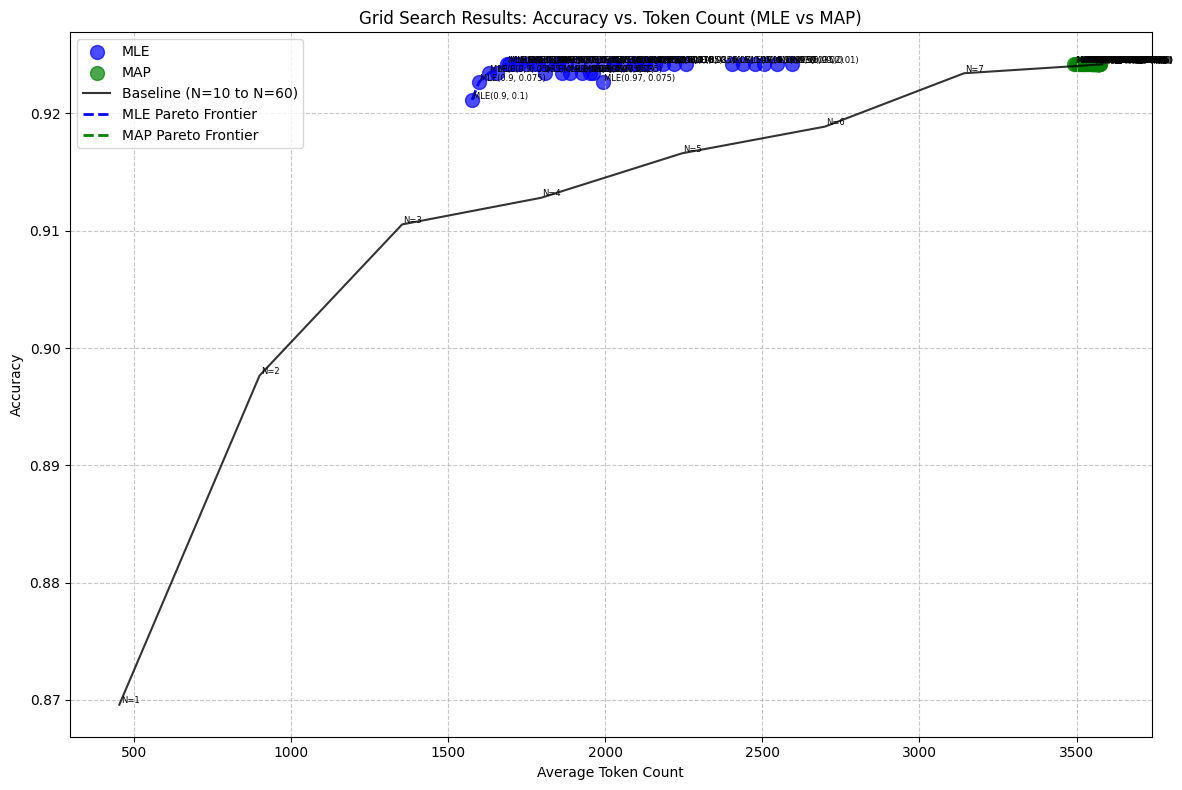


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9212, Avg Token Count: 1576.28
Target Score: 0.9, Percentile: 0.075, Accuracy: 0.9227, Avg Token Count: 1598.19
Target Score: 0.9, Percentile: 0.05, Accuracy: 0.9234, Avg Token Count: 1629.04
Target Score: 0.9, Percentile: 0.02, Accuracy: 0.9242, Avg Token Count: 1686.87

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9242, Avg Token Count: 3492.48


In [7]:
# Setting Panels
target_score_panel_values = [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
percentile_panel_values = [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
max_N_panel = 8
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [8]:
peek_number = 5

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916    0.9949    0.0066    0.7411    0.2207   21.7699    0.5656
1         0.3712      0.0375    0.9981    0.0060    0.6788    0.2410    1.0031    0.0092
2         0.6217      0.1013    0.9587    0.1289    0.8474    0.1030    0.9576    0.1450
3         0.4076      0.0870    7.8571    0.7386    0.6667    0.2388   48.1585    4.1681
4         0.4718      0.1396   40.7569    2.3009    0.6982    0.2116   88.3479    3.3720
5         0.5645      0.0934    0.9938    0.0011    0.8544    0.1269    1.3527    0.1195
6         0.4193      0.0764    0.9969    0.0014    0.7301    0.2255    0.9976    0.0011
7         0.4935      0.1110    0.9271    0.0827    0.8505    0.0908    1.3589    0.2502
8         0.4501      0.1188    0.8408    0.0983    0.7342    0.1348    1.1546    0.2116
9         0.4603      0.1372    6.8503    0.2118    0.7467    0.2300    9.0876    0.2182
10        0.3858      0.0913    0.9926    0.0023    0.6598    0.2628    0.9982    0.0105
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 16

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [5, 5, 8, 5, 7, 5, 5, 6, 16, 5, 5, 13, 5, 5, 5, 5, 5, 16, 5, 5, 9, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 10, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 7, 16, 5, 7, 9, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 12, 5, 12, 14, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9325, Average Token Count: 2762.02
MLE Min N Required [5, 5, 6, 5, 6, 5, 5, 6, 15, 5, 5, 11, 5, 5, 5, 5, 5, 16, 5, 5, 7, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 6, 16, 5, 6, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9310, Average Token Count: 2703.43
MLE Min N Required [5, 5, 6, 5, 5, 5, 5, 5, 13, 5, 5, 10, 5, 5, 5, 5, 5, 16, 5, 5, 6, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9318, Average Token Count: 2649.89
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 5, 6, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9303, Average Token Count: 2602.83
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 8, 5, 5, 5, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9295, Average Token Count: 2564.14
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  14%|█▍        | 1/7 [01:53<11:20, 113.49s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9303, Average Token Count: 2532.96


MLE Min N Required [5, 5, 12, 6, 9, 5, 5, 11, 16, 5, 5, 16, 7, 5, 5, 5, 5, 16, 5, 5, 12, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 15, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 10, 16, 5, 9, 13, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 13, 5, 14, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 11, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 16, 16, 5, 9, 5, 6, 5, 5, 5, 5, 11, 5

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9333, Average Token Count: 2991.27
MLE Min N Required [5, 5, 10, 5, 8, 5, 5, 9, 16, 5, 5, 16, 6, 5, 5, 5, 5, 16, 5, 5, 10, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 13, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 8, 16, 5, 8, 11, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 11, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 8, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 10, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9340, Average Token Count: 2923.54
MLE Min N Required [5, 5, 9, 5, 7, 5, 5, 8, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 9, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 11, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 7, 16, 5, 7, 10, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 10, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9333, Average Token Count: 2863.31
MLE Min N Required [5, 5, 8, 5, 6, 5, 5, 7, 16, 5, 5, 14, 5, 5, 5, 5, 5, 16, 5, 5, 8, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 10, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 7, 16, 5, 6, 9, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9318, Average Token Count: 2820.32
MLE Min N Required [5, 5, 7, 5, 5, 5, 5, 6, 16, 5, 5, 12, 5, 5, 5, 5, 5, 16, 5, 5, 7, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 6, 16, 5, 5, 7, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9318, Average Token Count: 2767.01
MLE Min N Required [5, 5, 6, 5, 5, 5, 5, 6, 16, 5, 5, 11, 5, 5, 5, 5, 5, 16, 5, 5, 6, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 7, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  29%|██▊       | 2/7 [03:48<09:30, 114.17s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9318, Average Token Count: 2722.51


MLE Min N Required [5, 5, 16, 8, 13, 5, 5, 16, 16, 5, 5, 16, 10, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 12, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 6, 5, 5, 5, 16, 14, 16, 6, 13, 16, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 6, 5, 5, 5, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 16, 5, 5, 16, 11, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 14, 5, 9, 5, 5, 9, 5, 5, 5, 5, 5, 10, 5, 5, 7, 7, 5, 7, 13, 5, 5, 5, 15, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 11, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 16, 5, 5, 16, 5, 16, 16, 5, 13, 5, 9, 5, 5

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9333, Average Token Count: 3200.86
MLE Min N Required [5, 5, 15, 7, 11, 5, 5, 14, 16, 5, 5, 16, 8, 5, 5, 5, 5, 16, 5, 5, 14, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 10, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 6, 5, 5, 5, 16, 12, 16, 6, 11, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 15, 5, 16, 5, 5, 5, 5, 5, 5, 7, 5, 5, 8, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 16, 5, 5, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 6, 6, 5, 6, 11, 5, 5, 5, 13, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 9, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 3110.13
MLE Min N Required [5, 5, 13, 6, 9, 5, 5, 12, 16, 5, 5, 16, 7, 5, 5, 5, 5, 16, 5, 5, 12, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 10, 16, 5, 10, 13, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 13, 5, 16, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 10, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 11, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9333, Average Token Count: 3031.47
MLE Min N Required [5, 5, 11, 5, 8, 5, 5, 11, 16, 5, 5, 16, 6, 5, 5, 5, 5, 16, 5, 5, 11, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 14, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 9, 16, 5, 9, 12, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 10, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 2982.09
MLE Min N Required [5, 5, 10, 5, 7, 5, 5, 10, 16, 5, 5, 16, 6, 5, 5, 5, 5, 16, 5, 5, 10, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 12, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 8, 16, 5, 8, 10, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 10, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 9, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 2926.84
MLE Min N Required [5, 5, 9, 5, 7, 5, 5, 9, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 9, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 11, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 7, 16, 5, 7, 9, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Target Score (MLE):  43%|████▎     | 3/7 [05:43<07:39, 114.92s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9333, Average Token Count: 2891.59


MLE Min N Required [5, 5, 16, 10, 16, 5, 5, 16, 16, 5, 5, 16, 12, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 15, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 9, 5, 5, 5, 16, 16, 16, 8, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 6, 7, 6, 5, 5, 16, 16, 5, 16, 6, 6, 8, 5, 5, 5, 10, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 16, 5, 5, 16, 13, 7, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 5, 11, 5, 5, 12, 5, 5, 5, 5, 5, 13, 5, 5, 8, 8, 5, 8, 16, 5, 5, 5, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 13, 16, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 11, 5, 5, 6, 5, 16, 5, 5, 10, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 11, 16, 5, 5, 16, 5, 16, 16, 5, 16

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9333, Average Token Count: 3369.04
MLE Min N Required [5, 5, 16, 8, 13, 5, 5, 16, 16, 5, 5, 16, 10, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 13, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 8, 5, 5, 5, 16, 14, 16, 7, 14, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 6, 6, 5, 5, 5, 16, 16, 5, 16, 5, 5, 7, 5, 5, 5, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 16, 5, 5, 16, 11, 6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 10, 5, 5, 10, 5, 5, 5, 5, 5, 11, 5, 5, 7, 7, 5, 7, 14, 5, 5, 5, 16, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 11, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 9, 5, 5, 6, 5, 16, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 14, 6, 5, 5,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 3265.47
MLE Min N Required [5, 5, 16, 7, 12, 5, 5, 16, 16, 5, 5, 16, 9, 5, 5, 5, 5, 16, 5, 5, 15, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 11, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 7, 5, 5, 5, 16, 12, 16, 6, 12, 16, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 6, 5, 5, 5, 7, 5, 5, 8, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 16, 5, 5, 16, 10, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 14, 5, 8, 5, 5, 9, 5, 5, 5, 5, 5, 10, 5, 5, 6, 6, 5, 6, 12, 5, 5, 5, 14, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 10, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9333, Average Token Count: 3176.79
MLE Min N Required [5, 5, 14, 6, 10, 5, 5, 15, 16, 5, 5, 16, 8, 5, 5, 5, 5, 16, 5, 5, 14, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 10, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 6, 5, 5, 5, 16, 11, 16, 5, 11, 15, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 15, 5, 16, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 16, 5, 5, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 9, 5, 5, 5, 6, 5, 5, 11, 5, 5, 5, 13, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 9, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 15, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9333, Average Token Count: 3113.75
MLE Min N Required [5, 5, 13, 6, 9, 5, 5, 13, 16, 5, 5, 16, 7, 5, 5, 5, 5, 16, 5, 5, 12, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 16, 5, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 10, 16, 5, 9, 13, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 13, 5, 16, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 11, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 11, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 13, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9333, Average Token Count: 3039.26
MLE Min N Required [5, 5, 11, 5, 8, 5, 5, 11, 16, 5, 5, 16, 6, 5, 5, 5, 5, 16, 5, 5, 11, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 14, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 9, 16, 5, 8, 12, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 9, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 10, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  57%|█████▋    | 4/7 [07:40<05:46, 115.50s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9340, Average Token Count: 2986.47


MLE Min N Required [5, 5, 16, 13, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 16, 16, 5, 7, 5, 7, 7, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 16, 5, 16, 5, 7, 5, 10, 7, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 11, 5, 5, 5, 13, 5, 5, 5, 16, 16, 16, 11, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 11, 8, 9, 8, 5, 5, 16, 16, 5, 16, 8, 7, 10, 5, 5, 5, 13, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 16, 5, 5, 13, 5, 5, 12, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 16, 5, 15, 5, 5, 15, 5, 5, 5, 5, 5, 16, 5, 5, 11, 11, 5, 11, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 13, 16, 16, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 8, 5, 16, 5, 5, 14, 5, 5, 6, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 16, 9, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 10, 7, 5, 5, 5, 16, 16, 5, 5, 16, 5,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 3615.60
MLE Min N Required [5, 5, 16, 11, 16, 5, 5, 16, 16, 5, 5, 16, 13, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 16, 16, 5, 6, 5, 6, 6, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 5, 9, 6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 11, 5, 5, 5, 16, 16, 16, 9, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 10, 7, 8, 7, 5, 5, 16, 16, 5, 16, 7, 6, 9, 5, 5, 5, 11, 5, 5, 12, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 11, 5, 5, 10, 16, 5, 5, 5, 5, 16, 5, 5, 16, 15, 14, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 5, 13, 5, 5, 13, 5, 5, 5, 5, 5, 16, 5, 5, 9, 9, 5, 9, 16, 5, 5, 5, 16, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 11, 15, 16, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 16, 5, 5, 7, 5, 16, 5, 5, 12, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 3490.19
MLE Min N Required [5, 5, 16, 9, 15, 5, 5, 16, 16, 5, 5, 16, 12, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 14, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 10, 5, 5, 5, 16, 16, 16, 8, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 6, 7, 6, 5, 5, 16, 16, 5, 16, 6, 5, 8, 5, 5, 5, 10, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 10, 5, 5, 9, 16, 5, 5, 5, 5, 16, 5, 5, 16, 13, 12, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 5, 11, 5, 5, 11, 5, 5, 5, 5, 5, 14, 5, 5, 8, 8, 5, 8, 16, 5, 5, 5, 16, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 13, 16, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 16, 5, 5, 6, 5, 16, 5, 5, 10, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 16,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9340, Average Token Count: 3388.02
MLE Min N Required [5, 5, 16, 8, 14, 5, 5, 16, 16, 5, 5, 16, 10, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 13, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 9, 5, 5, 5, 16, 15, 16, 7, 14, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 6, 6, 5, 5, 5, 16, 16, 5, 16, 5, 5, 7, 5, 5, 5, 9, 5, 5, 9, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 9, 5, 5, 8, 16, 5, 5, 5, 5, 16, 5, 5, 16, 11, 11, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 10, 5, 5, 10, 5, 5, 5, 5, 5, 13, 5, 5, 7, 7, 5, 7, 14, 5, 5, 5, 16, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 11, 16, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 15, 5, 5, 6, 5, 16, 5, 5, 9, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 16, 6, 

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 3312.57
MLE Min N Required [5, 5, 16, 7, 12, 5, 5, 16, 16, 5, 5, 16, 9, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 11, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 8, 5, 5, 5, 16, 13, 16, 6, 12, 16, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 7, 16, 5, 5, 5, 5, 16, 5, 5, 16, 10, 9, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 15, 5, 9, 5, 5, 9, 5, 5, 5, 5, 5, 11, 5, 5, 6, 6, 5, 6, 12, 5, 5, 5, 15, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 10, 16, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 13, 5, 5, 5, 5, 16, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 3226.75
MLE Min N Required [5, 5, 15, 7, 11, 5, 5, 16, 16, 5, 5, 16, 8, 5, 5, 5, 5, 16, 5, 5, 14, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 10, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 7, 5, 5, 5, 16, 11, 16, 6, 11, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 15, 5, 16, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 6, 16, 5, 5, 5, 5, 16, 5, 5, 16, 9, 8, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 13, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 10, 5, 5, 6, 6, 5, 6, 11, 5, 5, 5, 13, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 9, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 12, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5

Target Score (MLE):  71%|███████▏  | 5/7 [09:38<03:53, 116.54s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9340, Average Token Count: 3158.84


MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 5, 16, 5, 6, 16, 16, 5, 5, 7, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 16, 16, 5, 10, 5, 10, 10, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 16, 5, 16, 5, 11, 6, 16, 10, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 9, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 9, 16, 5, 5, 5, 5, 6, 16, 12, 13, 12, 5, 5, 16, 16, 5, 16, 12, 11, 15, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 6, 13, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 9, 5, 5, 5, 5, 5, 9, 16, 5, 6, 10, 5, 11, 5, 5, 5, 5, 11, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 8, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 6, 5, 16, 16, 16, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 5, 5, 12, 5, 16, 5, 5, 16, 5, 5, 9, 14, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 5, 5, 9, 5, 5, 16, 13, 5, 5, 7, 5, 5, 5, 9, 11, 5, 5, 5, 5, 5, 5, 5, 15, 10, 5, 5, 5, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 3948.74
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 9, 5, 8, 8, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 16, 5, 16, 5, 9, 5, 16, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 14, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 13, 16, 16, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 14, 11, 11, 10, 5, 5, 16, 16, 5, 16, 10, 9, 13, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 11, 5, 5, 5, 16, 5, 5, 16, 5, 5, 15, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 8, 5, 5, 5, 5, 5, 8, 16, 5, 5, 9, 5, 10, 5, 5, 5, 5, 9, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 7, 5, 5, 5, 5, 16, 5, 5, 13, 14, 5, 13, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 11, 5, 16, 5, 5, 16, 5, 5, 8, 12, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9340, Average Token Count: 3836.98
MLE Min N Required [5, 5, 16, 14, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 8, 5, 7, 7, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 16, 5, 16, 5, 8, 5, 14, 8, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 12, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 12, 16, 16, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 12, 9, 10, 9, 5, 5, 16, 16, 5, 16, 9, 8, 11, 5, 5, 5, 14, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 10, 5, 5, 5, 16, 5, 5, 16, 5, 5, 13, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 7, 5, 5, 5, 5, 5, 7, 16, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 16, 16, 5, 16, 5, 5, 16, 6, 5, 5, 5, 5, 16, 5, 5, 11, 12, 5, 12, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 14, 16, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 9, 5, 16, 5, 5, 16, 5, 5, 7, 10, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9340, Average Token Count: 3721.58
MLE Min N Required [5, 5, 16, 12, 16, 5, 5, 16, 16, 5, 5, 16, 15, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 7, 5, 7, 6, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 16, 5, 16, 5, 7, 5, 13, 7, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 11, 5, 5, 5, 15, 5, 5, 5, 16, 16, 16, 10, 16, 16, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 11, 8, 9, 8, 5, 5, 16, 16, 5, 16, 8, 7, 10, 5, 5, 5, 13, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 16, 5, 5, 16, 5, 5, 12, 16, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 6, 5, 5, 5, 5, 5, 6, 16, 5, 5, 7, 5, 8, 5, 5, 5, 5, 7, 5, 5, 5, 16, 16, 5, 15, 5, 5, 15, 5, 5, 5, 5, 5, 16, 5, 5, 10, 11, 5, 10, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 13, 16, 16, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 16, 5, 5, 8, 5, 16, 5, 5, 14, 5, 5, 6, 9, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 3641.67
MLE Min N Required [5, 5, 16, 11, 16, 5, 5, 16, 16, 5, 5, 16, 13, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 6, 5, 6, 6, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 5, 11, 6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 13, 5, 5, 5, 16, 16, 16, 9, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 10, 7, 7, 7, 5, 5, 16, 16, 5, 16, 7, 6, 9, 5, 5, 5, 11, 5, 5, 12, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 16, 5, 5, 10, 16, 5, 5, 5, 5, 16, 5, 5, 16, 15, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 7, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 5, 13, 5, 5, 13, 5, 5, 5, 5, 5, 16, 5, 5, 9, 9, 5, 9, 16, 5, 5, 5, 16, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 11, 15, 16, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 16, 5, 5, 7, 5, 16, 5, 5, 13, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 3527.13
MLE Min N Required [5, 5, 16, 10, 16, 5, 5, 16, 16, 5, 5, 16, 12, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 15, 16, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 16, 5, 6, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 12, 5, 5, 5, 16, 16, 16, 8, 16, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 6, 7, 6, 5, 5, 16, 16, 5, 16, 6, 6, 8, 5, 5, 5, 10, 5, 5, 11, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 16, 5, 5, 9, 16, 5, 5, 5, 5, 16, 5, 5, 16, 13, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 16, 16, 5, 11, 5, 5, 12, 5, 5, 5, 5, 5, 16, 5, 5, 8, 8, 5, 8, 16, 5, 5, 5, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 13, 16, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 16, 5, 5, 6, 5, 16, 5, 5, 11, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5,

Target Score (MLE):  86%|████████▌ | 6/7 [11:40<01:58, 118.29s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9333, Average Token Count: 3451.86


MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 11, 16, 5, 11, 16, 16, 5, 8, 16, 5, 16, 7, 5, 6, 11, 5, 5, 5, 5, 16, 16, 16, 7, 16, 5, 16, 16, 16, 6, 5, 16, 5, 5, 5, 5, 11, 5, 5, 16, 5, 5, 7, 16, 13, 16, 5, 16, 5, 16, 12, 16, 16, 5, 5, 12, 5, 11, 5, 5, 16, 5, 11, 16, 5, 9, 5, 5, 5, 5, 6, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 6, 5, 16, 16, 5, 5, 5, 6, 12, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 9, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 11, 16, 5, 8, 12, 16, 7, 8, 15, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 16, 6, 16, 5, 12, 16, 16, 16, 16, 5, 5, 9, 7, 5, 16, 16, 5, 11, 16, 5, 16, 16, 6, 5, 5, 16, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 16, 5, 5, 7, 9, 16, 5, 5, 16, 16, 9, 16, 16, 5, 5, 5, 16, 8, 5, 5, 10, 16, 5, 6, 5, 6, 9, 5, 5, 5, 5, 5, 5, 8, 16, 5, 6, 5, 5, 12, 5, 16, 16, 16, 5, 5, 5, 5, 13, 11, 6, 16, 8, 7, 16, 5, 5, 16, 5, 16, 5, 5, 16, 9, 5, 16, 16, 5, 5, 5, 5, 16, 12, 11, 16, 5, 5, 8, 12, 16, 5, 6, 16, 16, 5, 8, 13, 8, 5, 5, 16, 16,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9348, Average Token Count: 4623.77
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 9, 16, 5, 9, 16, 16, 5, 7, 15, 5, 14, 6, 5, 5, 9, 5, 5, 5, 5, 16, 16, 16, 6, 16, 5, 16, 16, 16, 5, 5, 16, 5, 5, 5, 5, 9, 5, 5, 16, 5, 5, 6, 14, 11, 16, 5, 16, 5, 16, 10, 16, 16, 5, 5, 10, 5, 9, 5, 5, 16, 5, 9, 16, 5, 8, 5, 5, 5, 5, 6, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 6, 10, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 7, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 10, 16, 5, 7, 10, 16, 6, 7, 13, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 16, 5, 16, 5, 10, 16, 16, 16, 16, 5, 5, 8, 6, 5, 16, 16, 5, 9, 16, 5, 16, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 13, 5, 5, 6, 8, 16, 5, 5, 16, 16, 8, 16, 16, 5, 5, 5, 16, 7, 5, 5, 8, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 10, 5, 16, 16, 16, 5, 5, 5, 5, 11, 10, 5, 16, 7, 6, 16, 5, 5, 16, 5, 16, 5, 5, 16, 7, 5, 15, 1

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9348, Average Token Count: 4494.48
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 8, 16, 5, 8, 16, 16, 5, 6, 13, 5, 12, 5, 5, 5, 8, 5, 5, 5, 5, 16, 16, 16, 5, 15, 5, 14, 14, 16, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 12, 10, 16, 5, 16, 5, 16, 9, 16, 15, 5, 5, 9, 5, 8, 5, 5, 16, 5, 8, 16, 5, 7, 5, 5, 5, 5, 5, 15, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 9, 16, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 15, 16, 6, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 8, 16, 5, 6, 9, 16, 5, 6, 11, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 14, 5, 16, 5, 9, 16, 16, 16, 15, 5, 5, 7, 6, 5, 15, 16, 5, 8, 15, 5, 16, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 12, 5, 5, 5, 7, 16, 5, 5, 16, 16, 7, 16, 16, 5, 5, 5, 16, 6, 5, 5, 7, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 6, 14, 5, 5, 5, 5, 9, 5, 16, 16, 16, 5, 5, 5, 5, 9, 8, 5, 16, 6, 5, 16, 5, 5, 16, 5, 16, 5, 5, 16, 6, 5, 13, 16, 5, 5, 

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9348, Average Token Count: 4372.34
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 7, 16, 5, 7, 16, 16, 5, 5, 12, 5, 11, 5, 5, 5, 7, 5, 5, 5, 5, 16, 16, 16, 5, 13, 5, 13, 12, 16, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 5, 11, 9, 16, 5, 16, 5, 14, 8, 16, 13, 5, 5, 8, 5, 7, 5, 5, 16, 5, 7, 16, 5, 6, 5, 5, 5, 5, 5, 13, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 8, 16, 16, 16, 15, 5, 5, 16, 16, 5, 16, 15, 14, 16, 6, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 5, 6, 8, 16, 5, 5, 10, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 13, 5, 16, 5, 8, 16, 16, 16, 13, 5, 5, 6, 5, 5, 13, 16, 5, 7, 13, 5, 16, 14, 5, 5, 5, 14, 15, 16, 5, 16, 16, 5, 16, 5, 5, 16, 10, 5, 5, 5, 6, 16, 5, 5, 16, 16, 6, 16, 16, 5, 5, 5, 16, 5, 5, 5, 7, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 8, 5, 16, 16, 16, 5, 5, 5, 5, 8, 8, 5, 16, 5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 16, 6, 5, 11, 16, 5, 5, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 4283.45
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 6, 16, 5, 6, 16, 16, 5, 5, 10, 5, 9, 5, 5, 5, 6, 5, 5, 5, 5, 16, 16, 16, 5, 12, 5, 11, 11, 16, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 10, 8, 16, 5, 16, 5, 12, 7, 16, 12, 5, 5, 7, 5, 6, 5, 5, 16, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 12, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 7, 16, 14, 14, 13, 5, 5, 16, 16, 5, 16, 13, 12, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 5, 5, 7, 14, 5, 5, 9, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 11, 5, 16, 5, 7, 16, 16, 16, 12, 5, 5, 5, 5, 5, 11, 16, 5, 6, 12, 5, 16, 12, 5, 5, 5, 12, 13, 14, 5, 16, 16, 5, 16, 5, 5, 16, 9, 5, 5, 5, 6, 16, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 7, 5, 16, 16, 16, 5, 5, 5, 5, 7, 7, 5, 16, 5, 5, 16, 5, 5, 14, 5, 16, 5, 5, 16, 5, 5, 10, 15, 5, 5, 5, 5

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 4164.21
MLE Min N Required [5, 5, 16, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 6, 16, 5, 6, 16, 16, 5, 5, 9, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 16, 16, 16, 5, 10, 5, 10, 10, 16, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 9, 7, 16, 5, 16, 5, 11, 6, 16, 10, 5, 5, 6, 5, 6, 5, 5, 16, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 10, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 16, 16, 16, 5, 5, 5, 16, 16, 5, 5, 5, 5, 6, 16, 12, 13, 12, 5, 5, 16, 16, 5, 16, 12, 11, 15, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 16, 5, 5, 6, 13, 5, 5, 8, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 10, 5, 16, 5, 6, 16, 16, 16, 10, 5, 5, 5, 5, 5, 10, 16, 5, 6, 10, 5, 16, 11, 5, 5, 5, 11, 12, 13, 5, 16, 16, 5, 16, 5, 5, 16, 8, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 6, 5, 16, 16, 16, 5, 5, 5, 5, 7, 6, 5, 16, 5, 5, 16, 5, 5, 12, 5, 16, 5, 5, 16, 5, 5, 9, 14, 5, 5, 5, 5, 

Target Score (MLE): 100%|██████████| 7/7 [13:47<00:00, 118.27s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9340, Average Token Count: 4075.25

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 10, 16, 5, 16, 16, 16, 6, 16, 16, 8, 16, 5, 16, 16, 9, 5, 5, 16, 16, 12, 5, 15, 16, 5, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 6, 16, 7, 7, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 10, 8, 6, 16, 16, 16, 16, 11, 16, 16, 6, 16, 16, 10, 16, 16, 16, 5, 16, 5, 16, 16, 8, 16, 5, 16, 16, 16, 14, 16, 16, 7, 16, 5, 16, 11, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 16, 16, 16, 16, 14, 16, 9, 9, 7, 5, 16, 10, 16, 16, 10, 15, 16, 16, 5, 6, 16, 15, 16, 5, 5, 16, 16, 16, 15, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 10, 16, 16, 16, 5, 16, 16, 5, 12, 5, 16, 5, 16, 5, 10, 16, 16, 12, 16, 16, 16, 16, 5, 11, 16, 16, 16, 16, 16, 5, 16, 16, 7, 10, 16, 8, 16, 5, 16, 16, 5, 16, 5, 13, 16, 14, 16, 5, 16, 11, 16, 16, 16, 16, 16, 16, 7, 13, 16, 16, 10, 14, 16, 5, 16, 16, 7, 16, 16, 5, 5, 16, 5, 16, 6, 16, 16, 8, 16, 5,

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9333, Average Token Count: 5764.96
MAP Min N Required [16, 16, 14, 16, 16, 13, 16, 14, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 9, 16, 5, 16, 16, 16, 6, 16, 16, 7, 16, 5, 16, 16, 8, 5, 5, 16, 16, 10, 5, 12, 16, 5, 9, 16, 5, 16, 15, 16, 16, 16, 16, 14, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 6, 6, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 9, 7, 5, 16, 16, 16, 16, 10, 16, 16, 5, 14, 16, 8, 16, 16, 16, 5, 16, 5, 16, 16, 7, 16, 5, 16, 16, 16, 12, 16, 16, 6, 16, 5, 16, 10, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 12, 16, 8, 8, 6, 5, 16, 9, 16, 16, 9, 12, 16, 16, 5, 5, 16, 13, 16, 5, 5, 16, 16, 16, 13, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 9, 16, 16, 16, 5, 16, 16, 5, 10, 5, 16, 5, 16, 5, 9, 16, 16, 10, 16, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 5, 16, 16, 6, 8, 16, 7, 16, 5, 16, 16, 5, 16, 5, 11, 16, 12, 16, 5, 16, 9, 16, 16, 16, 16, 16, 16, 6

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 5601.07
MAP Min N Required [16, 16, 12, 16, 16, 11, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 15, 8, 16, 5, 16, 16, 16, 5, 16, 16, 6, 16, 5, 16, 16, 7, 5, 5, 16, 16, 9, 5, 11, 16, 5, 8, 16, 5, 14, 13, 16, 16, 16, 16, 12, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 6, 5, 16, 16, 16, 14, 5, 16, 16, 16, 5, 16, 5, 7, 6, 5, 16, 16, 16, 16, 8, 16, 16, 5, 12, 16, 7, 16, 16, 16, 5, 16, 5, 16, 16, 6, 16, 5, 16, 16, 16, 11, 16, 16, 5, 16, 5, 16, 8, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 9, 16, 15, 16, 16, 11, 16, 7, 7, 5, 5, 16, 7, 16, 16, 8, 11, 16, 16, 5, 5, 16, 11, 16, 5, 5, 16, 16, 16, 11, 5, 16, 16, 5, 16, 16, 5, 15, 16, 16, 5, 16, 5, 8, 16, 16, 16, 5, 16, 16, 5, 9, 5, 16, 5, 16, 5, 7, 16, 16, 9, 16, 16, 16, 16, 5, 8, 16, 16, 16, 16, 16, 5, 16, 16, 5, 7, 16, 6, 16, 5, 16, 16, 5, 16, 5, 10, 16, 10, 16, 5, 16, 8, 16, 16, 16, 16, 16, 13, 5, 10, 16

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 5436.69
MAP Min N Required [16, 16, 11, 16, 16, 10, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 14, 5, 13, 7, 16, 5, 16, 16, 16, 5, 16, 16, 6, 16, 5, 16, 15, 6, 5, 5, 16, 16, 8, 5, 10, 16, 5, 7, 16, 5, 13, 12, 16, 16, 16, 16, 11, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 16, 16, 12, 5, 16, 16, 16, 5, 16, 5, 7, 5, 5, 16, 16, 16, 16, 8, 16, 16, 5, 11, 16, 7, 16, 16, 16, 5, 16, 5, 16, 16, 6, 15, 5, 16, 16, 16, 10, 16, 16, 5, 16, 5, 16, 7, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 14, 16, 16, 9, 16, 6, 6, 5, 5, 16, 7, 16, 16, 7, 10, 16, 16, 5, 5, 16, 10, 16, 5, 5, 16, 16, 16, 10, 5, 15, 16, 5, 16, 16, 5, 14, 16, 16, 5, 16, 5, 7, 16, 16, 16, 5, 16, 16, 5, 8, 5, 16, 5, 16, 5, 7, 16, 16, 8, 16, 16, 16, 16, 5, 8, 16, 16, 16, 16, 16, 5, 16, 16, 5, 7, 16, 5, 16, 5, 16, 16, 5, 16, 5, 9, 16, 9, 16, 5, 16, 7, 16, 16, 16, 16, 16, 12, 5, 9, 16, 1

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 5329.49
MAP Min N Required [16, 16, 9, 16, 16, 9, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 12, 5, 12, 6, 14, 5, 16, 16, 16, 5, 16, 15, 5, 16, 5, 16, 13, 5, 5, 5, 16, 16, 7, 5, 8, 16, 5, 6, 16, 5, 11, 10, 16, 16, 16, 16, 9, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 16, 16, 11, 5, 16, 16, 16, 5, 16, 5, 6, 5, 5, 16, 16, 16, 16, 7, 16, 16, 5, 9, 16, 6, 16, 16, 16, 5, 15, 5, 16, 16, 5, 13, 5, 16, 16, 16, 8, 16, 16, 5, 16, 5, 16, 6, 16, 7, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 7, 16, 12, 16, 16, 8, 16, 6, 5, 5, 5, 16, 6, 16, 16, 6, 8, 16, 16, 5, 5, 16, 9, 16, 5, 5, 16, 16, 16, 9, 5, 13, 16, 5, 14, 16, 5, 12, 16, 16, 5, 16, 5, 6, 16, 16, 16, 5, 16, 16, 5, 7, 5, 16, 5, 16, 5, 6, 16, 16, 7, 16, 16, 16, 16, 5, 7, 16, 16, 16, 16, 16, 5, 16, 16, 5, 6, 16, 5, 16, 5, 16, 16, 5, 16, 5, 8, 16, 8, 16, 5, 16, 6, 16, 16, 16, 16, 16, 10, 5, 8, 14, 16, 6, 8, 16

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9325, Average Token Count: 5186.40
MAP Min N Required [16, 16, 8, 16, 16, 8, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 11, 5, 10, 5, 12, 5, 16, 16, 16, 5, 16, 14, 5, 16, 5, 16, 12, 5, 5, 5, 16, 16, 6, 5, 8, 16, 5, 5, 16, 5, 10, 9, 16, 16, 16, 16, 8, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 16, 16, 10, 5, 16, 16, 16, 5, 16, 5, 5, 5, 5, 16, 16, 16, 16, 6, 16, 16, 5, 8, 16, 5, 15, 16, 16, 5, 13, 5, 16, 16, 5, 12, 5, 16, 16, 16, 7, 16, 16, 5, 15, 5, 16, 6, 16, 6, 16, 16, 13, 16, 16, 5, 16, 16, 16, 16, 6, 16, 11, 16, 16, 7, 16, 5, 5, 5, 5, 16, 5, 16, 16, 5, 8, 16, 16, 5, 5, 16, 8, 16, 5, 5, 16, 16, 16, 8, 5, 12, 16, 5, 12, 16, 5, 11, 16, 16, 5, 16, 5, 5, 16, 16, 16, 5, 16, 16, 5, 6, 5, 16, 5, 16, 5, 5, 16, 16, 6, 16, 16, 16, 15, 5, 6, 16, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 16, 5, 16, 16, 5, 16, 5, 7, 16, 7, 16, 5, 16, 6, 16, 16, 16, 14, 16, 9, 5, 7, 12, 16, 5, 7, 16,

Target Score (MAP):  14%|█▍        | 1/7 [02:17<13:44, 137.38s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9325, Average Token Count: 5049.03


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 7, 5, 5, 16, 16, 5, 16, 16, 16, 5, 16, 16, 16, 11, 16, 16, 14, 16, 5, 16, 16, 15, 9, 6, 16, 16, 16, 6, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 5, 5, 16, 8, 16, 16, 16, 11, 11, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 13, 9, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 7, 16, 16, 14, 16, 9, 16, 16, 16, 16, 16, 16, 12, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 11, 8, 16, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 5, 7, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 7, 16, 16, 16, 16, 5, 16, 16, 7, 16, 7, 16, 7, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 11, 15, 16, 13, 16, 8, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 16, 12, 16, 16, 5, 5, 16, 8, 16, 10, 

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9333, Average Token Count: 6209.92
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 6, 5, 5, 16, 16, 5, 16, 14, 16, 5, 16, 16, 16, 9, 16, 16, 12, 16, 5, 16, 16, 13, 8, 5, 16, 16, 16, 5, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 16, 16, 16, 5, 5, 16, 7, 16, 14, 16, 10, 9, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 14, 11, 8, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 13, 16, 16, 16, 5, 16, 6, 16, 16, 12, 16, 7, 16, 16, 16, 16, 16, 16, 10, 16, 7, 16, 15, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 12, 10, 7, 16, 15, 16, 16, 13, 16, 16, 16, 5, 8, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 6, 14, 16, 16, 16, 5, 16, 16, 6, 16, 6, 16, 6, 16, 5, 14, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 9, 13, 16, 11, 16, 6, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 15, 16,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 6094.73
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 12, 16, 5, 16, 16, 16, 8, 16, 16, 10, 16, 5, 16, 16, 11, 7, 5, 16, 16, 14, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 16, 16, 16, 16, 7, 16, 5, 16, 16, 16, 5, 5, 16, 6, 16, 12, 16, 8, 8, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 12, 9, 7, 16, 16, 16, 16, 14, 16, 16, 7, 16, 16, 12, 16, 16, 16, 5, 16, 5, 16, 16, 10, 16, 6, 16, 16, 16, 16, 16, 16, 9, 16, 6, 16, 13, 16, 15, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 11, 11, 8, 6, 16, 13, 16, 16, 12, 16, 16, 16, 5, 7, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 12, 16, 16, 16, 5, 16, 16, 5, 15, 6, 16, 6, 16, 5, 12, 16, 16, 16, 16, 16, 16, 16, 7, 13, 16, 16, 16, 16, 16, 5, 16, 16, 8, 11, 16, 9, 16, 6, 16, 16, 5, 16, 5, 15, 16, 16, 16, 5, 16, 13, 16, 16, 

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 5965.71
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 11, 16, 5, 16, 16, 16, 7, 16, 16, 9, 16, 5, 16, 16, 10, 6, 5, 16, 16, 13, 5, 15, 16, 5, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 11, 16, 8, 7, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 11, 8, 6, 16, 16, 16, 16, 12, 16, 16, 6, 16, 16, 10, 16, 16, 16, 5, 16, 5, 16, 16, 9, 16, 6, 16, 16, 16, 15, 16, 16, 8, 16, 5, 16, 12, 16, 13, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 12, 16, 16, 16, 16, 15, 16, 10, 10, 7, 5, 16, 12, 16, 16, 10, 15, 16, 16, 5, 6, 16, 16, 16, 5, 5, 16, 16, 16, 15, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 11, 16, 16, 16, 5, 16, 16, 5, 13, 5, 16, 5, 16, 5, 11, 16, 16, 14, 16, 16, 16, 16, 6, 12, 16, 16, 16, 16, 16, 5, 16, 16, 7, 10, 16, 9, 16, 5, 16, 16, 5, 16, 5, 14, 16, 14, 16, 5, 16, 11, 16, 16, 1

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 5859.88
MAP Min N Required [16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 9, 16, 5, 16, 16, 16, 6, 16, 16, 8, 16, 5, 16, 16, 9, 5, 5, 16, 16, 11, 5, 13, 16, 5, 9, 16, 5, 16, 16, 16, 16, 16, 16, 15, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 9, 16, 7, 6, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 9, 7, 5, 16, 16, 16, 16, 11, 16, 16, 5, 15, 16, 9, 16, 16, 16, 5, 16, 5, 16, 16, 8, 16, 5, 16, 16, 16, 13, 16, 16, 7, 16, 5, 16, 10, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 16, 16, 13, 16, 9, 8, 7, 5, 16, 10, 16, 16, 9, 13, 16, 16, 5, 5, 16, 13, 16, 5, 5, 16, 16, 16, 13, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 10, 16, 16, 16, 5, 16, 16, 5, 11, 5, 16, 5, 16, 5, 10, 16, 16, 13, 16, 16, 16, 16, 5, 10, 16, 16, 16, 16, 16, 5, 16, 16, 6, 9, 16, 7, 16, 5, 16, 16, 5, 16, 5, 12, 16, 12, 16, 5, 16, 10, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9333, Average Token Count: 5716.34
MAP Min N Required [16, 16, 14, 16, 16, 13, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 5, 5, 5, 16, 16, 5, 16, 8, 16, 5, 16, 16, 16, 6, 16, 16, 7, 16, 5, 16, 16, 8, 5, 5, 16, 16, 10, 5, 12, 16, 5, 8, 16, 5, 16, 14, 16, 16, 16, 16, 14, 5, 16, 5, 16, 16, 16, 5, 5, 16, 5, 16, 8, 16, 6, 6, 16, 16, 16, 15, 5, 16, 16, 16, 5, 16, 5, 8, 7, 5, 16, 16, 16, 16, 10, 16, 16, 5, 14, 16, 8, 16, 16, 16, 5, 16, 5, 16, 16, 7, 16, 5, 16, 16, 16, 12, 16, 16, 6, 16, 5, 16, 9, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 12, 16, 8, 7, 6, 5, 16, 9, 16, 16, 8, 12, 16, 16, 5, 5, 16, 12, 16, 5, 5, 16, 16, 16, 12, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 5, 9, 16, 16, 16, 5, 16, 16, 5, 10, 5, 16, 5, 16, 5, 9, 16, 16, 11, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 16, 5, 16, 16, 6, 8, 16, 7, 16, 5, 16, 16, 5, 16, 5, 11, 16, 11, 16, 5, 16, 9, 16, 16, 16, 16, 16, 14, 6

Target Score (MAP):  29%|██▊       | 2/7 [04:37<11:34, 138.82s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 5594.37


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 6, 16, 16, 11, 5, 5, 16, 16, 6, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 14, 9, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 14, 16, 5, 16, 16, 16, 5, 5, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 9, 16, 10, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 5, 14, 16, 16, 16, 5, 11, 16, 16, 16, 16, 7, 16, 16, 8, 16, 16, 5, 16, 16, 16, 7, 16, 12, 16, 16, 16, 16, 5, 16, 16, 11, 16, 12, 16, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9333, Average Token Count: 6500.66
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 9, 5, 5, 16, 16, 5, 16, 16, 16, 8, 16, 16, 16, 14, 16, 16, 16, 16, 6, 16, 16, 16, 12, 7, 16, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 5, 5, 16, 10, 16, 16, 16, 15, 14, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 8, 16, 9, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 15, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 10, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 5, 9, 16, 16, 16, 16, 6, 16, 16, 7, 16, 16, 5, 16, 16, 16, 6, 16, 10, 16, 16, 16, 16, 5, 16, 16, 9, 16, 10, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 8, 16, 16, 14, 16, 16, 16, 16, 10, 16, 16, 5, 16, 5, 16, 16, 16, 

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 6404.45
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 8, 5, 5, 16, 16, 5, 16, 16, 16, 7, 16, 16, 16, 12, 16, 16, 15, 16, 5, 16, 16, 16, 10, 6, 16, 16, 16, 7, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 10, 16, 5, 16, 16, 16, 5, 5, 16, 9, 16, 16, 16, 13, 12, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 14, 10, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 7, 16, 8, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 13, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 9, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 5, 8, 16, 16, 16, 16, 6, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 9, 16, 16, 16, 16, 5, 16, 16, 8, 16, 9, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 7, 16, 16, 12, 16, 16, 14, 16, 8, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 1

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 6303.29
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 7, 5, 5, 16, 16, 5, 16, 16, 16, 6, 16, 16, 16, 11, 16, 16, 14, 16, 5, 16, 16, 15, 9, 6, 16, 16, 16, 6, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 5, 5, 16, 8, 16, 16, 16, 11, 11, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 13, 9, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 7, 16, 16, 14, 16, 9, 16, 16, 16, 16, 16, 16, 12, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 12, 8, 16, 16, 16, 16, 15, 16, 16, 16, 5, 9, 16, 16, 16, 5, 7, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 8, 16, 16, 16, 16, 5, 16, 16, 7, 16, 8, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 11, 15, 16, 13, 16, 8, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 16,

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 6227.88
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 6, 5, 5, 16, 16, 5, 16, 14, 16, 6, 16, 16, 16, 10, 16, 16, 12, 16, 5, 16, 16, 13, 8, 5, 16, 16, 16, 6, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 16, 8, 16, 5, 16, 16, 16, 5, 5, 16, 7, 16, 16, 16, 10, 9, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 15, 11, 8, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 14, 16, 16, 16, 6, 16, 6, 16, 16, 12, 16, 8, 16, 16, 16, 16, 16, 16, 10, 16, 7, 16, 15, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 13, 10, 7, 16, 16, 16, 16, 13, 16, 16, 16, 5, 8, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 7, 14, 16, 16, 16, 5, 16, 16, 6, 16, 7, 16, 7, 16, 5, 15, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 5, 16, 16, 9, 13, 16, 11, 16, 7, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 15, 16

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9333, Average Token Count: 6124.94
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 6, 5, 5, 16, 16, 5, 16, 13, 16, 5, 16, 16, 16, 9, 16, 16, 11, 16, 5, 16, 16, 12, 7, 5, 16, 16, 14, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 16, 16, 16, 16, 7, 16, 5, 16, 16, 16, 5, 5, 16, 6, 16, 16, 16, 9, 8, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 13, 10, 7, 16, 16, 16, 16, 14, 16, 16, 7, 16, 16, 12, 16, 16, 16, 5, 16, 5, 16, 16, 11, 16, 7, 16, 16, 16, 16, 16, 16, 9, 16, 6, 16, 14, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 12, 11, 9, 6, 16, 15, 16, 16, 12, 16, 16, 16, 5, 7, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 16, 5, 16, 6, 13, 16, 16, 16, 5, 16, 16, 6, 16, 6, 16, 6, 16, 5, 13, 16, 16, 16, 16, 16, 16, 16, 7, 14, 16, 16, 16, 16, 16, 5, 16, 16, 8, 12, 16, 10, 16, 6, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 13, 16, 1

Target Score (MAP):  43%|████▎     | 3/7 [06:59<09:21, 140.42s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 6037.04


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 7, 16, 16, 5, 8, 16, 16, 14, 6, 5, 16, 16, 8, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 11, 16, 16, 16, 12, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 5, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 6, 14, 16, 16, 16, 16, 12, 16, 16, 11, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 16, 15, 16, 15, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 7, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9340, Average Token Count: 6646.28
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 6, 16, 16, 5, 7, 16, 16, 12, 5, 5, 16, 16, 7, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 10, 16, 16, 16, 10, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 5, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 5, 15, 16, 16, 16, 5, 12, 16, 16, 16, 16, 10, 16, 16, 9, 16, 16, 5, 16, 16, 16, 7, 16, 14, 16, 16, 16, 16, 5, 16, 16, 12, 16, 13, 16, 13, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 6, 16, 5, 16

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9340, Average Token Count: 6572.69
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 6, 16, 16, 11, 5, 5, 16, 16, 6, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 14, 8, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 5, 5, 16, 11, 16, 16, 16, 16, 15, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 10, 16, 10, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 16, 16, 5, 11, 16, 16, 16, 16, 9, 16, 16, 8, 16, 16, 5, 16, 16, 16, 6, 16, 12, 16, 16, 16, 16, 5, 16, 16, 10, 16, 11, 16, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 5, 16, 5, 16, 16

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 6486.29
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 10, 5, 5, 16, 16, 5, 16, 16, 16, 10, 16, 16, 16, 15, 16, 16, 16, 16, 6, 16, 16, 16, 12, 7, 16, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 5, 5, 16, 10, 16, 16, 16, 14, 14, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 9, 16, 9, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 10, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 5, 9, 16, 16, 16, 16, 8, 16, 16, 7, 16, 16, 5, 16, 16, 16, 6, 16, 10, 16, 16, 16, 16, 5, 16, 16, 9, 16, 10, 16, 10, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 8, 16, 16, 14, 16, 16, 16, 16, 10, 16, 16, 5, 16, 5, 16, 16, 1

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 6417.11
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 8, 5, 5, 16, 16, 5, 16, 16, 16, 9, 16, 16, 16, 13, 16, 16, 16, 16, 5, 16, 16, 16, 11, 6, 16, 16, 16, 7, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 5, 5, 16, 9, 16, 16, 16, 13, 12, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 15, 10, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 7, 16, 8, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 14, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 9, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 5, 8, 16, 16, 16, 16, 7, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 9, 16, 16, 16, 16, 5, 16, 16, 8, 16, 9, 16, 9, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 7, 16, 16, 12, 16, 16, 15, 16, 9, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9333, Average Token Count: 6324.15
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 5, 16, 16, 7, 5, 5, 16, 16, 5, 16, 16, 16, 8, 16, 16, 16, 12, 16, 16, 14, 16, 5, 16, 16, 15, 10, 6, 16, 16, 16, 6, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 5, 5, 16, 8, 16, 16, 16, 11, 11, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 13, 9, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 7, 16, 7, 16, 16, 14, 16, 9, 16, 16, 16, 16, 16, 16, 12, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 12, 8, 16, 16, 16, 16, 15, 16, 16, 16, 5, 9, 16, 16, 16, 5, 7, 16, 16, 16, 16, 6, 16, 16, 6, 16, 16, 5, 16, 16, 16, 5, 16, 8, 16, 16, 16, 16, 5, 16, 16, 7, 16, 8, 16, 8, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 6, 16, 16, 11, 15, 16, 13, 16, 8, 16, 16, 5, 16, 5, 16, 16, 16, 16, 5, 16, 1

Target Score (MAP):  57%|█████▋    | 4/7 [09:22<07:04, 141.55s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 6240.58


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 10, 16, 16, 5, 11, 16, 16, 16, 8, 6, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 9, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 7, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9340, Average Token Count: 6777.65
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 9, 16, 16, 5, 9, 16, 16, 16, 7, 5, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 13, 16, 16, 16, 14, 16, 16, 8, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 8, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 6

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9340, Average Token Count: 6725.67
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 7, 16, 16, 5, 8, 16, 16, 15, 6, 5, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 11, 16, 16, 16, 12, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 5, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 8, 15, 16, 16, 16, 16, 15, 16, 16, 11, 16, 16, 7, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 16, 15, 16, 16, 16, 15, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 9, 16, 5, 

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9340, Average Token Count: 6667.73
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 7, 16, 16, 5, 7, 16, 16, 13, 6, 5, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 10, 16, 16, 16, 11, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 5, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 7, 13, 16, 16, 16, 16, 13, 16, 16, 10, 16, 16, 6, 16, 16, 16, 8, 16, 15, 16, 16, 16, 16, 5, 16, 16, 13, 16, 14, 16, 14, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 8, 16, 5, 

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9340, Average Token Count: 6618.70
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 6, 16, 16, 5, 6, 16, 16, 12, 5, 5, 16, 16, 6, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 15, 9, 16, 16, 16, 10, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 15, 16, 5, 16, 16, 16, 5, 5, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 11, 16, 11, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 6, 14, 16, 16, 16, 6, 11, 16, 16, 16, 16, 12, 16, 16, 9, 16, 16, 5, 16, 16, 16, 7, 16, 13, 16, 16, 16, 16, 5, 16, 16, 12, 16, 12, 16, 12, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 7, 16, 5, 16, 

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9340, Average Token Count: 6542.36
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 5, 16, 16, 5, 6, 16, 16, 10, 5, 5, 16, 16, 6, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 14, 8, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 5, 5, 16, 11, 16, 16, 16, 15, 14, 16, 16, 16, 16, 5, 16, 16, 16, 5, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 10, 16, 10, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 5, 10, 16, 16, 16, 16, 10, 16, 16, 8, 16, 16, 5, 16, 16, 16, 6, 16, 12, 16, 16, 16, 16, 5, 16, 16, 10, 16, 11, 16, 11, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 8, 16, 16, 15, 16, 16, 16, 16, 11, 16, 16, 6, 16, 5, 16, 

Target Score (MAP):  71%|███████▏  | 5/7 [11:46<04:44, 142.24s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 6473.15


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 13, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 6, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9348, Average Token Count: 6890.46
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 14, 16, 16, 5, 14, 16, 16, 16, 11, 8, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 5, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9348, Average Token Count: 6859.55
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 12, 16, 16, 5, 12, 16, 16, 16, 10, 7, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9340, Average Token Count: 6823.07
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 11, 16, 16, 5, 11, 16, 16, 16, 9, 7, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9340, Average Token Count: 6796.29
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 9, 16, 16, 5, 10, 16, 16, 16, 8, 6, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 14, 16, 16, 16, 15, 16, 16, 8, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 11, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9340, Average Token Count: 6750.95
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 8, 16, 16, 5, 9, 16, 16, 16, 7, 5, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 13, 16, 16, 16, 13, 16, 16, 7, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 10, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16

Target Score (MAP):  86%|████████▌ | 6/7 [14:12<02:23, 143.56s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9340, Average Token Count: 6710.32


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9348, Average Token Count: 7012.54
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9348, Average Token Count: 6993.77
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9348, Average Token Count: 6975.62
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9348, Average Token Count: 6958.06
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9348, Average Token Count: 6935.52
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 6, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

Target Score (MAP): 100%|██████████| 7/7 [16:40<00:00, 142.94s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9348, Average Token Count: 6913.24


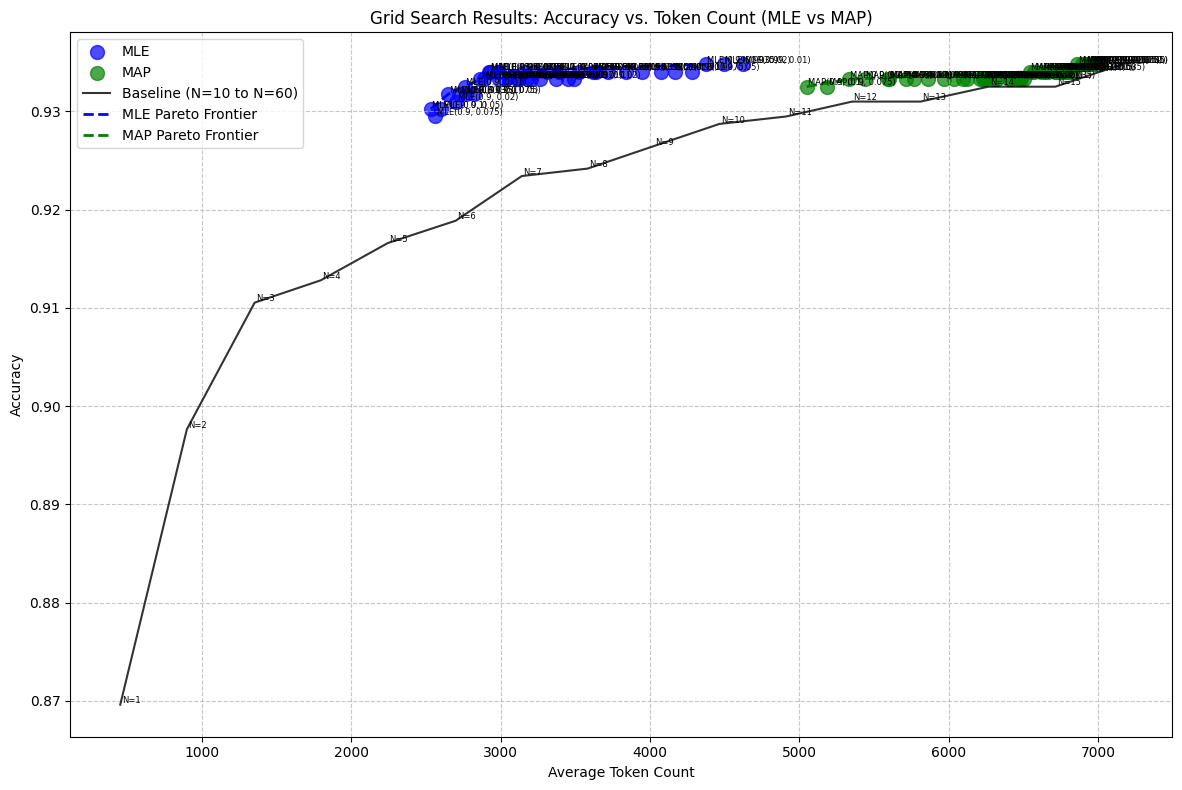


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9303, Avg Token Count: 2532.96
Target Score: 0.9, Percentile: 0.035, Accuracy: 0.9318, Avg Token Count: 2649.89
Target Score: 0.9, Percentile: 0.01, Accuracy: 0.9325, Avg Token Count: 2762.02
Target Score: 0.93, Percentile: 0.035, Accuracy: 0.9333, Avg Token Count: 2863.31
Target Score: 0.93, Percentile: 0.02, Accuracy: 0.9340, Avg Token Count: 2923.54
Target Score: 0.99, Percentile: 0.035, Accuracy: 0.9348, Avg Token Count: 4372.34

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9325, Avg Token Count: 5049.03
Target Score: 0.9, Percentile: 0.05, Accuracy: 0.9333, Avg Token Count: 5329.49
Target Score: 0.97, Percentile: 0.075, Accuracy: 0.9340, Avg Token Count: 6542.36
Target Score: 0.98, Percentile: 0.02, Accuracy: 0.9348, Avg Token Count: 6859.55


In [9]:
max_N_panel = 16
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [10]:
peek_number = 10

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916    0.9933    0.0060    0.7771    0.1789   21.7699    0.5656
1         0.3712      0.0375    0.9975    0.0045    0.6992    0.2443    1.0031    0.0092
2         0.6217      0.1013    1.2453    0.2955    0.8229    0.1543    0.9576    0.1450
3         0.4076      0.0870    7.1400    1.3295    0.6456    0.2505   48.1585    4.1681
4         0.4718      0.1396   99.6493    3.1141    0.8523    0.1651   88.3479    3.3720
5         0.5645      0.0934    0.9939    0.0024    0.9847    0.0122    1.3527    0.1195
6         0.4193      0.0764    0.9978    0.0014    0.8068    0.2101    0.9976    0.0011
7         0.4935      0.1110    1.8778    0.3923    0.8247    0.1470    1.3589    0.2502
8         0.4501      0.1188    0.8907    0.1204    0.8192    0.1098    1.1546    0.2116
9         0.4603      0.1372    6.0605    0.1622    1.0093    0.0105    9.0876    0.2182
10        0.3858      0.0913    0.9914    0.0036    1.0216    0.0255    0.9982    0.0105
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 32

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [10, 10, 10, 13, 10, 10, 10, 10, 11, 10, 10, 11, 10, 10, 10, 10, 10, 32, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 17, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 4977.69
MLE Min N Required [10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 14, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9340, Average Token Count: 4914.80
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9348, Average Token Count: 4855.44
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9348, Average Token Count: 4821.87
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9348, Average Token Count: 4783.19
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

Target Score (MLE):  14%|█▍        | 1/7 [01:54<11:27, 114.57s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9348, Average Token Count: 4756.91


MLE Min N Required [10, 10, 14, 18, 10, 10, 10, 10, 18, 10, 10, 16, 10, 10, 10, 10, 10, 32, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 29, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9348, Average Token Count: 5272.40
MLE Min N Required [10, 10, 12, 15, 10, 10, 10, 10, 15, 10, 10, 14, 10, 10, 10, 10, 10, 32, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 25, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9348, Average Token Count: 5183.70
MLE Min N Required [10, 10, 10, 13, 10, 10, 10, 10, 13, 10, 10, 12, 10, 10, 10, 10, 10, 32, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 21, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9348, Average Token Count: 5090.78
MLE Min N Required [10, 10, 10, 12, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 19, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9348, Average Token Count: 5042.78
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9333, Average Token Count: 4982.57
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  29%|██▊       | 2/7 [03:50<09:37, 115.46s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9333, Average Token Count: 4941.64


MLE Min N Required [10, 10, 19, 25, 10, 10, 10, 14, 27, 10, 10, 23, 11, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 13, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 15, 10, 12, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 5562.43
MLE Min N Required [10, 10, 16, 22, 10, 10, 10, 12, 23, 10, 10, 20, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 12, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 11, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9348, Average Token Count: 5466.54
MLE Min N Required [10, 10, 14, 19, 10, 10, 10, 10, 20, 10, 10, 17, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9348, Average Token Count: 5376.00
MLE Min N Required [10, 10, 13, 17, 10, 10, 10, 10, 18, 10, 10, 15, 10, 10, 10, 10, 10, 32, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 31, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9348, Average Token Count: 5311.77
MLE Min N Required [10, 10, 11, 14, 10, 10, 10, 10, 16, 10, 10, 13, 10, 10, 10, 10, 10, 32, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 27, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9348, Average Token Count: 5244.49
MLE Min N Required [10, 10, 10, 13, 10, 10, 10, 10, 14, 10, 10, 12, 10, 10, 10, 10, 10, 32, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 24, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  43%|████▎     | 3/7 [05:48<07:46, 116.62s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9348, Average Token Count: 5182.97


MLE Min N Required [10, 10, 24, 31, 12, 10, 10, 18, 32, 10, 10, 29, 14, 10, 10, 10, 10, 32, 10, 10, 12, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 32, 10, 10, 10, 10, 10, 25, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 12, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 17, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 19, 10, 16, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 12, 18, 10, 10, 10, 16, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 5744.94
MLE Min N Required [10, 10, 21, 27, 10, 10, 10, 15, 30, 10, 10, 25, 12, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 10, 28, 14, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 16, 10, 14, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 13, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 5630.44
MLE Min N Required [10, 10, 18, 23, 10, 10, 10, 13, 26, 10, 10, 21, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 12, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 14, 10, 12, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9340, Average Token Count: 5529.80
MLE Min N Required [10, 10, 16, 21, 10, 10, 10, 12, 23, 10, 10, 19, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 11, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9348, Average Token Count: 5473.04
MLE Min N Required [10, 10, 14, 18, 10, 10, 10, 10, 20, 10, 10, 17, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 31, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9348, Average Token Count: 5394.82
MLE Min N Required [10, 10, 12, 16, 10, 10, 10, 10, 18, 10, 10, 15, 10, 10, 10, 10, 10, 32, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  57%|█████▋    | 4/7 [07:48<05:54, 118.07s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9348, Average Token Count: 5329.12


MLE Min N Required [10, 10, 32, 32, 16, 10, 10, 23, 32, 10, 10, 32, 19, 10, 10, 10, 10, 32, 10, 10, 16, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 16, 32, 10, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 15, 10, 14, 10, 32, 10, 10, 13, 14, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 32, 22, 32, 10, 10, 32, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 32, 25, 10, 22, 10, 10, 20, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 12, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 15, 24, 10, 10, 10, 21, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 14, 32, 10, 10, 10, 10, 11, 10, 10, 12, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 6037.75
MLE Min N Required [10, 10, 27, 32, 13, 10, 10, 20, 32, 10, 10, 32, 16, 10, 10, 10, 10, 32, 10, 10, 14, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 14, 32, 10, 10, 10, 10, 10, 29, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 13, 10, 12, 10, 32, 10, 10, 11, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 32, 19, 32, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 22, 10, 19, 10, 10, 17, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 13, 21, 10, 10, 10, 18, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 5880.94
MLE Min N Required [10, 10, 24, 31, 11, 10, 10, 17, 32, 10, 10, 29, 14, 10, 10, 10, 10, 32, 10, 10, 12, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 12, 32, 10, 10, 10, 10, 10, 25, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 11, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 16, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 19, 10, 16, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 11, 18, 10, 10, 10, 15, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9340, Average Token Count: 5752.40
MLE Min N Required [10, 10, 21, 27, 10, 10, 10, 15, 32, 10, 10, 26, 12, 10, 10, 10, 10, 32, 10, 10, 11, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 11, 32, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 10, 10, 10, 29, 15, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 17, 10, 15, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 14, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 5674.96
MLE Min N Required [10, 10, 18, 24, 10, 10, 10, 13, 28, 10, 10, 23, 11, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 13, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 15, 10, 13, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9333, Average Token Count: 5584.96
MLE Min N Required [10, 10, 16, 21, 10, 10, 10, 12, 25, 10, 10, 20, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 11, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  71%|███████▏  | 5/7 [09:50<03:58, 119.45s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9333, Average Token Count: 5514.18


MLE Min N Required [10, 10, 32, 32, 23, 10, 10, 32, 32, 10, 10, 32, 28, 10, 10, 10, 10, 32, 10, 10, 24, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 24, 32, 10, 10, 10, 10, 11, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 23, 10, 21, 14, 32, 10, 10, 19, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 15, 10, 10, 10, 24, 10, 10, 10, 32, 32, 32, 12, 15, 32, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 11, 15, 13, 16, 10, 10, 32, 32, 10, 32, 10, 11, 30, 10, 13, 10, 20, 10, 10, 14, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 14, 10, 10, 17, 32, 10, 10, 10, 10, 32, 10, 10, 32, 13, 12, 13, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 20, 10, 19, 10, 10, 11, 10, 10, 10, 10, 10, 13, 10, 10, 23, 10, 10, 23, 32, 10, 10, 10, 31, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 32, 20, 32, 10, 10, 10, 10, 16, 10, 10, 18, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 6621.57
MLE Min N Required [10, 10, 32, 32, 20, 10, 10, 30, 32, 10, 10, 32, 24, 10, 10, 10, 10, 32, 10, 10, 20, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 20, 32, 10, 10, 10, 10, 10, 32, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 20, 10, 18, 12, 32, 10, 10, 16, 28, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 21, 10, 10, 10, 32, 28, 32, 10, 13, 32, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 13, 11, 13, 10, 10, 32, 32, 10, 29, 10, 10, 26, 10, 11, 10, 17, 10, 10, 12, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 12, 10, 10, 15, 32, 10, 10, 10, 10, 32, 10, 10, 32, 11, 10, 11, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 17, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 19, 10, 10, 19, 31, 10, 10, 10, 26, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9340, Average Token Count: 6397.12
MLE Min N Required [10, 10, 32, 32, 17, 10, 10, 26, 32, 10, 10, 32, 20, 10, 10, 10, 10, 32, 10, 10, 17, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 17, 32, 10, 10, 10, 10, 10, 32, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 17, 10, 16, 10, 32, 10, 10, 14, 24, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 11, 10, 10, 10, 18, 10, 10, 10, 32, 24, 32, 10, 11, 32, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 11, 10, 12, 10, 10, 32, 28, 10, 25, 10, 10, 22, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 13, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 15, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 17, 26, 10, 10, 10, 23, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9348, Average Token Count: 6190.45
MLE Min N Required [10, 10, 32, 32, 15, 10, 10, 23, 32, 10, 10, 32, 18, 10, 10, 10, 10, 32, 10, 10, 16, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 16, 32, 10, 10, 10, 10, 10, 32, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 15, 10, 14, 10, 32, 10, 10, 12, 22, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 32, 22, 32, 10, 10, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 25, 10, 22, 10, 10, 20, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 11, 32, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 13, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 15, 24, 10, 10, 10, 20, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9340, Average Token Count: 6061.74
MLE Min N Required [10, 10, 27, 32, 13, 10, 10, 20, 32, 10, 10, 32, 16, 10, 10, 10, 10, 32, 10, 10, 14, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 14, 32, 10, 10, 10, 10, 10, 29, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 13, 10, 12, 10, 32, 10, 10, 11, 19, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 32, 19, 32, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 22, 10, 19, 10, 10, 17, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 13, 20, 10, 10, 10, 18, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 5917.93
MLE Min N Required [10, 10, 24, 32, 12, 10, 10, 18, 32, 10, 10, 31, 14, 10, 10, 10, 10, 32, 10, 10, 12, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 12, 32, 10, 10, 10, 10, 10, 26, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 12, 10, 11, 10, 32, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 17, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 19, 10, 17, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 12, 18, 10, 10, 10, 16, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  86%|████████▌ | 6/7 [11:57<02:01, 121.97s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9333, Average Token Count: 5815.96


MLE Min N Required [10, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 12, 10, 32, 10, 20, 32, 32, 10, 10, 10, 10, 19, 10, 16, 10, 10, 10, 10, 10, 10, 32, 32, 32, 10, 13, 10, 17, 21, 32, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 10, 32, 10, 32, 28, 32, 10, 11, 32, 32, 12, 10, 10, 13, 10, 11, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 13, 10, 10, 14, 32, 10, 29, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 24, 29, 32, 10, 15, 10, 11, 32, 10, 10, 10, 10, 10, 21, 30, 25, 31, 10, 10, 32, 32, 10, 32, 13, 22, 32, 10, 26, 10, 32, 10, 10, 28, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 16, 10, 21, 20, 32, 10, 10, 32, 10, 10, 32, 32, 10, 10, 20, 10, 32, 10, 11, 32, 26, 23, 26, 10, 10, 10, 10, 10, 22, 32, 10, 22, 11, 10, 17, 10, 10, 10, 10, 17, 15, 18, 10, 32, 32, 10, 32, 10, 10, 21, 12, 10, 10, 10, 10, 25, 10, 10, 32, 17, 19, 32, 32, 10, 10, 10, 32, 10, 10, 10, 11, 32, 10, 10, 10, 16, 12, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 20, 10, 32, 32, 32, 10, 10, 10, 17, 31, 19, 10, 32, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9340, Average Token Count: 7913.64
MLE Min N Required [10, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 10, 10, 32, 10, 17, 32, 32, 10, 10, 10, 10, 16, 10, 14, 10, 10, 10, 10, 10, 10, 32, 32, 32, 10, 11, 10, 14, 18, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 32, 24, 32, 10, 10, 31, 32, 10, 10, 10, 11, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 12, 32, 10, 24, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 20, 25, 32, 10, 13, 10, 10, 31, 10, 10, 10, 10, 10, 18, 26, 22, 26, 10, 10, 32, 32, 10, 32, 11, 19, 32, 10, 22, 10, 32, 10, 10, 23, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 13, 10, 18, 17, 32, 10, 10, 30, 10, 10, 29, 32, 10, 10, 17, 10, 32, 10, 10, 32, 22, 20, 23, 10, 10, 10, 10, 10, 19, 32, 10, 19, 10, 10, 14, 10, 10, 10, 10, 14, 13, 15, 10, 32, 32, 10, 32, 10, 10, 18, 10, 10, 10, 10, 10, 22, 10, 10, 32, 15, 16, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 14, 10, 10, 

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9333, Average Token Count: 7611.33
MLE Min N Required [10, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 10, 10, 32, 10, 15, 32, 32, 10, 10, 10, 10, 14, 10, 12, 10, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 12, 16, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 31, 21, 32, 10, 10, 27, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 21, 10, 10, 10, 32, 10, 10, 10, 32, 32, 32, 17, 21, 32, 10, 11, 10, 10, 27, 10, 10, 10, 10, 10, 15, 22, 19, 23, 10, 10, 32, 32, 10, 32, 10, 16, 32, 10, 19, 10, 28, 10, 10, 20, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 12, 10, 15, 14, 32, 10, 10, 25, 10, 10, 25, 32, 10, 10, 14, 10, 32, 10, 10, 32, 19, 17, 19, 10, 10, 10, 10, 10, 16, 32, 10, 16, 10, 10, 12, 10, 10, 10, 10, 12, 11, 13, 10, 32, 30, 10, 28, 10, 10, 15, 10, 10, 10, 10, 10, 19, 10, 10, 32, 13, 14, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 12, 10, 10, 

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9333, Average Token Count: 7328.24
MLE Min N Required [10, 10, 32, 32, 30, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 10, 10, 32, 10, 13, 31, 32, 10, 10, 10, 10, 13, 10, 11, 10, 10, 10, 10, 10, 10, 32, 31, 32, 10, 10, 10, 11, 14, 32, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 30, 10, 28, 18, 32, 10, 10, 24, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 19, 10, 10, 10, 31, 10, 10, 10, 32, 32, 32, 16, 19, 32, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 14, 20, 17, 20, 10, 10, 32, 32, 10, 32, 10, 15, 32, 10, 17, 10, 25, 10, 10, 18, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 14, 13, 32, 10, 10, 23, 10, 10, 22, 32, 10, 10, 13, 10, 32, 10, 10, 32, 17, 15, 17, 10, 10, 10, 10, 10, 14, 32, 10, 14, 10, 10, 11, 10, 10, 10, 10, 11, 10, 12, 10, 32, 27, 10, 25, 10, 10, 14, 10, 10, 10, 10, 10, 17, 10, 10, 29, 11, 12, 30, 32, 10, 10, 10, 32, 10, 10, 10, 10, 31, 10, 10, 10, 11, 10, 10,

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9333, Average Token Count: 7137.45
MLE Min N Required [10, 10, 32, 32, 26, 10, 10, 32, 32, 10, 10, 32, 31, 10, 10, 10, 10, 32, 10, 12, 27, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 32, 27, 32, 10, 10, 10, 10, 12, 32, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 26, 10, 24, 16, 32, 10, 10, 21, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 16, 10, 10, 10, 27, 10, 10, 10, 32, 32, 32, 14, 17, 32, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 12, 17, 15, 18, 10, 10, 32, 32, 10, 32, 10, 13, 32, 10, 15, 10, 22, 10, 10, 16, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 12, 11, 32, 10, 10, 20, 10, 10, 19, 32, 10, 10, 11, 10, 32, 10, 10, 32, 15, 13, 15, 10, 10, 10, 10, 10, 12, 32, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 23, 10, 22, 10, 10, 12, 10, 10, 10, 10, 10, 14, 10, 10, 25, 10, 11, 26, 32, 10, 10, 10, 32, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9340, Average Token Count: 6901.20
MLE Min N Required [10, 10, 32, 32, 23, 10, 10, 32, 32, 10, 10, 32, 28, 10, 10, 10, 10, 32, 10, 10, 24, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 24, 32, 10, 10, 10, 10, 11, 32, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 23, 10, 22, 14, 32, 10, 10, 19, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 15, 10, 10, 10, 24, 10, 10, 10, 32, 32, 32, 12, 15, 32, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 11, 15, 13, 16, 10, 10, 32, 32, 10, 32, 10, 11, 31, 10, 13, 10, 20, 10, 10, 14, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 11, 10, 32, 10, 10, 18, 10, 10, 17, 32, 10, 10, 10, 10, 32, 10, 10, 32, 13, 12, 13, 10, 10, 10, 10, 10, 11, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 21, 10, 19, 10, 10, 11, 10, 10, 10, 10, 10, 13, 10, 10, 23, 10, 10, 23, 32, 10, 10, 10, 31, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10,

Target Score (MLE): 100%|██████████| 7/7 [14:13<00:00, 121.88s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9340, Average Token Count: 6713.03

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [28, 32, 20, 32, 17, 10, 23, 20, 22, 10, 10, 30, 32, 10, 10, 17, 24, 32, 10, 32, 15, 32, 13, 10, 10, 10, 10, 18, 25, 10, 32, 10, 20, 10, 10, 10, 23, 32, 12, 10, 10, 10, 28, 32, 11, 10, 10, 10, 21, 10, 23, 10, 10, 32, 23, 10, 10, 10, 32, 32, 13, 10, 32, 10, 22, 14, 32, 10, 32, 11, 32, 32, 31, 10, 23, 32, 21, 23, 26, 32, 29, 10, 10, 26, 14, 10, 10, 32, 10, 23, 11, 32, 10, 29, 10, 32, 10, 32, 23, 32, 29, 26, 32, 10, 32, 10, 10, 29, 32, 24, 29, 23, 14, 32, 26, 28, 32, 11, 17, 32, 31, 10, 32, 31, 10, 22, 10, 18, 10, 11, 28, 10, 12, 27, 10, 24, 16, 32, 32, 25, 15, 10, 10, 23, 32, 32, 32, 32, 10, 10, 26, 10, 32, 32, 28, 32, 32, 30, 18, 32, 10, 30, 32, 10, 32, 13, 11, 10, 25, 10, 10, 10, 23, 28, 17, 18, 29, 10, 10, 32, 32, 27, 13, 27, 15, 20, 32, 30, 10, 32, 32, 10, 28, 10, 30, 10, 16, 27, 10, 11, 12, 11, 15, 26, 27, 19, 10, 32, 10, 24, 26, 30, 32, 10, 20, 25, 15, 32, 32, 23, 32, 10, 30, 10, 14, 18, 10, 30, 11, 32, 10, 12, 32, 32, 32, 17, 31, 21, 32, 27, 10, 28, 30, 10, 30, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9325, Average Token Count: 9480.70
MAP Min N Required [24, 32, 17, 32, 14, 10, 20, 17, 19, 10, 10, 26, 32, 10, 10, 15, 21, 32, 10, 28, 13, 32, 11, 10, 10, 10, 10, 16, 21, 10, 30, 10, 17, 10, 10, 10, 20, 32, 10, 10, 10, 10, 24, 32, 10, 10, 10, 10, 18, 10, 20, 10, 10, 32, 20, 10, 10, 10, 32, 32, 11, 10, 32, 10, 19, 12, 28, 10, 32, 10, 28, 29, 26, 10, 20, 32, 18, 20, 22, 32, 25, 10, 10, 22, 12, 10, 10, 32, 10, 20, 10, 32, 10, 24, 10, 32, 10, 32, 20, 28, 25, 22, 32, 10, 29, 10, 10, 25, 32, 21, 25, 20, 12, 32, 22, 24, 32, 10, 15, 32, 26, 10, 32, 26, 10, 19, 10, 15, 10, 10, 24, 10, 11, 23, 10, 20, 13, 27, 32, 21, 13, 10, 10, 19, 32, 32, 27, 32, 10, 10, 22, 10, 32, 31, 24, 32, 30, 25, 15, 32, 10, 26, 32, 10, 32, 11, 10, 10, 22, 10, 10, 10, 20, 24, 14, 15, 25, 10, 10, 30, 32, 23, 12, 23, 13, 17, 32, 25, 10, 32, 32, 10, 24, 10, 25, 10, 14, 23, 10, 10, 11, 10, 13, 22, 23, 17, 10, 30, 10, 20, 22, 26, 29, 10, 17, 22, 13, 32, 32, 20, 30, 1

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9318, Average Token Count: 8737.09
MAP Min N Required [20, 30, 15, 32, 12, 10, 17, 15, 16, 10, 10, 22, 32, 10, 10, 13, 18, 32, 10, 24, 11, 32, 10, 10, 10, 10, 10, 14, 18, 10, 26, 10, 15, 10, 10, 10, 17, 32, 10, 10, 10, 10, 20, 29, 10, 10, 10, 10, 15, 10, 17, 10, 10, 29, 17, 10, 10, 10, 27, 32, 10, 10, 32, 10, 16, 10, 24, 10, 30, 10, 24, 25, 23, 10, 17, 32, 16, 17, 19, 30, 21, 10, 10, 19, 11, 10, 10, 32, 10, 17, 10, 32, 10, 21, 10, 27, 10, 32, 17, 24, 22, 19, 32, 10, 25, 10, 10, 21, 31, 18, 21, 17, 10, 32, 19, 20, 32, 10, 13, 28, 23, 10, 32, 23, 10, 16, 10, 13, 10, 10, 21, 10, 10, 20, 10, 18, 12, 23, 28, 18, 11, 10, 10, 17, 28, 32, 24, 32, 10, 10, 19, 10, 29, 27, 20, 32, 26, 22, 13, 32, 10, 22, 32, 10, 32, 10, 10, 10, 19, 10, 10, 10, 17, 21, 12, 13, 21, 10, 10, 26, 32, 20, 10, 20, 11, 14, 32, 22, 10, 32, 32, 10, 20, 10, 22, 10, 12, 20, 10, 10, 10, 10, 11, 19, 20, 14, 10, 26, 10, 17, 19, 22, 25, 10, 15, 19, 11, 28, 30, 17, 26, 1

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9325, Average Token Count: 7979.46
MAP Min N Required [18, 27, 13, 32, 11, 10, 15, 13, 15, 10, 10, 20, 30, 10, 10, 12, 16, 32, 10, 21, 10, 32, 10, 10, 10, 10, 10, 12, 17, 10, 23, 10, 13, 10, 10, 10, 15, 32, 10, 10, 10, 10, 18, 26, 10, 10, 10, 10, 14, 10, 15, 10, 10, 26, 15, 10, 10, 10, 24, 30, 10, 10, 32, 10, 14, 10, 22, 10, 27, 10, 21, 22, 20, 10, 15, 32, 14, 15, 17, 27, 19, 10, 10, 17, 10, 10, 10, 32, 10, 15, 10, 31, 10, 19, 10, 24, 10, 32, 15, 22, 19, 17, 32, 10, 23, 10, 10, 19, 28, 16, 19, 15, 10, 31, 17, 18, 31, 10, 11, 25, 20, 10, 32, 20, 10, 15, 10, 12, 10, 10, 18, 10, 10, 18, 10, 16, 10, 21, 25, 16, 10, 10, 10, 15, 25, 32, 21, 32, 10, 10, 17, 10, 26, 24, 18, 31, 23, 20, 12, 32, 10, 20, 30, 10, 29, 10, 10, 10, 17, 10, 10, 10, 15, 19, 11, 12, 19, 10, 10, 23, 32, 18, 10, 18, 10, 13, 32, 20, 10, 32, 29, 10, 18, 10, 20, 10, 11, 18, 10, 10, 10, 10, 10, 17, 18, 13, 10, 23, 10, 15, 17, 20, 22, 10, 13, 17, 10, 25, 27, 15, 23, 

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 7432.65
MAP Min N Required [16, 23, 12, 30, 10, 10, 13, 11, 13, 10, 10, 17, 26, 10, 10, 10, 14, 32, 10, 18, 10, 27, 10, 10, 10, 10, 10, 11, 14, 10, 20, 10, 11, 10, 10, 10, 13, 32, 10, 10, 10, 10, 16, 23, 10, 10, 10, 10, 12, 10, 13, 10, 10, 23, 13, 10, 10, 10, 21, 26, 10, 10, 32, 10, 13, 10, 19, 10, 23, 10, 19, 19, 18, 10, 13, 32, 12, 13, 15, 24, 17, 10, 10, 15, 10, 10, 10, 32, 10, 13, 10, 27, 10, 16, 10, 21, 10, 32, 13, 19, 17, 15, 32, 10, 20, 10, 10, 17, 24, 14, 16, 13, 10, 27, 15, 16, 27, 10, 10, 22, 18, 10, 31, 18, 10, 13, 10, 10, 10, 10, 16, 10, 10, 16, 10, 14, 10, 18, 22, 14, 10, 10, 10, 13, 22, 28, 18, 32, 10, 10, 15, 10, 23, 21, 16, 27, 20, 17, 10, 32, 10, 17, 26, 10, 25, 10, 10, 10, 15, 10, 10, 10, 13, 16, 10, 10, 17, 10, 10, 20, 29, 16, 10, 15, 10, 11, 32, 17, 10, 28, 25, 10, 16, 10, 17, 10, 10, 15, 10, 10, 10, 10, 10, 15, 15, 11, 10, 20, 10, 13, 15, 17, 19, 10, 11, 14, 10, 22, 23, 13, 20, 1

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9333, Average Token Count: 6792.51
MAP Min N Required [14, 21, 10, 27, 10, 10, 12, 10, 11, 10, 10, 15, 23, 10, 10, 10, 12, 32, 10, 16, 10, 24, 10, 10, 10, 10, 10, 10, 13, 10, 18, 10, 10, 10, 10, 10, 12, 32, 10, 10, 10, 10, 14, 20, 10, 10, 10, 10, 11, 10, 12, 10, 10, 20, 12, 10, 10, 10, 19, 23, 10, 10, 32, 10, 11, 10, 17, 10, 21, 10, 17, 17, 16, 10, 12, 32, 11, 12, 13, 21, 15, 10, 10, 13, 10, 10, 10, 32, 10, 12, 10, 24, 10, 15, 10, 19, 10, 32, 12, 17, 15, 13, 32, 10, 18, 10, 10, 15, 22, 12, 15, 12, 10, 24, 13, 14, 24, 10, 10, 19, 16, 10, 28, 16, 10, 11, 10, 10, 10, 10, 14, 10, 10, 14, 10, 12, 10, 16, 19, 13, 10, 10, 10, 12, 20, 25, 16, 32, 10, 10, 13, 10, 20, 18, 14, 24, 18, 15, 10, 32, 10, 15, 23, 10, 22, 10, 10, 10, 13, 10, 10, 10, 12, 14, 10, 10, 15, 10, 10, 18, 25, 14, 10, 14, 10, 10, 32, 15, 10, 25, 23, 10, 14, 10, 15, 10, 10, 14, 10, 10, 10, 10, 10, 13, 14, 10, 10, 18, 10, 12, 13, 15, 17, 10, 10, 13, 10, 20, 21, 12, 18, 

Target Score (MAP):  14%|█▍        | 1/7 [02:25<14:30, 145.07s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9348, Average Token Count: 6336.65


MAP Min N Required [32, 32, 32, 32, 26, 10, 32, 32, 32, 10, 10, 32, 32, 12, 10, 27, 32, 32, 10, 32, 23, 32, 21, 10, 10, 10, 11, 31, 32, 10, 32, 10, 32, 10, 17, 15, 32, 32, 18, 10, 10, 10, 32, 32, 19, 10, 15, 10, 32, 18, 32, 13, 10, 32, 32, 10, 10, 19, 32, 32, 23, 10, 32, 10, 32, 22, 32, 10, 32, 20, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 15, 32, 22, 10, 13, 32, 10, 32, 19, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 20, 27, 32, 32, 10, 32, 32, 16, 32, 10, 28, 10, 18, 32, 11, 20, 32, 10, 32, 26, 32, 32, 32, 24, 10, 11, 32, 32, 32, 32, 32, 10, 18, 32, 10, 32, 32, 32, 32, 32, 32, 28, 32, 12, 32, 32, 13, 32, 22, 19, 10, 32, 12, 10, 10, 32, 32, 29, 29, 32, 10, 10, 32, 32, 32, 21, 32, 23, 30, 32, 32, 10, 32, 32, 10, 32, 10, 32, 10, 25, 32, 18, 17, 19, 18, 24, 32, 32, 31, 10, 32, 10, 32, 32, 32, 32, 12, 31, 32, 25, 32, 32, 32, 32, 10, 32, 10, 24, 28, 10, 32, 17, 32, 10, 19, 32, 32, 32, 27, 32, 32, 32, 32, 17, 32, 32, 10, 32, 

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9325, Average Token Count: 10915.99
MAP Min N Required [32, 32, 27, 32, 22, 10, 31, 27, 32, 10, 10, 32, 32, 10, 10, 23, 32, 32, 10, 32, 20, 32, 18, 10, 10, 10, 10, 26, 32, 10, 32, 10, 28, 10, 15, 13, 31, 32, 15, 10, 10, 10, 32, 32, 16, 10, 13, 10, 29, 16, 31, 11, 10, 32, 32, 10, 10, 16, 32, 32, 19, 10, 32, 10, 30, 19, 32, 10, 32, 17, 32, 32, 32, 10, 31, 32, 29, 31, 32, 32, 32, 10, 13, 32, 18, 10, 11, 32, 10, 31, 17, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 31, 32, 32, 20, 32, 32, 32, 32, 17, 23, 32, 32, 10, 32, 32, 13, 29, 10, 24, 10, 15, 32, 10, 17, 32, 10, 32, 22, 32, 32, 32, 21, 10, 10, 31, 32, 32, 32, 32, 10, 15, 32, 10, 32, 32, 32, 32, 32, 32, 24, 32, 10, 32, 32, 11, 32, 19, 16, 10, 32, 10, 10, 10, 32, 32, 25, 25, 32, 10, 10, 32, 32, 32, 18, 32, 20, 26, 32, 32, 10, 32, 32, 10, 32, 10, 32, 10, 21, 32, 15, 15, 17, 15, 21, 32, 32, 26, 10, 32, 10, 32, 32, 32, 32, 10, 26, 32, 22, 32, 32, 32, 32,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 10581.39
MAP Min N Required [32, 32, 24, 32, 19, 10, 26, 23, 29, 10, 10, 32, 32, 10, 10, 20, 27, 32, 10, 32, 17, 32, 15, 10, 10, 10, 10, 23, 30, 10, 32, 10, 24, 10, 13, 11, 27, 32, 13, 10, 10, 10, 32, 32, 14, 10, 11, 10, 25, 13, 26, 10, 10, 32, 30, 10, 10, 14, 32, 32, 17, 10, 32, 10, 26, 16, 32, 10, 32, 14, 32, 32, 32, 10, 26, 32, 25, 26, 32, 32, 32, 10, 11, 30, 16, 10, 10, 32, 10, 27, 14, 32, 10, 32, 10, 32, 10, 32, 28, 32, 32, 31, 32, 10, 32, 10, 10, 32, 32, 27, 31, 27, 17, 32, 32, 32, 32, 15, 20, 32, 32, 10, 32, 32, 11, 25, 10, 21, 10, 13, 31, 10, 14, 32, 10, 28, 19, 32, 32, 30, 18, 10, 10, 27, 32, 32, 32, 32, 10, 13, 29, 10, 32, 32, 32, 32, 32, 32, 21, 32, 10, 32, 32, 10, 32, 16, 14, 10, 28, 10, 10, 10, 29, 32, 21, 21, 32, 10, 10, 32, 32, 31, 16, 30, 17, 22, 32, 32, 10, 32, 32, 10, 31, 10, 32, 10, 18, 31, 13, 13, 14, 13, 18, 29, 32, 22, 10, 32, 10, 28, 30, 32, 32, 10, 22, 28, 19, 32, 32, 27, 32,

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 10132.06
MAP Min N Required [29, 32, 21, 32, 17, 10, 24, 21, 26, 10, 10, 32, 32, 10, 10, 18, 25, 32, 10, 32, 15, 32, 14, 10, 10, 10, 10, 20, 27, 10, 32, 10, 21, 10, 11, 10, 24, 32, 12, 10, 10, 10, 29, 32, 13, 10, 10, 10, 22, 12, 24, 10, 10, 32, 27, 10, 10, 12, 32, 32, 15, 10, 32, 10, 23, 14, 32, 10, 32, 13, 32, 32, 32, 10, 24, 32, 22, 24, 32, 32, 29, 10, 10, 27, 14, 10, 10, 32, 10, 24, 13, 32, 10, 29, 10, 32, 10, 32, 25, 32, 30, 28, 32, 10, 32, 10, 10, 30, 32, 24, 28, 25, 16, 32, 29, 28, 32, 13, 18, 32, 31, 10, 32, 32, 10, 23, 10, 19, 10, 12, 27, 10, 13, 29, 10, 25, 17, 32, 32, 27, 16, 10, 10, 24, 32, 32, 32, 32, 10, 12, 26, 10, 32, 32, 30, 32, 32, 30, 18, 32, 10, 30, 32, 10, 32, 15, 13, 10, 25, 10, 10, 10, 26, 28, 19, 19, 29, 10, 10, 32, 32, 27, 14, 27, 15, 20, 32, 30, 10, 32, 32, 10, 27, 10, 30, 10, 16, 27, 12, 12, 13, 12, 16, 26, 29, 20, 10, 32, 10, 25, 27, 31, 32, 10, 20, 26, 17, 32, 32, 25, 32

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 9697.57
MAP Min N Required [25, 32, 18, 32, 15, 10, 20, 18, 22, 10, 10, 29, 32, 10, 10, 16, 21, 32, 10, 28, 13, 32, 12, 10, 10, 10, 10, 18, 23, 10, 31, 10, 19, 10, 10, 10, 21, 32, 10, 10, 10, 10, 25, 32, 11, 10, 10, 10, 19, 10, 20, 10, 10, 32, 24, 10, 10, 11, 32, 32, 13, 10, 32, 10, 20, 13, 29, 10, 32, 11, 29, 29, 28, 10, 20, 32, 20, 20, 30, 32, 25, 10, 10, 23, 12, 10, 10, 32, 10, 21, 11, 32, 10, 26, 10, 32, 10, 32, 21, 32, 26, 24, 32, 10, 30, 10, 10, 26, 32, 21, 24, 21, 14, 32, 25, 25, 32, 12, 15, 32, 27, 10, 32, 28, 10, 20, 10, 16, 10, 10, 24, 10, 11, 25, 10, 22, 15, 28, 32, 23, 14, 10, 10, 21, 32, 32, 27, 32, 10, 10, 23, 10, 32, 32, 26, 32, 30, 26, 16, 32, 10, 26, 32, 10, 32, 13, 11, 10, 22, 10, 10, 10, 23, 25, 17, 17, 25, 10, 10, 31, 32, 24, 12, 23, 13, 17, 32, 26, 10, 32, 32, 10, 24, 10, 26, 10, 14, 24, 10, 10, 11, 10, 14, 23, 25, 17, 10, 30, 10, 22, 23, 27, 29, 10, 17, 22, 15, 32, 32, 21, 31, 

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9325, Average Token Count: 9022.48
MAP Min N Required [22, 32, 16, 32, 13, 10, 18, 16, 20, 10, 10, 26, 32, 10, 10, 14, 19, 32, 10, 25, 12, 32, 11, 10, 10, 10, 10, 16, 21, 10, 27, 10, 17, 10, 10, 10, 19, 32, 10, 10, 10, 10, 22, 32, 10, 10, 10, 10, 17, 10, 18, 10, 10, 31, 21, 10, 10, 10, 31, 32, 12, 10, 32, 10, 18, 11, 26, 10, 32, 10, 26, 26, 25, 10, 18, 32, 17, 18, 26, 32, 22, 10, 10, 21, 11, 10, 10, 32, 10, 19, 10, 32, 10, 23, 10, 28, 10, 32, 19, 31, 23, 22, 32, 10, 26, 10, 10, 23, 32, 19, 22, 19, 12, 32, 22, 22, 32, 10, 14, 32, 24, 10, 32, 25, 10, 18, 10, 14, 10, 10, 21, 10, 10, 22, 10, 19, 13, 25, 30, 21, 12, 10, 10, 19, 30, 32, 24, 32, 10, 10, 20, 10, 31, 29, 23, 32, 27, 23, 14, 32, 10, 23, 32, 10, 32, 11, 10, 10, 20, 10, 10, 10, 20, 22, 15, 15, 23, 10, 10, 27, 32, 21, 11, 21, 12, 15, 32, 23, 10, 32, 32, 10, 21, 10, 23, 10, 13, 21, 10, 10, 10, 10, 12, 20, 23, 16, 10, 27, 10, 19, 21, 24, 26, 10, 16, 20, 13, 30, 32, 19, 28,

Target Score (MAP):  29%|██▊       | 2/7 [05:03<12:45, 153.20s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9325, Average Token Count: 8441.10


MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 18, 10, 32, 32, 32, 11, 32, 32, 32, 31, 10, 10, 10, 16, 32, 32, 10, 32, 10, 32, 10, 28, 31, 32, 32, 26, 11, 10, 10, 32, 32, 32, 12, 23, 10, 32, 30, 32, 19, 10, 32, 32, 10, 10, 31, 32, 32, 32, 15, 32, 10, 32, 32, 32, 12, 32, 31, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 14, 22, 32, 31, 10, 23, 32, 10, 32, 31, 32, 10, 32, 14, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 26, 32, 17, 32, 10, 27, 32, 16, 29, 32, 10, 32, 32, 32, 32, 32, 32, 12, 16, 32, 32, 32, 32, 32, 10, 29, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 20, 32, 32, 31, 14, 32, 18, 10, 10, 32, 32, 32, 32, 32, 13, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 14, 32, 10, 32, 32, 32, 26, 29, 28, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 10, 32, 25, 32, 10, 28, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 10, 32, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9333, Average Token Count: 11668.92
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 16, 10, 32, 32, 32, 10, 32, 29, 32, 27, 10, 10, 10, 13, 32, 32, 10, 32, 10, 32, 10, 24, 26, 32, 32, 23, 10, 10, 10, 32, 32, 27, 10, 19, 10, 32, 25, 32, 16, 10, 32, 32, 10, 10, 26, 32, 32, 30, 13, 32, 10, 32, 28, 32, 10, 32, 27, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 12, 19, 32, 27, 10, 20, 32, 10, 32, 27, 32, 10, 32, 12, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 10, 32, 32, 22, 32, 15, 32, 10, 23, 32, 13, 25, 32, 10, 32, 32, 32, 32, 32, 31, 11, 13, 32, 32, 32, 32, 32, 10, 25, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 17, 32, 30, 26, 12, 32, 15, 10, 10, 32, 32, 32, 32, 32, 11, 10, 32, 32, 32, 27, 32, 30, 32, 32, 32, 10, 32, 32, 10, 32, 12, 32, 10, 31, 32, 28, 22, 25, 24, 31, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 11424.58
MAP Min N Required [32, 32, 32, 32, 29, 10, 32, 32, 32, 10, 10, 32, 32, 13, 10, 30, 32, 32, 10, 32, 25, 32, 23, 10, 10, 10, 12, 32, 32, 10, 32, 10, 32, 10, 20, 22, 32, 32, 19, 10, 10, 10, 32, 32, 23, 10, 17, 10, 32, 22, 32, 14, 10, 32, 32, 10, 10, 23, 32, 32, 26, 11, 32, 10, 32, 24, 32, 10, 32, 23, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 10, 16, 32, 23, 10, 17, 32, 10, 32, 23, 32, 10, 32, 11, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 25, 29, 32, 32, 10, 32, 32, 19, 32, 13, 32, 10, 20, 32, 12, 21, 32, 10, 32, 29, 32, 32, 32, 26, 10, 12, 32, 32, 32, 32, 32, 10, 21, 32, 10, 32, 32, 32, 32, 32, 32, 30, 32, 15, 32, 32, 14, 32, 26, 23, 10, 32, 13, 10, 10, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 24, 32, 25, 32, 32, 32, 10, 32, 32, 10, 32, 11, 32, 10, 27, 32, 24, 19, 21, 20, 27, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 14, 32, 32, 29, 32, 32, 32, 32,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 11165.34
MAP Min N Required [32, 32, 32, 32, 26, 10, 32, 32, 32, 10, 10, 32, 32, 12, 10, 27, 32, 32, 10, 32, 23, 32, 21, 10, 10, 10, 10, 32, 32, 10, 32, 10, 32, 10, 18, 20, 32, 32, 17, 10, 10, 10, 32, 32, 21, 10, 15, 10, 32, 19, 32, 13, 10, 32, 32, 10, 10, 20, 32, 32, 23, 10, 32, 10, 32, 22, 32, 10, 32, 20, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 20, 10, 15, 32, 10, 32, 20, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 22, 26, 32, 32, 10, 32, 32, 17, 32, 12, 28, 10, 18, 32, 10, 19, 32, 10, 32, 26, 32, 32, 32, 24, 10, 10, 32, 32, 32, 32, 32, 10, 19, 32, 10, 32, 32, 32, 32, 32, 32, 27, 32, 14, 32, 32, 13, 32, 23, 20, 10, 32, 12, 10, 10, 32, 32, 31, 30, 32, 10, 10, 32, 32, 32, 21, 32, 23, 29, 32, 32, 10, 32, 32, 10, 32, 10, 32, 10, 24, 32, 22, 17, 19, 18, 24, 32, 32, 30, 10, 32, 10, 32, 32, 32, 32, 13, 30, 32, 26, 32, 32, 32, 32

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 10958.82
MAP Min N Required [32, 32, 28, 32, 22, 10, 30, 28, 32, 10, 10, 32, 32, 10, 10, 23, 32, 32, 10, 32, 20, 32, 18, 10, 10, 10, 10, 27, 32, 10, 32, 10, 29, 10, 16, 17, 31, 32, 15, 10, 10, 10, 32, 32, 18, 10, 13, 10, 29, 17, 30, 11, 10, 32, 32, 10, 10, 18, 32, 32, 20, 10, 32, 10, 30, 19, 32, 10, 32, 18, 32, 32, 32, 10, 30, 32, 29, 30, 32, 32, 32, 10, 12, 32, 18, 10, 13, 32, 10, 31, 18, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 30, 32, 32, 22, 32, 32, 32, 32, 19, 23, 32, 32, 10, 32, 32, 15, 29, 10, 25, 10, 16, 32, 10, 17, 32, 10, 32, 23, 32, 32, 32, 20, 10, 10, 31, 32, 32, 32, 32, 10, 16, 32, 10, 32, 32, 32, 32, 32, 32, 24, 32, 12, 32, 32, 11, 32, 20, 18, 10, 32, 10, 10, 10, 32, 32, 27, 26, 32, 10, 10, 32, 32, 32, 18, 32, 20, 25, 32, 32, 10, 32, 32, 10, 32, 10, 32, 10, 21, 32, 19, 15, 17, 16, 21, 32, 32, 26, 10, 32, 10, 32, 32, 32, 32, 11, 26, 32, 23, 32, 32, 32, 32,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9325, Average Token Count: 10645.47
MAP Min N Required [32, 32, 25, 32, 20, 10, 27, 25, 32, 10, 10, 32, 32, 10, 10, 21, 28, 32, 10, 32, 18, 32, 16, 10, 10, 10, 10, 24, 31, 10, 32, 10, 26, 10, 14, 16, 28, 32, 13, 10, 10, 10, 32, 32, 16, 10, 12, 10, 26, 15, 27, 10, 10, 32, 32, 10, 10, 16, 32, 32, 18, 10, 32, 10, 27, 17, 32, 10, 32, 16, 32, 32, 32, 10, 27, 32, 26, 27, 32, 32, 32, 10, 11, 31, 16, 10, 12, 32, 10, 28, 16, 32, 10, 32, 10, 32, 10, 32, 29, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 27, 31, 29, 19, 32, 32, 32, 32, 17, 20, 32, 32, 10, 32, 32, 13, 26, 10, 22, 10, 14, 30, 10, 15, 32, 10, 29, 20, 32, 32, 32, 18, 10, 10, 28, 32, 32, 32, 32, 10, 15, 30, 10, 32, 32, 32, 32, 32, 32, 21, 32, 11, 32, 32, 10, 32, 18, 16, 10, 29, 10, 10, 10, 32, 32, 24, 23, 32, 10, 10, 32, 32, 31, 16, 30, 18, 22, 32, 32, 10, 32, 32, 10, 31, 10, 32, 10, 18, 31, 17, 13, 15, 14, 18, 30, 32, 23, 10, 32, 10, 29, 31, 32, 32, 10, 23, 29, 20, 32, 32, 29, 32

Target Score (MAP):  43%|████▎     | 3/7 [07:50<10:38, 159.51s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 10304.74


MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 24, 10, 32, 32, 32, 14, 32, 32, 32, 32, 10, 10, 10, 20, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 15, 10, 10, 32, 32, 32, 15, 29, 10, 32, 32, 32, 25, 13, 32, 32, 10, 10, 32, 32, 32, 32, 20, 32, 10, 32, 32, 32, 15, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 20, 28, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 21, 32, 10, 32, 32, 32, 32, 32, 32, 12, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 25, 32, 12, 32, 32, 20, 32, 32, 10, 32, 32, 32, 32, 32, 32, 18, 20, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 26, 32, 32, 32, 18, 32, 24, 10, 10, 32, 32, 32, 32, 32, 19, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 10, 32, 21, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 11, 32, 10, 32, 32, 13, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9325, Average Token Count: 12106.56
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 20, 10, 32, 32, 32, 12, 32, 32, 32, 32, 10, 10, 10, 17, 32, 32, 10, 32, 10, 32, 10, 31, 32, 32, 32, 29, 13, 10, 10, 32, 32, 32, 13, 25, 10, 32, 32, 32, 21, 11, 32, 32, 10, 10, 32, 32, 32, 32, 17, 32, 10, 32, 32, 32, 13, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 17, 24, 32, 32, 10, 29, 32, 10, 32, 32, 32, 10, 32, 18, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 30, 32, 21, 32, 10, 30, 32, 17, 32, 32, 10, 32, 32, 32, 32, 32, 32, 16, 17, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 22, 32, 32, 32, 15, 32, 20, 10, 10, 32, 32, 32, 32, 32, 16, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 18, 32, 10, 32, 32, 32, 29, 32, 31, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9333, Average Token Count: 11878.92
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 17, 10, 32, 32, 32, 10, 32, 32, 32, 30, 10, 10, 10, 15, 32, 32, 10, 32, 10, 32, 10, 27, 32, 32, 32, 25, 11, 10, 10, 32, 32, 31, 11, 21, 10, 32, 29, 32, 18, 10, 32, 32, 10, 10, 31, 32, 32, 32, 15, 32, 10, 32, 31, 32, 11, 32, 30, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 15, 20, 32, 29, 10, 25, 32, 10, 32, 31, 32, 10, 32, 15, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 26, 32, 18, 32, 10, 26, 32, 15, 28, 32, 10, 32, 32, 32, 32, 32, 32, 13, 15, 32, 32, 32, 32, 32, 10, 28, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 19, 32, 32, 31, 13, 32, 17, 10, 10, 32, 32, 32, 32, 32, 14, 10, 32, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 15, 32, 10, 32, 32, 32, 25, 28, 27, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9333, Average Token Count: 11646.77
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 15, 10, 32, 32, 32, 10, 32, 29, 32, 27, 10, 10, 10, 13, 32, 32, 10, 32, 10, 32, 10, 24, 31, 32, 32, 22, 10, 10, 10, 32, 32, 28, 10, 19, 10, 32, 26, 32, 16, 10, 32, 32, 10, 10, 28, 32, 32, 31, 13, 32, 10, 32, 28, 32, 10, 32, 27, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 13, 18, 32, 26, 10, 22, 32, 10, 32, 27, 32, 10, 32, 14, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 10, 32, 32, 23, 32, 16, 32, 10, 23, 32, 13, 25, 32, 10, 32, 32, 32, 32, 32, 30, 12, 13, 32, 32, 32, 32, 32, 10, 25, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 17, 32, 30, 28, 12, 32, 15, 10, 10, 32, 32, 32, 32, 32, 13, 10, 32, 32, 32, 27, 32, 29, 32, 32, 32, 10, 32, 32, 10, 32, 14, 32, 10, 31, 32, 32, 22, 25, 24, 31, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9333, Average Token Count: 11469.19
MAP Min N Required [32, 32, 32, 32, 29, 10, 32, 32, 32, 10, 10, 32, 32, 13, 10, 30, 32, 32, 10, 32, 25, 32, 23, 10, 10, 10, 12, 32, 32, 10, 32, 10, 32, 10, 21, 27, 32, 32, 19, 10, 10, 10, 32, 32, 24, 10, 17, 10, 32, 23, 32, 14, 10, 32, 32, 10, 10, 24, 32, 32, 27, 12, 32, 10, 32, 24, 32, 10, 32, 24, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 11, 16, 32, 23, 10, 19, 32, 10, 32, 24, 32, 10, 32, 12, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 26, 29, 32, 32, 10, 32, 32, 20, 32, 14, 32, 10, 20, 32, 12, 22, 32, 10, 32, 30, 32, 32, 32, 26, 11, 12, 32, 32, 32, 32, 32, 10, 22, 32, 10, 32, 32, 32, 32, 32, 32, 30, 32, 17, 32, 32, 15, 32, 26, 24, 10, 32, 13, 10, 10, 32, 32, 32, 32, 32, 11, 10, 32, 32, 32, 24, 32, 25, 32, 32, 32, 10, 32, 32, 10, 32, 12, 32, 10, 27, 32, 28, 19, 21, 21, 27, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 15, 32, 32, 30, 32, 32, 32, 32,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9333, Average Token Count: 11220.84
MAP Min N Required [32, 32, 32, 32, 26, 10, 32, 32, 32, 10, 10, 32, 32, 12, 10, 27, 32, 32, 10, 32, 23, 32, 21, 10, 10, 10, 10, 32, 32, 10, 32, 10, 32, 10, 19, 24, 32, 32, 17, 10, 10, 10, 32, 32, 22, 10, 15, 10, 32, 20, 32, 13, 10, 32, 32, 10, 10, 22, 32, 32, 24, 10, 32, 10, 32, 22, 32, 10, 32, 21, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 20, 10, 17, 32, 10, 32, 21, 32, 10, 32, 11, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 23, 26, 32, 32, 10, 32, 32, 18, 32, 13, 28, 10, 18, 32, 10, 19, 32, 10, 32, 26, 32, 32, 32, 23, 10, 10, 32, 32, 32, 32, 32, 10, 20, 32, 10, 32, 32, 32, 32, 32, 32, 27, 32, 15, 32, 32, 13, 32, 24, 21, 10, 32, 12, 10, 10, 32, 32, 32, 30, 32, 10, 10, 32, 32, 32, 21, 32, 23, 28, 32, 32, 10, 32, 32, 10, 32, 11, 32, 10, 24, 32, 25, 17, 19, 18, 24, 32, 32, 30, 10, 32, 10, 32, 32, 32, 32, 14, 29, 32, 27, 32, 32, 32, 32

Target Score (MAP):  57%|█████▋    | 4/7 [10:43<08:14, 164.84s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 10999.27


MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 19, 32, 32, 32, 32, 16, 10, 10, 28, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 22, 10, 15, 32, 32, 32, 21, 32, 10, 32, 32, 32, 32, 18, 32, 32, 10, 14, 32, 32, 32, 32, 29, 32, 10, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 20, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 18, 32, 32, 28, 32, 32, 10, 32, 32, 32, 32, 32, 32, 29, 28, 32, 32, 32, 32, 32, 12, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 10, 10, 32, 32, 32, 32, 32, 30, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 10, 32, 32, 23, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9318, Average Token Count: 12609.25
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 28, 10, 32, 32, 32, 16, 32, 32, 32, 32, 14, 10, 10, 24, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 19, 10, 13, 32, 32, 32, 18, 32, 10, 32, 32, 32, 29, 15, 32, 32, 10, 12, 32, 32, 32, 32, 24, 32, 10, 32, 32, 32, 19, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 28, 32, 10, 32, 32, 32, 32, 32, 32, 17, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 16, 32, 32, 23, 32, 32, 10, 32, 32, 32, 32, 32, 32, 25, 24, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 21, 32, 28, 10, 10, 32, 32, 32, 32, 32, 26, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 10, 32, 28, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9325, Average Token Count: 12418.35
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 24, 10, 32, 32, 32, 14, 32, 32, 32, 32, 12, 10, 10, 21, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 16, 10, 11, 32, 32, 32, 15, 29, 10, 32, 32, 32, 25, 13, 32, 32, 10, 10, 32, 32, 32, 32, 21, 32, 10, 32, 32, 32, 16, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 32, 32, 22, 28, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 24, 32, 10, 32, 32, 32, 32, 32, 32, 15, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 28, 32, 14, 32, 32, 20, 32, 32, 10, 32, 32, 32, 32, 32, 32, 21, 21, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 18, 32, 24, 10, 10, 32, 32, 32, 32, 32, 22, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 10, 32, 24, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9325, Average Token Count: 12214.97
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 21, 10, 32, 32, 32, 12, 32, 32, 32, 32, 11, 10, 10, 19, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 30, 15, 10, 10, 32, 32, 32, 14, 26, 10, 32, 32, 32, 22, 12, 32, 32, 10, 10, 32, 32, 32, 32, 19, 32, 10, 32, 32, 32, 15, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 20, 25, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 21, 32, 10, 32, 32, 32, 32, 32, 32, 13, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 25, 32, 12, 32, 32, 18, 32, 32, 10, 32, 32, 32, 32, 32, 32, 19, 18, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 23, 32, 32, 32, 16, 32, 22, 10, 10, 32, 32, 32, 32, 32, 20, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 10, 32, 22, 32, 10, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9325, Average Token Count: 12062.76
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 18, 10, 32, 32, 32, 11, 32, 32, 32, 32, 10, 10, 10, 16, 32, 32, 10, 32, 10, 32, 10, 30, 32, 32, 32, 26, 13, 10, 10, 32, 32, 32, 12, 23, 10, 32, 32, 32, 19, 10, 32, 32, 10, 10, 32, 32, 32, 32, 16, 32, 10, 32, 32, 32, 13, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 17, 22, 32, 30, 10, 30, 32, 10, 32, 32, 32, 10, 32, 19, 32, 10, 32, 32, 32, 32, 32, 32, 12, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 29, 32, 22, 32, 11, 29, 32, 16, 30, 32, 10, 32, 32, 32, 32, 32, 32, 17, 16, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 20, 32, 32, 32, 14, 32, 19, 10, 10, 32, 32, 32, 32, 32, 17, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 10, 32, 19, 32, 10, 32, 32, 32, 27, 30, 29, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9325, Average Token Count: 11849.75
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 16, 10, 32, 32, 32, 10, 32, 31, 32, 29, 10, 10, 10, 14, 32, 32, 10, 32, 10, 32, 10, 27, 32, 32, 32, 23, 11, 10, 10, 32, 32, 31, 11, 20, 10, 32, 29, 32, 17, 10, 32, 32, 10, 10, 32, 32, 32, 32, 15, 32, 10, 32, 30, 32, 11, 32, 30, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 15, 19, 32, 27, 10, 27, 32, 10, 32, 30, 32, 10, 32, 17, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 26, 32, 20, 32, 10, 25, 32, 14, 26, 32, 10, 32, 32, 32, 32, 32, 32, 15, 14, 32, 32, 32, 32, 32, 10, 28, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 18, 32, 32, 31, 12, 32, 17, 10, 10, 32, 32, 32, 32, 32, 15, 10, 32, 32, 32, 29, 32, 31, 32, 32, 32, 10, 32, 32, 10, 32, 17, 32, 10, 32, 32, 32, 24, 26, 26, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32

Target Score (MAP):  71%|███████▏  | 5/7 [13:40<05:38, 169.08s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9333, Average Token Count: 11657.23


MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 29, 32, 32, 32, 32, 28, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 25, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 28, 32, 32, 10, 24, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 11, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 14, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 12, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9318, Average Token Count: 13104.14
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 24, 32, 32, 32, 32, 24, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 21, 32, 32, 32, 27, 32, 10, 32, 32, 32, 32, 24, 32, 32, 10, 20, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 12, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9318, Average Token Count: 12974.51
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 21, 32, 32, 32, 32, 21, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 28, 10, 18, 32, 32, 32, 23, 32, 10, 32, 32, 32, 32, 20, 32, 32, 10, 17, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 30, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 24, 32, 32, 31, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9318, Average Token Count: 12829.17
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 19, 32, 32, 32, 32, 19, 10, 10, 29, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 25, 10, 16, 32, 32, 32, 21, 32, 10, 32, 32, 32, 32, 18, 32, 32, 10, 16, 32, 32, 32, 32, 30, 32, 10, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 26, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 21, 32, 32, 28, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 12, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 10, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9318, Average Token Count: 12715.93
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 29, 10, 32, 32, 32, 16, 32, 32, 32, 32, 16, 10, 10, 25, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 22, 10, 14, 32, 32, 32, 18, 32, 10, 32, 32, 32, 29, 16, 32, 32, 10, 14, 32, 32, 32, 32, 26, 32, 10, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 23, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 19, 32, 32, 24, 32, 32, 10, 32, 32, 32, 32, 32, 32, 30, 25, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 21, 32, 29, 10, 10, 32, 32, 32, 32, 32, 31, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9318, Average Token Count: 12549.44
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 25, 10, 32, 32, 32, 15, 32, 32, 32, 32, 14, 10, 10, 22, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 19, 10, 13, 32, 32, 32, 16, 31, 10, 32, 32, 32, 26, 14, 32, 32, 10, 12, 32, 32, 32, 32, 23, 32, 10, 32, 32, 32, 18, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 27, 29, 32, 32, 10, 32, 32, 10, 32, 32, 32, 10, 32, 29, 32, 10, 32, 32, 32, 32, 32, 32, 20, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 17, 32, 32, 22, 32, 32, 10, 32, 32, 32, 32, 32, 32, 27, 22, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 19, 32, 26, 10, 10, 32, 32, 32, 32, 32, 28, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 10, 32, 30, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32

Target Score (MAP):  86%|████████▌ | 6/7 [16:43<02:53, 173.67s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9318, Average Token Count: 12398.31


MAP Min N Required [32, 32, 32, 32, 32, 17, 32, 32, 32, 10, 10, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 10, 32, 32, 32, 10, 32, 13, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 21, 32, 32, 32, 13, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 28, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 31, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9310, Average Token Count: 13613.36
MAP Min N Required [32, 32, 32, 32, 32, 15, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 11, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 18, 32, 32, 32, 11, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 24, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 26, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9318, Average Token Count: 13523.63
MAP Min N Required [32, 32, 32, 32, 32, 13, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 16, 32, 32, 32, 10, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 21, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 22, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9318, Average Token Count: 13440.02
MAP Min N Required [32, 32, 32, 32, 32, 11, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 14, 32, 32, 32, 10, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 18, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 20, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9318, Average Token Count: 13372.53
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 31, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 10, 31, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 12, 32, 32, 32, 10, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 16, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 17, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9318, Average Token Count: 13281.20
MAP Min N Required [32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 29, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 32, 32, 32, 32, 32, 10, 27, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 29, 32, 32, 10, 28, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 11, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 14, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 16, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32

Target Score (MAP): 100%|██████████| 7/7 [19:49<00:00, 169.88s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9318, Average Token Count: 13200.05


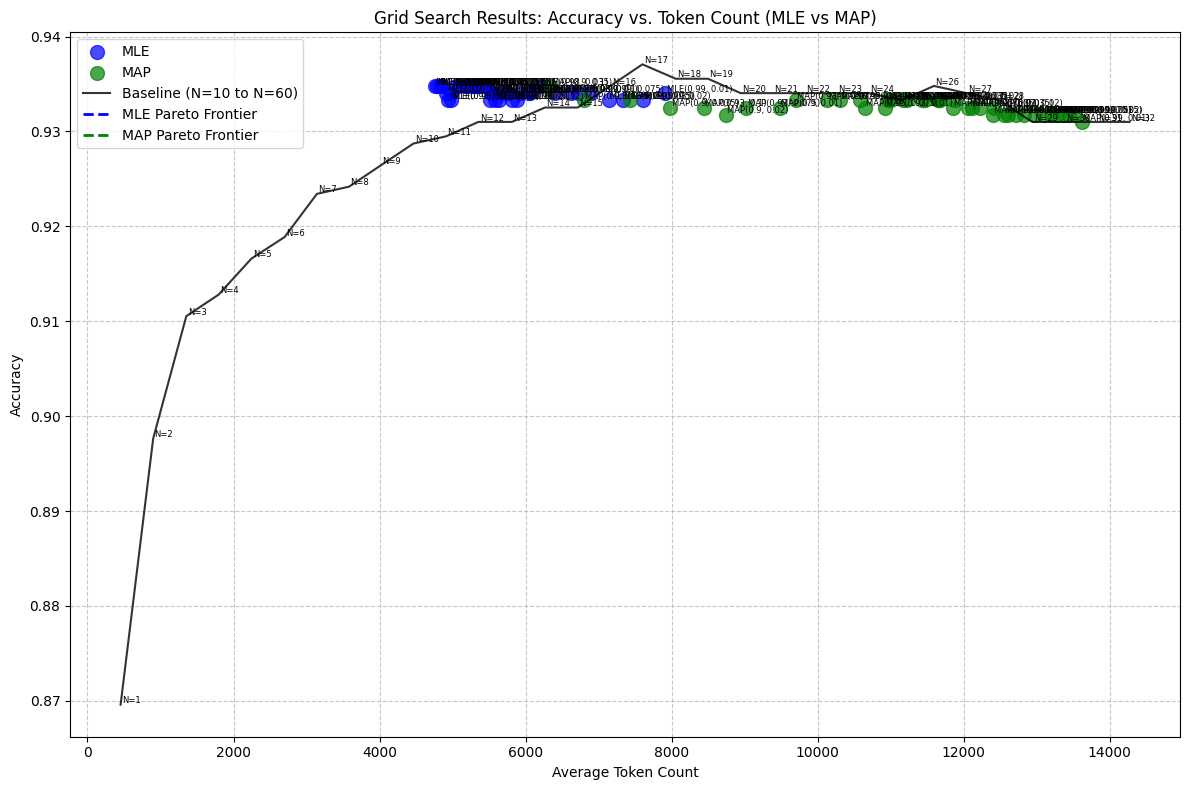


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9348, Avg Token Count: 4756.91

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9348, Avg Token Count: 6336.65


In [11]:
max_N_panel = 32
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

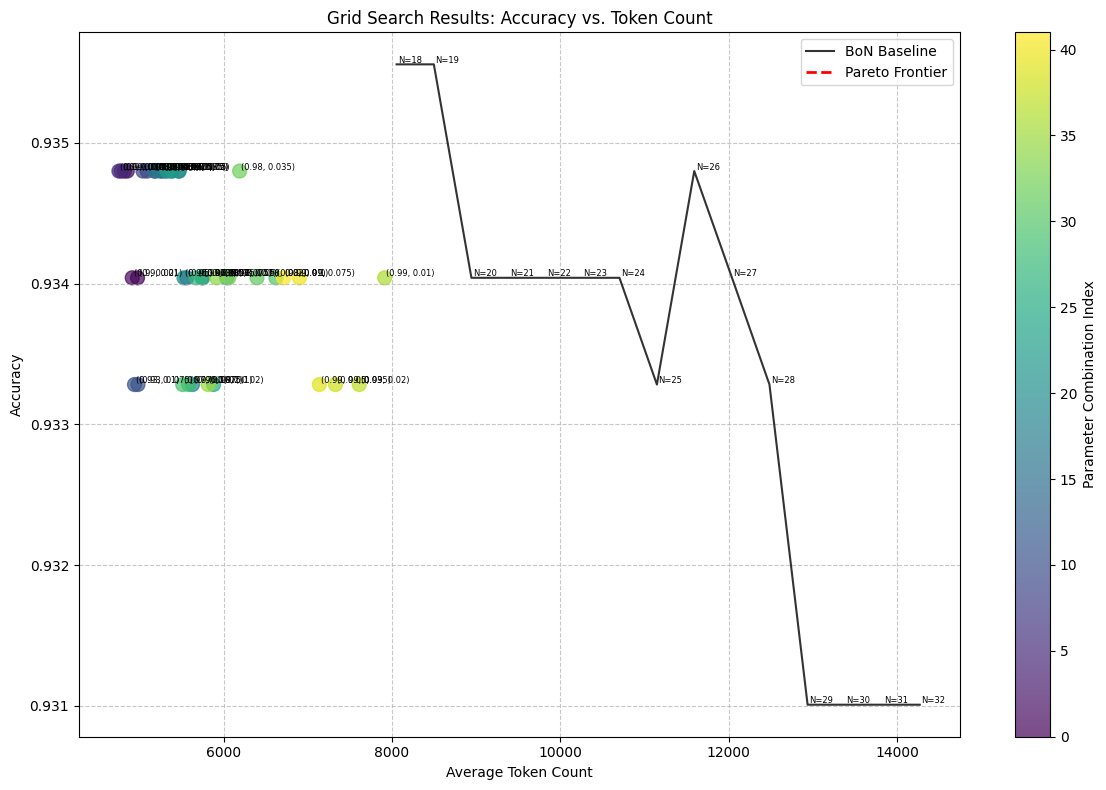

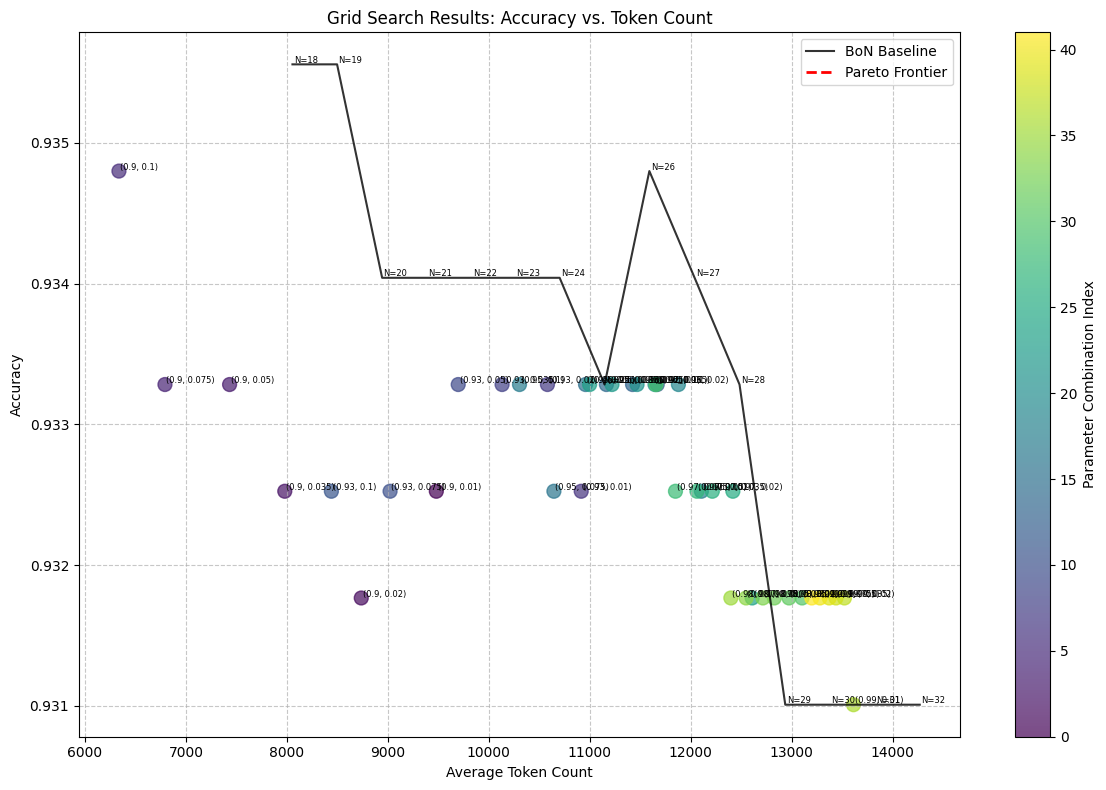

In [12]:
plot_optscale_start(mle_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)
plot_optscale_start(map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)

In [13]:
peek_number = 20

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916   13.0089    0.3532    0.6604    0.5428   21.7699    0.5656
1         0.3712      0.0375    0.9955    0.0043    0.7745    0.1983    1.0031    0.0092
2         0.6217      0.1013    0.9166    0.1656    0.8433    0.1336    0.9576    0.1450
3         0.4076      0.0870    1.5628    0.7524    0.6258    0.2703   48.1585    4.1681
4         0.4718      0.1396   90.6381    3.2354    0.7916    0.2285   88.3479    3.3720
5         0.5645      0.0934    0.9928    0.0040    0.9760    0.0232    1.3527    0.1195
6         0.4193      0.0764    0.9977    0.0014    0.6862    0.4823    0.9976    0.0011
7         0.4935      0.1110    1.1617    0.2391    0.8620    0.1375    1.3589    0.2502
8         0.4501      0.1188    1.2270    0.2440    0.7806    0.1676    1.1546    0.2116
9         0.4603      0.1372    3.7720    0.1490    0.8885    0.0967    9.0876    0.2182
10        0.3858      0.0913    0.9926    0.0031    0.9684    0.0367    0.9982    0.0105
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 64

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9371, Average Token Count: 9350.35
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9378, Average Token Count: 9273.58
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9371, Average Token Count: 9220.45
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 62, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9363, Average Token Count: 9181.10
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9371, Average Token Count: 9146.75
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

Target Score (MLE):  14%|█▍        | 1/7 [01:55<11:34, 115.81s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9363, Average Token Count: 9125.61


MLE Min N Required [20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 62, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9386, Average Token Count: 9794.17
MLE Min N Required [20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9371, Average Token Count: 9663.55
MLE Min N Required [20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9363, Average Token Count: 9555.97
MLE Min N Required [20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9363, Average Token Count: 9486.71
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9371, Average Token Count: 9404.63
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MLE):  29%|██▊       | 2/7 [03:54<09:46, 117.30s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9371, Average Token Count: 9353.19


MLE Min N Required [20, 20, 26, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9378, Average Token Count: 10274.39
MLE Min N Required [20, 20, 23, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9378, Average Token Count: 10118.76
MLE Min N Required [20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9386, Average Token Count: 9963.86
MLE Min N Required [20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9386, Average Token Count: 9865.99
MLE Min N Required [20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9386, Average Token Count: 9756.88
MLE Min N Required [20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MLE):  43%|████▎     | 3/7 [05:54<07:54, 118.69s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9378, Average Token Count: 9672.20


MLE Min N Required [20, 20, 34, 59, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9386, Average Token Count: 10576.22
MLE Min N Required [20, 20, 29, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 61, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9378, Average Token Count: 10422.54
MLE Min N Required [20, 20, 25, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9378, Average Token Count: 10271.65
MLE Min N Required [20, 20, 22, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9378, Average Token Count: 10164.85
MLE Min N Required [20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9378, Average Token Count: 10020.71
MLE Min N Required [20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  57%|█████▋    | 4/7 [07:57<06:00, 120.25s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9386, Average Token Count: 9913.47


MLE Min N Required [20, 20, 46, 64, 20, 20, 20, 28, 25, 20, 20, 22, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 21, 20, 20, 20, 34, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 49, 20, 20, 21, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9401, Average Token Count: 10953.23
MLE Min N Required [20, 20, 39, 64, 20, 20, 20, 24, 21, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 42, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9393, Average Token Count: 10768.01
MLE Min N Required [20, 20, 34, 58, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9393, Average Token Count: 10629.71
MLE Min N Required [20, 20, 30, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 57, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9378, Average Token Count: 10514.75
MLE Min N Required [20, 20, 26, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 55, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 57, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9378, Average Token Count: 10385.62
MLE Min N Required [20, 20, 23, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 44, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  71%|███████▏  | 5/7 [10:03<04:05, 122.62s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9371, Average Token Count: 10286.52


MLE Min N Required [20, 20, 64, 64, 27, 20, 20, 43, 38, 20, 20, 33, 22, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 42, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 22, 20, 20, 20, 32, 20, 20, 20, 51, 26, 29, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 23, 20, 20, 64, 20, 20, 64, 20, 20, 31, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 41, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9409, Average Token Count: 11488.49
MLE Min N Required [20, 20, 61, 64, 23, 20, 20, 36, 32, 20, 20, 28, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 36, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 27, 20, 20, 20, 44, 22, 25, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 26, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 35, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9409, Average Token Count: 11250.70
MLE Min N Required [20, 20, 52, 64, 20, 20, 20, 31, 28, 20, 20, 24, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 23, 20, 20, 20, 37, 20, 21, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 59, 20, 20, 22, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9409, Average Token Count: 11086.20
MLE Min N Required [20, 20, 47, 64, 20, 20, 20, 28, 25, 20, 20, 22, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 21, 20, 20, 20, 33, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 53, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9401, Average Token Count: 10986.18
MLE Min N Required [20, 20, 40, 64, 20, 20, 20, 24, 22, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 46, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9401, Average Token Count: 10845.58
MLE Min N Required [20, 20, 36, 60, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  86%|████████▌ | 6/7 [12:17<02:06, 126.33s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9401, Average Token Count: 10746.60


MLE Min N Required [20, 20, 64, 64, 54, 20, 20, 64, 64, 20, 20, 64, 43, 20, 20, 20, 20, 64, 20, 20, 38, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 25, 64, 20, 20, 20, 27, 21, 64, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 38, 20, 34, 21, 64, 20, 20, 33, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 20, 43, 20, 20, 20, 34, 20, 20, 20, 20, 64, 20, 43, 20, 20, 20, 63, 20, 20, 20, 64, 52, 58, 23, 33, 64, 20, 20, 20, 20, 23, 20, 20, 47, 20, 20, 20, 30, 22, 46, 20, 20, 64, 33, 20, 64, 20, 20, 61, 20, 20, 20, 64, 20, 20, 21, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 22, 20, 20, 20, 64, 20, 20, 20, 20, 20, 33, 64, 20, 20, 25, 20, 64, 20, 20, 64, 23, 24, 25, 20, 20, 20, 20, 20, 20, 64, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 28, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 35, 20, 20, 26, 64, 20, 20, 20, 64, 20, 20, 20, 20, 49, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 30, 64, 20, 20, 20, 20, 28, 20, 20, 25, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9393, Average Token Count: 13237.27
MLE Min N Required [20, 20, 64, 64, 46, 20, 20, 64, 64, 20, 20, 56, 37, 20, 20, 20, 20, 64, 20, 20, 32, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 22, 64, 20, 20, 20, 23, 20, 64, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 33, 20, 29, 20, 64, 20, 20, 28, 62, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 37, 20, 20, 20, 29, 20, 20, 20, 20, 64, 20, 36, 20, 20, 20, 53, 20, 20, 20, 64, 44, 49, 20, 28, 64, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 26, 20, 39, 20, 20, 64, 28, 20, 64, 20, 20, 52, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 28, 64, 20, 20, 22, 20, 64, 20, 20, 64, 20, 21, 21, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 24, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 30, 20, 20, 22, 60, 20, 20, 20, 64, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9393, Average Token Count: 12735.47
MLE Min N Required [20, 20, 64, 64, 40, 20, 20, 63, 56, 20, 20, 48, 32, 20, 20, 20, 20, 64, 20, 20, 28, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 20, 20, 20, 20, 20, 63, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 28, 20, 25, 20, 64, 20, 20, 24, 53, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 31, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 31, 20, 20, 20, 46, 20, 20, 20, 64, 38, 42, 20, 24, 64, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 22, 20, 33, 20, 20, 64, 24, 20, 64, 20, 20, 44, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 24, 64, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 51, 20, 20, 20, 60, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9401, Average Token Count: 12324.49
MLE Min N Required [20, 20, 64, 64, 35, 20, 20, 56, 50, 20, 20, 43, 28, 20, 20, 20, 20, 64, 20, 20, 25, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 56, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 25, 20, 22, 20, 64, 20, 20, 22, 48, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 28, 20, 20, 20, 22, 20, 20, 20, 20, 64, 20, 28, 20, 20, 20, 41, 20, 20, 20, 64, 34, 38, 20, 22, 64, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 30, 20, 20, 64, 21, 20, 64, 20, 20, 40, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 21, 64, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 46, 20, 20, 20, 54, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9401, Average Token Count: 12064.33
MLE Min N Required [20, 20, 64, 64, 31, 20, 20, 49, 43, 20, 20, 37, 25, 20, 20, 20, 20, 64, 20, 20, 22, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 49, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 22, 20, 20, 20, 64, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 24, 20, 20, 20, 36, 20, 20, 20, 58, 29, 33, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 26, 20, 20, 64, 20, 20, 64, 20, 20, 34, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 47, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9409, Average Token Count: 11769.16
MLE Min N Required [20, 20, 64, 64, 27, 20, 20, 43, 38, 20, 20, 33, 22, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 43, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 22, 20, 20, 20, 32, 20, 20, 20, 52, 26, 29, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 23, 20, 20, 64, 20, 20, 64, 20, 20, 31, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 41, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20

Target Score (MLE): 100%|██████████| 7/7 [14:45<00:00, 126.46s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9409, Average Token Count: 11556.10

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [43, 28, 20, 56, 26, 20, 41, 20, 27, 20, 20, 34, 27, 20, 37, 20, 20, 64, 26, 20, 20, 39, 33, 35, 20, 20, 20, 42, 20, 43, 41, 29, 42, 20, 20, 20, 28, 64, 20, 20, 20, 20, 20, 20, 20, 27, 20, 37, 20, 20, 42, 20, 38, 40, 20, 21, 48, 41, 20, 45, 20, 20, 64, 20, 20, 30, 20, 32, 28, 40, 23, 20, 21, 20, 20, 64, 40, 20, 20, 20, 35, 36, 30, 20, 20, 20, 38, 39, 36, 26, 40, 32, 20, 22, 41, 35, 41, 64, 29, 32, 20, 20, 39, 44, 40, 20, 20, 20, 29, 30, 37, 20, 20, 24, 20, 39, 32, 20, 21, 33, 20, 20, 56, 40, 35, 20, 48, 20, 38, 44, 36, 20, 40, 20, 38, 20, 20, 20, 45, 20, 42, 20, 20, 20, 20, 20, 40, 64, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 37, 39, 64, 28, 25, 20, 44, 39, 34, 41, 20, 32, 20, 20, 20, 20, 27, 33, 20, 20, 20, 36, 20, 33, 20, 20, 57, 56, 20, 36, 20, 41, 33, 20, 20, 20, 46, 40, 42, 20, 20, 20, 20, 20, 20, 20, 36, 39, 41, 33, 20, 44, 41, 20, 23, 20, 20, 38, 26, 20, 20, 36, 20, 37, 38, 20, 20, 20, 20, 20, 20, 20, 38, 20, 26, 20, 20, 41, 20, 30, 20, 39, 20, 20, 39, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9356, Average Token Count: 12293.46
MAP Min N Required [37, 24, 20, 48, 22, 20, 35, 20, 23, 20, 20, 29, 23, 20, 32, 20, 20, 60, 23, 20, 20, 33, 28, 30, 20, 20, 20, 36, 20, 37, 35, 25, 36, 20, 20, 20, 24, 64, 20, 20, 20, 20, 20, 20, 20, 23, 20, 32, 20, 20, 35, 20, 32, 34, 20, 20, 41, 35, 20, 38, 20, 20, 63, 20, 20, 26, 20, 27, 24, 34, 20, 20, 20, 20, 20, 64, 34, 20, 20, 20, 30, 31, 25, 20, 20, 20, 32, 33, 31, 22, 34, 27, 20, 20, 35, 30, 34, 64, 25, 28, 20, 20, 33, 37, 34, 20, 20, 20, 25, 26, 32, 20, 20, 20, 20, 33, 27, 20, 20, 28, 20, 20, 47, 34, 30, 20, 41, 20, 32, 38, 31, 20, 34, 20, 33, 20, 20, 20, 38, 20, 35, 20, 20, 20, 20, 20, 34, 64, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 32, 33, 64, 24, 21, 20, 38, 33, 29, 34, 20, 27, 20, 20, 20, 20, 23, 28, 20, 20, 20, 31, 20, 28, 20, 20, 48, 48, 20, 31, 20, 35, 28, 20, 20, 20, 39, 34, 36, 20, 20, 20, 20, 20, 20, 20, 30, 33, 35, 28, 20, 37, 35, 20, 20, 20, 20, 33, 22, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9356, Average Token Count: 11294.25
MAP Min N Required [32, 20, 20, 41, 20, 20, 30, 20, 20, 20, 20, 25, 20, 20, 27, 20, 20, 51, 20, 20, 20, 28, 24, 26, 20, 20, 20, 31, 20, 31, 30, 21, 31, 20, 20, 20, 21, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 30, 20, 27, 29, 20, 20, 35, 30, 20, 33, 20, 20, 54, 20, 20, 22, 20, 23, 21, 29, 20, 20, 20, 20, 20, 64, 29, 20, 20, 20, 25, 27, 22, 20, 20, 20, 27, 29, 26, 20, 30, 23, 20, 20, 30, 26, 30, 60, 21, 24, 20, 20, 28, 32, 29, 20, 20, 20, 21, 22, 27, 20, 20, 20, 20, 28, 23, 20, 20, 24, 20, 20, 41, 30, 26, 20, 35, 20, 27, 32, 27, 20, 29, 20, 28, 20, 20, 20, 33, 20, 30, 20, 20, 20, 20, 20, 29, 64, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 27, 29, 64, 21, 20, 20, 32, 28, 25, 30, 20, 23, 20, 20, 20, 20, 20, 24, 20, 20, 20, 27, 20, 24, 20, 20, 41, 41, 20, 26, 20, 30, 24, 20, 20, 20, 33, 30, 31, 20, 20, 20, 20, 20, 20, 20, 26, 29, 30, 24, 20, 32, 30, 20, 20, 20, 20, 28, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9356, Average Token Count: 10502.59
MAP Min N Required [28, 20, 20, 37, 20, 20, 27, 20, 20, 20, 20, 22, 20, 20, 24, 20, 20, 46, 20, 20, 20, 25, 21, 23, 20, 20, 20, 27, 20, 28, 27, 20, 28, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 27, 20, 25, 26, 20, 20, 31, 27, 20, 29, 20, 20, 49, 20, 20, 20, 20, 21, 20, 26, 20, 20, 20, 20, 20, 64, 26, 20, 20, 20, 23, 24, 20, 20, 20, 20, 25, 26, 24, 20, 27, 21, 20, 20, 27, 23, 27, 54, 20, 21, 20, 20, 25, 29, 26, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 25, 21, 20, 20, 22, 20, 20, 36, 26, 23, 20, 31, 20, 25, 29, 24, 20, 26, 20, 25, 20, 20, 20, 29, 20, 27, 20, 20, 20, 20, 20, 26, 64, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 25, 26, 61, 20, 20, 20, 29, 25, 22, 27, 20, 21, 20, 20, 20, 20, 20, 22, 20, 20, 20, 24, 20, 22, 20, 20, 37, 37, 20, 23, 20, 27, 22, 20, 20, 20, 30, 26, 28, 20, 20, 20, 20, 20, 20, 20, 23, 26, 27, 21, 20, 28, 27, 20, 20, 20, 20, 25, 20, 20, 20,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9356, Average Token Count: 10038.11
MAP Min N Required [24, 20, 20, 32, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 40, 20, 20, 20, 22, 20, 20, 20, 20, 20, 24, 20, 24, 23, 20, 24, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 24, 20, 21, 23, 20, 20, 27, 23, 20, 26, 20, 20, 42, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 59, 23, 20, 20, 20, 20, 21, 20, 20, 20, 20, 21, 22, 21, 20, 23, 20, 20, 20, 23, 20, 23, 47, 20, 20, 20, 20, 22, 25, 23, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 32, 23, 20, 20, 27, 20, 21, 25, 21, 20, 23, 20, 22, 20, 20, 20, 25, 20, 24, 20, 20, 20, 20, 20, 22, 64, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 22, 53, 20, 20, 20, 25, 22, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 32, 32, 20, 20, 20, 23, 20, 20, 20, 20, 26, 23, 24, 20, 20, 20, 20, 20, 20, 20, 20, 22, 23, 20, 20, 25, 23, 20, 20, 20, 20, 22, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9371, Average Token Count: 9557.22
MAP Min N Required [22, 20, 20, 28, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 22, 21, 20, 21, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 24, 21, 20, 23, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 21, 42, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 24, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 21, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 47, 20, 20, 20, 22, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 28, 20, 20, 20, 21, 20, 20, 20, 20, 23, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 22, 21, 20, 20, 20, 20, 20, 20, 20, 20, 

Target Score (MAP):  14%|█▍        | 1/7 [02:26<14:38, 146.37s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9363, Average Token Count: 9315.15


MAP Min N Required [63, 44, 28, 64, 39, 20, 61, 24, 44, 20, 20, 58, 46, 20, 57, 26, 20, 64, 42, 20, 28, 64, 48, 52, 20, 20, 20, 62, 20, 63, 60, 42, 63, 20, 20, 20, 46, 64, 31, 20, 25, 20, 20, 20, 20, 42, 22, 55, 20, 20, 61, 26, 55, 59, 20, 32, 64, 60, 32, 64, 20, 20, 64, 20, 30, 49, 20, 46, 44, 59, 37, 20, 34, 20, 20, 64, 59, 20, 31, 20, 51, 54, 47, 20, 20, 20, 56, 64, 55, 42, 60, 49, 20, 35, 60, 53, 60, 64, 47, 54, 20, 23, 64, 64, 59, 20, 20, 20, 46, 47, 54, 20, 20, 37, 26, 57, 48, 20, 32, 62, 20, 20, 64, 60, 51, 23, 64, 20, 55, 64, 53, 20, 59, 33, 60, 20, 20, 20, 64, 26, 61, 20, 20, 21, 21, 26, 58, 64, 60, 20, 20, 20, 20, 31, 28, 22, 20, 20, 20, 64, 56, 58, 64, 41, 41, 20, 64, 59, 52, 60, 20, 47, 20, 24, 20, 20, 42, 48, 20, 20, 20, 53, 20, 49, 20, 20, 64, 64, 20, 57, 20, 61, 49, 20, 26, 20, 64, 59, 62, 20, 20, 20, 20, 20, 20, 24, 52, 58, 60, 54, 27, 64, 60, 20, 36, 20, 20, 57, 42, 20, 30, 53, 20, 57, 56, 20, 20, 20, 20, 20, 20, 20, 58, 20, 46, 22, 30, 60, 20, 44, 20, 58, 22, 20, 58, 

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9386, Average Token Count: 16226.06
MAP Min N Required [54, 37, 24, 64, 34, 20, 52, 20, 37, 20, 20, 49, 39, 20, 48, 22, 20, 64, 36, 20, 24, 55, 41, 44, 20, 20, 20, 52, 20, 54, 51, 36, 53, 20, 20, 20, 39, 64, 26, 20, 21, 20, 20, 20, 20, 36, 20, 47, 20, 20, 52, 22, 47, 50, 20, 27, 60, 51, 27, 57, 20, 20, 64, 20, 25, 41, 20, 39, 38, 50, 32, 20, 29, 20, 20, 64, 51, 20, 26, 20, 43, 46, 40, 20, 20, 20, 47, 57, 47, 35, 51, 41, 20, 30, 51, 45, 51, 64, 40, 46, 20, 20, 60, 55, 50, 20, 20, 20, 39, 40, 46, 20, 20, 32, 23, 49, 41, 20, 27, 53, 20, 20, 64, 51, 43, 20, 60, 20, 47, 58, 45, 20, 50, 28, 51, 20, 20, 20, 56, 22, 52, 20, 20, 20, 20, 22, 49, 64, 51, 20, 20, 20, 20, 26, 24, 20, 20, 20, 20, 64, 47, 49, 64, 35, 35, 20, 55, 50, 45, 51, 20, 40, 20, 21, 20, 20, 36, 41, 20, 20, 20, 45, 20, 41, 20, 20, 64, 64, 20, 48, 20, 52, 41, 20, 22, 20, 59, 51, 53, 20, 20, 20, 20, 20, 20, 20, 44, 50, 51, 46, 23, 55, 51, 20, 30, 20, 20, 48, 36, 20, 25,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9378, Average Token Count: 14596.63
MAP Min N Required [46, 32, 20, 63, 29, 20, 44, 20, 32, 20, 20, 42, 34, 20, 42, 20, 20, 64, 31, 20, 21, 47, 35, 38, 20, 20, 20, 45, 20, 46, 44, 31, 46, 20, 20, 20, 33, 64, 22, 20, 20, 20, 20, 20, 20, 31, 20, 40, 20, 20, 45, 20, 40, 43, 20, 23, 52, 44, 23, 49, 20, 20, 64, 20, 22, 36, 20, 34, 32, 43, 27, 20, 25, 20, 20, 64, 43, 20, 23, 20, 37, 39, 34, 20, 20, 20, 41, 49, 40, 30, 44, 35, 20, 26, 44, 38, 44, 64, 35, 40, 20, 20, 52, 47, 43, 20, 20, 20, 33, 34, 40, 20, 20, 27, 20, 42, 35, 20, 23, 45, 20, 20, 64, 44, 37, 20, 51, 20, 40, 49, 39, 20, 43, 24, 44, 20, 20, 20, 48, 20, 45, 20, 20, 20, 20, 20, 42, 64, 44, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 64, 41, 42, 64, 30, 30, 20, 47, 43, 38, 44, 20, 34, 20, 20, 20, 20, 31, 35, 20, 20, 20, 39, 20, 36, 20, 20, 64, 62, 20, 41, 20, 45, 36, 20, 20, 20, 50, 43, 46, 20, 20, 20, 20, 20, 20, 20, 38, 43, 44, 40, 20, 47, 44, 20, 26, 20, 20, 41, 31, 20, 22,

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9386, Average Token Count: 13273.79
MAP Min N Required [41, 28, 20, 57, 26, 20, 40, 20, 29, 20, 20, 38, 30, 20, 37, 20, 20, 64, 27, 20, 20, 42, 31, 34, 20, 20, 20, 40, 20, 41, 39, 28, 41, 20, 20, 20, 30, 64, 20, 20, 20, 20, 20, 20, 20, 28, 20, 36, 20, 20, 40, 20, 36, 39, 20, 21, 46, 39, 21, 43, 20, 20, 64, 20, 20, 32, 20, 30, 29, 39, 24, 20, 22, 20, 20, 64, 39, 20, 20, 20, 33, 35, 31, 20, 20, 20, 36, 44, 36, 27, 39, 32, 20, 23, 39, 34, 39, 64, 31, 36, 20, 20, 46, 42, 38, 20, 20, 20, 30, 31, 35, 20, 20, 24, 20, 37, 32, 20, 21, 41, 20, 20, 61, 39, 33, 20, 46, 20, 36, 44, 35, 20, 39, 22, 39, 20, 20, 20, 43, 20, 40, 20, 20, 20, 20, 20, 38, 64, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 36, 38, 64, 27, 27, 20, 42, 39, 34, 39, 20, 30, 20, 20, 20, 20, 27, 31, 20, 20, 20, 35, 20, 32, 20, 20, 64, 56, 20, 37, 20, 40, 32, 20, 20, 20, 45, 39, 41, 20, 20, 20, 20, 20, 20, 20, 34, 38, 39, 35, 20, 42, 39, 20, 23, 20, 20, 37, 28, 20, 20

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9371, Average Token Count: 12434.15
MAP Min N Required [36, 25, 20, 49, 22, 20, 34, 20, 25, 20, 20, 33, 26, 20, 32, 20, 20, 64, 24, 20, 20, 36, 27, 29, 20, 20, 20, 35, 20, 36, 34, 24, 36, 20, 20, 20, 26, 64, 20, 20, 20, 20, 20, 20, 20, 24, 20, 31, 20, 20, 35, 20, 31, 33, 20, 20, 40, 34, 20, 38, 20, 20, 64, 20, 20, 28, 20, 26, 25, 34, 21, 20, 20, 20, 20, 64, 34, 20, 20, 20, 29, 30, 27, 20, 20, 20, 31, 38, 31, 24, 34, 28, 20, 20, 34, 30, 34, 64, 27, 31, 20, 20, 40, 37, 33, 20, 20, 20, 26, 27, 31, 20, 20, 21, 20, 32, 27, 20, 20, 35, 20, 20, 53, 34, 29, 20, 40, 20, 31, 38, 30, 20, 33, 20, 34, 20, 20, 20, 37, 20, 35, 20, 20, 20, 20, 20, 33, 64, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 31, 33, 64, 23, 23, 20, 37, 33, 30, 34, 20, 26, 20, 20, 20, 20, 24, 27, 20, 20, 20, 30, 20, 28, 20, 20, 56, 48, 20, 32, 20, 35, 28, 20, 20, 20, 39, 34, 35, 20, 20, 20, 20, 20, 20, 20, 29, 33, 34, 31, 20, 36, 34, 20, 20, 20, 20, 32, 24, 20, 20,

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9371, Average Token Count: 11523.27
MAP Min N Required [32, 22, 20, 44, 20, 20, 31, 20, 22, 20, 20, 29, 23, 20, 29, 20, 20, 64, 21, 20, 20, 32, 24, 26, 20, 20, 20, 31, 20, 32, 30, 21, 32, 20, 20, 20, 23, 64, 20, 20, 20, 20, 20, 20, 20, 21, 20, 28, 20, 20, 31, 20, 28, 30, 20, 20, 36, 30, 20, 34, 20, 20, 64, 20, 20, 25, 20, 23, 22, 30, 20, 20, 20, 20, 20, 64, 30, 20, 20, 20, 26, 27, 24, 20, 20, 20, 28, 34, 28, 21, 30, 25, 20, 20, 30, 27, 30, 64, 24, 27, 20, 20, 36, 33, 30, 20, 20, 20, 23, 24, 27, 20, 20, 20, 20, 29, 24, 20, 20, 31, 20, 20, 47, 30, 26, 20, 35, 20, 28, 34, 27, 20, 30, 20, 30, 20, 20, 20, 33, 20, 31, 20, 20, 20, 20, 20, 29, 64, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 28, 29, 64, 21, 21, 20, 33, 30, 26, 30, 20, 24, 20, 20, 20, 20, 21, 24, 20, 20, 20, 27, 20, 25, 20, 20, 50, 43, 20, 29, 20, 31, 25, 20, 20, 20, 35, 30, 31, 20, 20, 20, 20, 20, 20, 20, 26, 29, 30, 27, 20, 32, 30, 20, 20, 20, 20, 29, 21, 20, 20

Target Score (MAP):  29%|██▊       | 2/7 [05:12<13:09, 157.83s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9363, Average Token Count: 10879.51


MAP Min N Required [64, 64, 42, 64, 58, 20, 64, 36, 64, 28, 20, 64, 64, 20, 64, 40, 23, 64, 63, 20, 41, 64, 64, 64, 20, 20, 20, 64, 21, 64, 64, 60, 64, 20, 25, 22, 64, 64, 47, 20, 37, 24, 20, 31, 26, 63, 32, 64, 31, 29, 64, 39, 64, 64, 22, 46, 64, 64, 49, 64, 28, 20, 64, 20, 45, 64, 20, 64, 64, 64, 58, 23, 52, 20, 20, 64, 64, 20, 54, 20, 64, 64, 64, 27, 20, 20, 64, 64, 64, 63, 64, 64, 20, 52, 64, 64, 64, 64, 64, 64, 20, 35, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 32, 55, 47, 64, 64, 20, 46, 64, 28, 20, 64, 64, 64, 33, 64, 20, 64, 64, 64, 20, 64, 50, 64, 23, 20, 30, 64, 45, 64, 20, 20, 33, 33, 41, 64, 64, 64, 25, 27, 20, 20, 47, 43, 36, 20, 20, 20, 64, 64, 64, 64, 58, 64, 20, 64, 64, 64, 64, 20, 64, 28, 38, 35, 20, 62, 64, 20, 31, 30, 64, 30, 64, 20, 20, 64, 64, 20, 64, 20, 64, 64, 20, 39, 20, 64, 64, 64, 30, 25, 20, 20, 23, 20, 35, 64, 64, 64, 64, 42, 64, 64, 20, 54, 20, 20, 64, 64, 20, 45, 64, 20, 64, 64, 20, 20, 20, 31, 20, 20, 20, 64, 20, 64, 34, 46, 64, 20, 62, 20, 64, 34, 20, 64, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9386, Average Token Count: 19180.49
MAP Min N Required [64, 55, 36, 64, 49, 20, 64, 30, 57, 23, 20, 64, 62, 20, 64, 34, 20, 64, 53, 20, 35, 64, 58, 63, 20, 20, 20, 64, 20, 64, 64, 51, 64, 20, 21, 20, 59, 64, 40, 20, 32, 20, 20, 27, 22, 53, 27, 64, 27, 25, 64, 33, 64, 64, 20, 39, 64, 64, 42, 64, 24, 20, 64, 20, 38, 63, 20, 56, 56, 64, 49, 20, 44, 20, 20, 64, 64, 20, 46, 20, 62, 64, 59, 23, 20, 20, 64, 64, 64, 54, 64, 61, 20, 44, 64, 64, 64, 64, 62, 64, 20, 30, 64, 64, 64, 20, 20, 20, 58, 59, 64, 20, 27, 47, 40, 64, 60, 20, 39, 64, 24, 20, 64, 64, 62, 29, 64, 20, 64, 64, 64, 20, 64, 43, 64, 20, 20, 25, 64, 39, 64, 20, 20, 28, 28, 35, 64, 64, 64, 21, 23, 20, 20, 40, 36, 31, 20, 20, 20, 64, 64, 64, 64, 50, 55, 20, 64, 64, 64, 64, 20, 56, 24, 32, 29, 20, 53, 58, 20, 27, 26, 64, 26, 59, 20, 20, 64, 64, 20, 64, 20, 64, 59, 20, 33, 20, 64, 64, 64, 26, 21, 20, 20, 20, 20, 30, 63, 64, 64, 64, 36, 64, 64, 20, 46, 20, 20, 64, 55, 20, 39,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9386, Average Token Count: 18229.99
MAP Min N Required [64, 47, 31, 64, 42, 20, 63, 26, 49, 20, 20, 64, 53, 20, 61, 29, 20, 64, 46, 20, 30, 64, 49, 54, 20, 20, 20, 64, 20, 64, 62, 44, 64, 20, 20, 20, 51, 64, 34, 20, 27, 20, 20, 23, 20, 46, 23, 57, 23, 21, 64, 29, 58, 62, 20, 33, 64, 63, 36, 64, 20, 20, 64, 20, 33, 54, 20, 48, 48, 62, 42, 20, 38, 20, 20, 64, 62, 20, 39, 20, 53, 56, 51, 20, 20, 20, 58, 64, 59, 46, 62, 52, 20, 38, 63, 55, 63, 64, 53, 62, 20, 25, 64, 64, 61, 20, 20, 20, 50, 51, 56, 20, 23, 40, 34, 60, 52, 20, 34, 64, 20, 20, 64, 63, 53, 24, 64, 20, 57, 64, 55, 20, 62, 37, 64, 20, 20, 22, 64, 33, 64, 20, 20, 24, 24, 30, 60, 64, 63, 20, 20, 20, 20, 35, 31, 26, 20, 20, 20, 64, 58, 60, 64, 43, 47, 20, 64, 63, 57, 62, 20, 48, 21, 28, 25, 20, 45, 50, 20, 23, 22, 55, 22, 50, 20, 20, 64, 64, 20, 62, 20, 64, 51, 20, 28, 20, 64, 62, 64, 22, 20, 20, 20, 20, 20, 25, 54, 61, 63, 62, 31, 64, 63, 20, 39, 20, 20, 59, 47, 20, 33,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9386, Average Token Count: 17006.77
MAP Min N Required [59, 42, 28, 64, 38, 20, 57, 23, 44, 20, 20, 59, 48, 20, 54, 26, 20, 64, 41, 20, 27, 64, 44, 48, 20, 20, 20, 57, 20, 59, 55, 39, 59, 20, 20, 20, 45, 64, 30, 20, 24, 20, 20, 20, 20, 41, 21, 51, 21, 20, 57, 26, 52, 55, 20, 30, 64, 56, 32, 62, 20, 20, 64, 20, 29, 48, 20, 43, 43, 55, 38, 20, 34, 20, 20, 64, 55, 20, 35, 20, 47, 50, 46, 20, 20, 20, 52, 64, 53, 41, 56, 47, 20, 34, 56, 50, 56, 64, 48, 56, 20, 23, 64, 61, 54, 20, 20, 20, 45, 45, 50, 20, 21, 36, 30, 53, 46, 20, 30, 64, 20, 20, 64, 56, 47, 22, 64, 20, 51, 64, 49, 20, 55, 33, 58, 20, 20, 20, 61, 30, 57, 20, 20, 22, 22, 27, 54, 64, 56, 20, 20, 20, 20, 31, 28, 24, 20, 20, 20, 64, 52, 54, 64, 38, 42, 20, 60, 56, 51, 56, 20, 43, 20, 25, 23, 20, 40, 45, 20, 21, 20, 50, 20, 45, 20, 20, 64, 64, 20, 55, 20, 57, 45, 20, 25, 20, 64, 55, 58, 20, 20, 20, 20, 20, 20, 23, 48, 55, 56, 55, 28, 60, 56, 20, 35, 20, 20, 53, 42, 20, 30

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9386, Average Token Count: 15901.85
MAP Min N Required [51, 37, 24, 64, 33, 20, 49, 20, 38, 20, 20, 51, 41, 20, 47, 23, 20, 64, 35, 20, 24, 57, 38, 42, 20, 20, 20, 50, 20, 51, 48, 34, 51, 20, 20, 20, 39, 64, 26, 20, 21, 20, 20, 20, 20, 36, 20, 44, 20, 20, 50, 22, 45, 48, 20, 26, 57, 49, 28, 54, 20, 20, 64, 20, 26, 42, 20, 37, 38, 48, 33, 20, 29, 20, 20, 64, 48, 20, 30, 20, 41, 43, 40, 20, 20, 20, 45, 61, 46, 36, 48, 40, 20, 29, 49, 43, 49, 64, 41, 48, 20, 20, 64, 53, 47, 20, 20, 20, 39, 39, 44, 20, 20, 31, 26, 46, 40, 20, 26, 60, 20, 20, 64, 48, 41, 20, 57, 20, 44, 56, 43, 20, 48, 29, 50, 20, 20, 20, 53, 26, 49, 20, 20, 20, 20, 23, 47, 64, 49, 20, 20, 20, 20, 27, 24, 21, 20, 20, 20, 64, 45, 46, 64, 33, 37, 20, 52, 49, 44, 48, 20, 37, 20, 22, 20, 20, 35, 39, 20, 20, 20, 43, 20, 39, 20, 20, 64, 64, 20, 48, 20, 50, 39, 20, 22, 20, 57, 48, 50, 20, 20, 20, 20, 20, 20, 20, 42, 47, 49, 48, 24, 52, 48, 20, 30, 20, 20, 46, 36, 20, 26,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9378, Average Token Count: 14504.77
MAP Min N Required [45, 33, 21, 64, 29, 20, 44, 20, 34, 20, 20, 45, 37, 20, 42, 20, 20, 64, 32, 20, 21, 50, 34, 37, 20, 20, 20, 44, 20, 45, 43, 30, 45, 20, 20, 20, 35, 64, 24, 20, 20, 20, 20, 20, 20, 32, 20, 39, 20, 20, 44, 20, 40, 42, 20, 23, 51, 43, 25, 48, 20, 20, 64, 20, 23, 37, 20, 33, 33, 43, 29, 20, 26, 20, 20, 64, 43, 20, 27, 20, 36, 38, 35, 20, 20, 20, 40, 54, 41, 32, 43, 36, 20, 26, 43, 38, 43, 64, 37, 43, 20, 20, 59, 47, 42, 20, 20, 20, 34, 35, 39, 20, 20, 28, 24, 41, 36, 20, 23, 53, 20, 20, 64, 43, 36, 20, 50, 20, 39, 50, 38, 20, 43, 25, 44, 20, 20, 20, 47, 23, 44, 20, 20, 20, 20, 21, 41, 64, 43, 20, 20, 20, 20, 24, 22, 20, 20, 20, 20, 64, 40, 41, 64, 29, 33, 20, 46, 44, 39, 43, 20, 33, 20, 20, 20, 20, 31, 34, 20, 20, 20, 38, 20, 35, 20, 20, 64, 63, 20, 43, 20, 44, 35, 20, 20, 20, 50, 43, 45, 20, 20, 20, 20, 20, 20, 20, 37, 42, 43, 42, 21, 46, 43, 20, 27, 20, 20, 41, 32, 20, 23

Target Score (MAP):  43%|████▎     | 3/7 [08:22<11:30, 172.69s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9386, Average Token Count: 13496.22


MAP Min N Required [64, 64, 56, 64, 64, 20, 64, 47, 64, 37, 20, 64, 64, 20, 64, 53, 31, 64, 64, 20, 53, 64, 64, 64, 20, 20, 20, 64, 29, 64, 64, 64, 64, 20, 33, 31, 64, 64, 61, 20, 48, 33, 20, 41, 35, 64, 41, 64, 41, 38, 64, 51, 64, 64, 29, 58, 64, 64, 64, 64, 37, 21, 64, 20, 58, 64, 20, 64, 64, 64, 64, 30, 64, 26, 22, 64, 64, 23, 64, 20, 64, 64, 64, 37, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 46, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 42, 64, 64, 64, 64, 20, 59, 64, 36, 20, 64, 64, 64, 43, 64, 20, 64, 64, 64, 20, 64, 64, 64, 31, 20, 40, 64, 63, 64, 20, 20, 43, 44, 54, 64, 64, 64, 34, 37, 20, 20, 63, 56, 49, 20, 20, 20, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 20, 64, 39, 50, 49, 20, 64, 64, 20, 42, 41, 64, 42, 64, 28, 21, 64, 64, 20, 64, 20, 64, 64, 20, 50, 20, 64, 64, 64, 41, 34, 25, 20, 31, 20, 44, 64, 64, 64, 64, 56, 64, 64, 20, 64, 20, 20, 64, 64, 27, 59, 64, 21, 64, 64, 20, 20, 20, 41, 20, 20, 20, 64, 20, 64, 45, 61, 64, 20, 64, 20, 64, 45, 20, 64, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9386, Average Token Count: 20638.15
MAP Min N Required [64, 64, 47, 64, 63, 20, 64, 40, 64, 31, 20, 64, 64, 20, 64, 45, 26, 64, 64, 20, 45, 64, 64, 64, 20, 20, 20, 64, 24, 64, 64, 64, 64, 20, 28, 26, 64, 64, 52, 20, 41, 28, 20, 35, 30, 64, 34, 64, 35, 32, 64, 44, 64, 64, 25, 50, 64, 64, 55, 64, 31, 20, 64, 20, 50, 64, 20, 64, 64, 64, 64, 26, 57, 22, 20, 64, 64, 20, 64, 20, 64, 64, 64, 31, 20, 20, 64, 64, 64, 64, 64, 64, 20, 57, 64, 64, 64, 64, 64, 64, 20, 39, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 36, 60, 56, 64, 64, 20, 50, 64, 30, 20, 64, 64, 64, 37, 64, 20, 64, 64, 64, 20, 64, 56, 64, 26, 20, 34, 64, 54, 64, 20, 20, 37, 37, 46, 64, 64, 64, 29, 32, 20, 20, 53, 48, 42, 20, 20, 20, 64, 64, 64, 64, 62, 64, 20, 64, 64, 64, 64, 20, 64, 33, 43, 42, 20, 64, 64, 20, 36, 35, 64, 36, 64, 24, 20, 64, 64, 20, 64, 20, 64, 64, 20, 43, 20, 64, 64, 64, 35, 29, 22, 20, 27, 20, 38, 64, 64, 64, 64, 47, 64, 64, 20, 59, 20, 20, 64, 64, 23, 50,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9386, Average Token Count: 19796.98
MAP Min N Required [64, 61, 41, 64, 54, 20, 64, 34, 64, 27, 20, 64, 64, 20, 64, 38, 23, 64, 59, 20, 39, 64, 62, 64, 20, 20, 20, 64, 21, 64, 64, 55, 64, 20, 24, 22, 64, 64, 44, 20, 35, 24, 20, 30, 26, 59, 30, 64, 30, 28, 64, 38, 64, 64, 21, 43, 64, 64, 47, 64, 27, 20, 64, 20, 43, 64, 20, 60, 63, 64, 55, 22, 49, 20, 20, 64, 64, 20, 55, 20, 64, 64, 64, 27, 20, 20, 64, 64, 64, 60, 64, 64, 20, 49, 64, 64, 64, 64, 64, 64, 20, 33, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 31, 51, 48, 64, 64, 20, 43, 64, 26, 20, 64, 64, 64, 31, 64, 20, 64, 64, 64, 20, 64, 48, 64, 23, 20, 29, 64, 46, 64, 20, 20, 32, 32, 40, 64, 64, 64, 25, 27, 20, 20, 46, 41, 36, 20, 20, 20, 64, 64, 64, 64, 54, 63, 20, 64, 64, 64, 64, 20, 61, 29, 37, 36, 20, 58, 63, 20, 31, 30, 64, 31, 63, 20, 20, 64, 64, 20, 64, 20, 64, 64, 20, 37, 20, 64, 64, 64, 30, 25, 20, 20, 23, 20, 33, 64, 64, 64, 64, 41, 64, 64, 20, 51, 20, 20, 64, 61, 20, 43,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9386, Average Token Count: 18943.83
MAP Min N Required [64, 55, 36, 64, 48, 20, 64, 31, 57, 24, 20, 64, 63, 20, 64, 34, 20, 64, 53, 20, 35, 64, 56, 61, 20, 20, 20, 64, 20, 64, 64, 49, 64, 20, 21, 20, 59, 64, 40, 20, 31, 21, 20, 27, 23, 53, 27, 64, 27, 25, 64, 34, 64, 64, 20, 38, 64, 64, 42, 64, 24, 20, 64, 20, 38, 63, 20, 54, 56, 64, 50, 20, 44, 20, 20, 64, 64, 20, 49, 20, 60, 63, 59, 24, 20, 20, 64, 64, 64, 53, 64, 60, 20, 44, 64, 63, 64, 64, 62, 64, 20, 30, 64, 64, 64, 20, 20, 20, 58, 59, 63, 20, 28, 46, 43, 64, 59, 20, 38, 64, 23, 20, 64, 64, 59, 28, 64, 20, 64, 64, 62, 20, 64, 43, 64, 20, 20, 26, 64, 41, 64, 20, 20, 28, 29, 35, 64, 64, 64, 22, 24, 20, 20, 41, 37, 32, 20, 20, 20, 64, 64, 64, 64, 48, 56, 20, 64, 64, 64, 64, 20, 54, 26, 33, 32, 20, 52, 56, 20, 28, 27, 62, 28, 57, 20, 20, 64, 64, 20, 64, 20, 64, 57, 20, 33, 20, 64, 64, 64, 27, 22, 20, 20, 21, 20, 29, 61, 64, 64, 64, 36, 64, 64, 20, 45, 20, 20, 64, 55, 20, 39

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9386, Average Token Count: 18207.63
MAP Min N Required [64, 47, 31, 64, 42, 20, 62, 26, 49, 21, 20, 64, 55, 20, 60, 30, 20, 64, 46, 20, 30, 64, 48, 53, 20, 20, 20, 63, 20, 64, 61, 43, 64, 20, 20, 20, 51, 64, 34, 20, 27, 20, 20, 24, 20, 46, 23, 55, 23, 22, 62, 29, 56, 60, 20, 33, 64, 61, 37, 64, 21, 20, 64, 20, 33, 54, 20, 47, 48, 61, 43, 20, 38, 20, 20, 64, 61, 20, 42, 20, 52, 55, 51, 21, 20, 20, 57, 64, 58, 46, 61, 52, 20, 38, 62, 54, 61, 64, 54, 64, 20, 26, 64, 64, 59, 20, 20, 20, 50, 51, 55, 20, 24, 40, 37, 58, 51, 20, 33, 64, 20, 20, 64, 61, 51, 24, 64, 20, 56, 64, 54, 20, 61, 37, 64, 20, 20, 23, 64, 36, 62, 20, 20, 25, 25, 31, 59, 64, 62, 20, 21, 20, 20, 35, 32, 28, 20, 20, 20, 64, 57, 59, 64, 42, 48, 20, 64, 63, 56, 61, 20, 47, 22, 29, 28, 20, 45, 49, 20, 24, 23, 54, 24, 49, 20, 20, 64, 64, 20, 62, 20, 63, 49, 20, 29, 20, 64, 61, 64, 23, 20, 20, 20, 20, 20, 25, 53, 60, 62, 63, 32, 64, 61, 20, 39, 20, 20, 58, 47, 20, 33,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9386, Average Token Count: 16975.77
MAP Min N Required [57, 42, 28, 64, 37, 20, 55, 24, 44, 20, 20, 60, 49, 20, 54, 27, 20, 64, 41, 20, 27, 64, 43, 47, 20, 20, 20, 56, 20, 57, 54, 38, 57, 20, 20, 20, 45, 64, 31, 20, 24, 20, 20, 21, 20, 41, 21, 49, 21, 20, 56, 26, 50, 54, 20, 29, 64, 55, 33, 61, 20, 20, 64, 20, 29, 48, 20, 41, 43, 54, 38, 20, 34, 20, 20, 64, 54, 20, 38, 20, 46, 49, 45, 20, 20, 20, 51, 64, 52, 41, 54, 46, 20, 34, 55, 48, 55, 64, 48, 57, 20, 23, 64, 59, 53, 20, 20, 20, 44, 45, 49, 20, 21, 35, 33, 52, 46, 20, 30, 64, 20, 20, 64, 54, 46, 22, 63, 20, 50, 64, 48, 20, 54, 33, 57, 20, 20, 20, 60, 32, 55, 20, 20, 22, 22, 27, 52, 64, 55, 20, 20, 20, 20, 32, 28, 25, 20, 20, 20, 64, 51, 52, 64, 37, 43, 20, 58, 56, 50, 54, 20, 42, 20, 25, 25, 20, 40, 43, 20, 21, 21, 48, 21, 44, 20, 20, 64, 64, 20, 55, 20, 56, 44, 20, 25, 20, 64, 54, 57, 21, 20, 20, 20, 20, 20, 22, 47, 53, 55, 56, 28, 58, 54, 20, 35, 20, 20, 52, 42, 20, 30

Target Score (MAP):  57%|█████▋    | 4/7 [11:47<09:16, 185.53s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9386, Average Token Count: 15794.39


MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 52, 20, 64, 64, 20, 64, 64, 45, 64, 64, 26, 64, 64, 64, 64, 20, 20, 20, 64, 42, 64, 64, 64, 64, 24, 47, 45, 64, 64, 64, 26, 64, 48, 20, 59, 50, 64, 55, 64, 58, 53, 64, 64, 64, 64, 41, 64, 64, 64, 64, 64, 52, 30, 64, 26, 64, 64, 20, 64, 64, 64, 64, 44, 64, 38, 33, 64, 64, 32, 64, 20, 64, 64, 64, 53, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 26, 23, 64, 64, 64, 20, 61, 64, 64, 64, 64, 20, 64, 64, 48, 20, 64, 64, 64, 59, 64, 24, 64, 64, 64, 20, 64, 64, 64, 45, 20, 57, 64, 64, 64, 30, 20, 61, 62, 64, 64, 64, 64, 48, 55, 22, 20, 64, 64, 64, 29, 22, 20, 64, 64, 64, 64, 64, 64, 30, 64, 64, 64, 64, 20, 64, 58, 64, 64, 21, 64, 64, 20, 60, 60, 64, 63, 64, 41, 30, 64, 64, 22, 64, 20, 64, 64, 29, 64, 20, 64, 64, 64, 58, 49, 35, 20, 46, 20, 61, 64, 64, 64, 64, 64, 64, 64, 26, 64, 21, 20, 64, 64, 39, 64, 64, 29, 64, 64, 20, 24, 24, 57, 20, 20, 25, 64, 20, 64, 63, 64, 64, 21, 64, 23, 64, 63, 20, 64, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9393, Average Token Count: 22393.86
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 55, 64, 44, 20, 64, 64, 20, 64, 63, 38, 64, 64, 22, 62, 64, 64, 64, 20, 20, 20, 64, 35, 64, 64, 64, 64, 20, 40, 39, 64, 64, 64, 22, 56, 41, 20, 50, 43, 64, 47, 64, 49, 45, 64, 61, 64, 64, 35, 64, 64, 64, 64, 64, 44, 25, 64, 22, 64, 64, 20, 64, 64, 64, 64, 37, 64, 33, 28, 64, 64, 27, 64, 20, 64, 64, 64, 45, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 54, 64, 64, 64, 20, 22, 20, 64, 64, 64, 20, 52, 64, 64, 64, 64, 20, 64, 64, 41, 20, 64, 64, 64, 50, 64, 20, 64, 64, 64, 20, 64, 64, 64, 38, 20, 48, 64, 64, 64, 26, 20, 52, 53, 64, 64, 64, 64, 41, 46, 20, 20, 64, 64, 60, 25, 20, 20, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 20, 64, 49, 61, 63, 20, 64, 64, 20, 51, 51, 64, 54, 64, 35, 26, 64, 64, 20, 64, 20, 64, 64, 25, 59, 20, 64, 64, 64, 49, 42, 30, 20, 39, 20, 52, 64, 64, 64, 64, 64, 64, 64, 22, 64, 20, 20, 64, 64, 33, 64,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9401, Average Token Count: 21603.51
MAP Min N Required [64, 64, 57, 64, 64, 20, 64, 47, 64, 38, 20, 64, 64, 20, 64, 54, 33, 64, 64, 20, 53, 64, 64, 64, 20, 20, 20, 64, 30, 64, 64, 64, 64, 20, 34, 33, 64, 64, 62, 20, 48, 35, 20, 43, 37, 64, 40, 64, 42, 39, 64, 53, 64, 64, 30, 58, 64, 64, 64, 64, 38, 22, 64, 20, 59, 64, 20, 64, 64, 64, 64, 32, 64, 28, 24, 64, 64, 24, 64, 20, 64, 64, 64, 39, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 46, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 44, 64, 64, 64, 64, 20, 58, 64, 35, 20, 64, 64, 64, 43, 64, 20, 64, 64, 64, 20, 64, 64, 64, 33, 20, 42, 64, 64, 64, 22, 20, 45, 45, 56, 64, 64, 64, 35, 40, 20, 20, 64, 57, 51, 21, 20, 20, 64, 64, 64, 64, 64, 64, 22, 64, 64, 64, 64, 20, 64, 42, 52, 54, 20, 64, 64, 20, 44, 44, 64, 46, 64, 30, 22, 64, 64, 20, 64, 20, 64, 64, 21, 51, 20, 64, 64, 64, 42, 36, 26, 20, 34, 20, 44, 64, 64, 64, 64, 57, 64, 64, 20, 64, 20, 20, 64, 64, 29, 60,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9386, Average Token Count: 20832.28
MAP Min N Required [64, 64, 51, 64, 64, 20, 64, 42, 64, 34, 20, 64, 64, 20, 64, 48, 29, 64, 64, 20, 48, 64, 64, 64, 20, 20, 20, 64, 27, 64, 64, 64, 64, 20, 31, 30, 64, 64, 55, 20, 43, 31, 20, 38, 33, 64, 36, 64, 38, 35, 64, 47, 64, 64, 27, 52, 64, 64, 59, 64, 34, 20, 64, 20, 53, 64, 20, 64, 64, 64, 64, 29, 62, 25, 22, 64, 64, 21, 64, 20, 64, 64, 64, 35, 20, 20, 64, 64, 64, 64, 64, 64, 20, 60, 64, 64, 64, 64, 64, 64, 20, 42, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 40, 63, 64, 64, 64, 20, 52, 64, 32, 20, 64, 64, 64, 39, 64, 20, 64, 64, 64, 20, 64, 60, 64, 29, 20, 37, 64, 62, 64, 20, 20, 40, 41, 50, 64, 64, 64, 31, 36, 20, 20, 57, 51, 46, 20, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 38, 47, 48, 20, 64, 64, 20, 39, 39, 64, 41, 64, 27, 20, 64, 64, 20, 64, 20, 64, 64, 20, 46, 20, 64, 64, 64, 38, 32, 23, 20, 30, 20, 40, 64, 64, 64, 64, 51, 64, 64, 20, 62, 20, 20, 64, 64, 26, 54

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9386, Average Token Count: 20233.42
MAP Min N Required [64, 64, 44, 64, 57, 20, 64, 37, 64, 30, 20, 64, 64, 20, 64, 42, 26, 64, 63, 20, 41, 64, 64, 64, 20, 20, 20, 64, 24, 64, 64, 57, 64, 20, 26, 26, 64, 64, 48, 20, 37, 27, 20, 33, 28, 63, 31, 64, 33, 30, 64, 41, 64, 64, 23, 45, 64, 64, 51, 64, 29, 20, 64, 20, 46, 64, 20, 63, 64, 64, 60, 25, 53, 22, 20, 64, 64, 20, 63, 20, 64, 64, 64, 30, 20, 20, 64, 64, 64, 64, 64, 64, 20, 52, 64, 64, 64, 64, 64, 64, 20, 36, 64, 64, 64, 20, 20, 20, 64, 64, 64, 20, 34, 55, 56, 64, 64, 20, 45, 64, 27, 20, 64, 64, 64, 33, 64, 20, 64, 64, 64, 20, 64, 52, 64, 25, 20, 32, 64, 53, 64, 20, 20, 35, 35, 43, 64, 64, 64, 27, 31, 20, 20, 50, 44, 40, 20, 20, 20, 64, 64, 64, 64, 56, 64, 20, 64, 64, 64, 64, 20, 63, 33, 40, 42, 20, 62, 64, 20, 34, 34, 64, 36, 64, 23, 20, 64, 64, 20, 64, 20, 64, 64, 20, 40, 20, 64, 64, 64, 33, 28, 20, 20, 26, 20, 34, 64, 64, 64, 64, 44, 64, 64, 20, 54, 20, 20, 64, 64, 22, 46,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9386, Average Token Count: 19421.93
MAP Min N Required [64, 58, 39, 64, 51, 20, 64, 33, 61, 26, 20, 64, 64, 20, 64, 37, 23, 64, 56, 20, 37, 64, 58, 63, 20, 20, 20, 64, 21, 64, 64, 51, 64, 20, 24, 23, 63, 64, 42, 20, 33, 24, 20, 30, 25, 56, 28, 64, 29, 27, 64, 36, 64, 64, 21, 40, 64, 64, 46, 64, 26, 20, 64, 20, 41, 64, 20, 56, 59, 64, 54, 22, 47, 20, 20, 64, 64, 20, 56, 20, 62, 64, 62, 27, 20, 20, 64, 64, 64, 57, 64, 63, 20, 46, 64, 64, 64, 64, 64, 64, 20, 32, 64, 64, 64, 20, 20, 20, 61, 62, 64, 20, 31, 49, 50, 64, 62, 20, 40, 64, 24, 20, 64, 64, 61, 30, 64, 20, 64, 64, 64, 20, 64, 46, 64, 23, 20, 29, 64, 48, 64, 20, 20, 31, 31, 39, 64, 64, 64, 24, 28, 20, 20, 44, 39, 35, 20, 20, 20, 64, 64, 64, 64, 50, 61, 20, 64, 64, 64, 64, 20, 56, 29, 36, 37, 20, 55, 58, 20, 30, 30, 64, 32, 59, 21, 20, 64, 64, 20, 64, 20, 64, 59, 20, 35, 20, 64, 64, 64, 29, 25, 20, 20, 23, 20, 31, 63, 64, 64, 64, 40, 64, 64, 20, 48, 20, 20, 64, 59, 20, 41

Target Score (MAP):  71%|███████▏  | 5/7 [15:28<06:36, 198.30s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9386, Average Token Count: 18682.45


MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 64, 43, 64, 64, 64, 64, 29, 20, 20, 64, 64, 64, 64, 64, 64, 40, 64, 64, 64, 64, 64, 44, 64, 64, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 44, 64, 64, 26, 64, 64, 64, 64, 64, 64, 64, 56, 64, 64, 51, 64, 20, 64, 64, 64, 64, 26, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 20, 43, 36, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 21, 64, 64, 64, 64, 64, 36, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 51, 31, 64, 64, 64, 64, 64, 64, 64, 64, 36, 20, 64, 64, 64, 48, 35, 20, 64, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 20, 64, 64, 64, 64, 35, 64, 64, 20, 64, 64, 64, 64, 64, 64, 48, 64, 64, 36, 64, 20, 64, 64, 47, 64, 20, 64, 64, 64, 64, 64, 56, 20, 64, 31, 64, 64, 64, 64, 64, 64, 64, 64, 42, 64, 34, 20, 64, 64, 64, 64, 64, 43, 64, 64, 30, 40, 39, 64, 20, 32, 42, 64, 20, 64, 64, 64, 64, 32, 64, 37, 64, 64, 35, 64, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9393, Average Token Count: 24507.25
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 63, 64, 64, 37, 64, 64, 64, 64, 25, 20, 20, 64, 58, 64, 64, 64, 64, 34, 64, 64, 64, 64, 64, 37, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 56, 64, 64, 64, 64, 64, 64, 40, 64, 38, 64, 64, 23, 64, 64, 64, 64, 60, 64, 55, 48, 64, 64, 43, 64, 20, 64, 64, 64, 64, 22, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 26, 64, 64, 64, 64, 20, 37, 31, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 63, 20, 64, 64, 64, 64, 64, 31, 64, 64, 64, 20, 64, 64, 64, 62, 20, 64, 64, 64, 64, 44, 26, 64, 64, 64, 64, 64, 64, 64, 64, 31, 20, 64, 64, 64, 41, 30, 20, 64, 64, 64, 64, 64, 64, 41, 64, 64, 64, 64, 20, 64, 64, 64, 64, 30, 64, 64, 20, 64, 64, 64, 64, 64, 58, 41, 64, 64, 30, 64, 20, 64, 64, 40, 64, 20, 64, 64, 64, 64, 64, 47, 20, 64, 26, 64, 64, 64, 64, 64, 64, 64, 64, 36, 64, 29, 20, 64, 64, 55, 64,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9386, Average Token Count: 23884.71
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 61, 20, 64, 64, 20, 64, 64, 54, 64, 64, 31, 64, 64, 64, 64, 22, 20, 20, 64, 50, 64, 64, 64, 64, 29, 55, 55, 64, 64, 64, 32, 64, 58, 20, 64, 59, 64, 62, 64, 64, 62, 64, 64, 64, 64, 48, 64, 64, 64, 64, 64, 60, 34, 64, 33, 64, 64, 20, 64, 64, 64, 64, 52, 64, 47, 41, 64, 64, 37, 64, 20, 64, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 22, 64, 64, 64, 64, 20, 31, 26, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 54, 20, 64, 64, 64, 64, 64, 27, 64, 64, 64, 20, 64, 64, 64, 53, 20, 64, 64, 64, 64, 37, 23, 64, 64, 64, 64, 64, 64, 56, 64, 27, 20, 64, 64, 64, 35, 26, 20, 64, 64, 64, 64, 64, 64, 35, 64, 64, 64, 64, 20, 64, 64, 64, 64, 25, 64, 64, 20, 64, 64, 64, 64, 64, 50, 35, 64, 64, 26, 64, 20, 64, 64, 35, 64, 20, 64, 64, 64, 64, 59, 41, 20, 55, 23, 64, 64, 64, 64, 64, 64, 64, 64, 31, 64, 25, 20, 64, 64, 47, 64,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9386, Average Token Count: 23227.92
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 54, 20, 64, 64, 20, 64, 64, 48, 64, 64, 28, 64, 64, 64, 64, 20, 20, 20, 64, 44, 64, 64, 64, 64, 26, 49, 50, 64, 64, 64, 29, 64, 52, 20, 61, 53, 64, 55, 64, 60, 55, 64, 64, 64, 64, 43, 64, 64, 64, 64, 64, 54, 31, 64, 29, 64, 64, 20, 64, 64, 64, 64, 46, 64, 42, 37, 64, 64, 33, 64, 20, 64, 64, 64, 57, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 28, 24, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 49, 20, 64, 64, 64, 59, 64, 24, 64, 64, 64, 20, 64, 64, 64, 48, 20, 60, 64, 64, 64, 34, 20, 63, 64, 64, 64, 64, 64, 50, 59, 24, 20, 64, 64, 64, 31, 23, 20, 64, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 20, 64, 63, 64, 64, 23, 64, 64, 20, 63, 64, 64, 64, 64, 45, 31, 64, 64, 23, 64, 20, 64, 64, 31, 64, 20, 64, 64, 64, 60, 53, 36, 20, 50, 20, 61, 64, 64, 64, 64, 64, 64, 64, 27, 64, 22, 20, 64, 64, 42, 64

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9386, Average Token Count: 22701.94
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 57, 64, 47, 20, 64, 64, 20, 64, 64, 42, 64, 64, 24, 63, 64, 64, 64, 20, 20, 20, 64, 38, 64, 64, 64, 64, 23, 42, 43, 64, 64, 64, 25, 58, 45, 20, 53, 46, 64, 48, 64, 52, 48, 64, 64, 64, 64, 37, 64, 64, 64, 64, 64, 47, 27, 64, 25, 64, 64, 20, 64, 64, 64, 64, 40, 64, 37, 32, 64, 64, 29, 64, 20, 64, 64, 64, 49, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 56, 64, 64, 64, 20, 24, 20, 64, 64, 64, 20, 55, 64, 64, 64, 64, 20, 64, 64, 42, 20, 64, 64, 64, 51, 64, 21, 64, 64, 64, 20, 64, 64, 64, 41, 20, 52, 64, 64, 64, 29, 20, 55, 56, 64, 64, 64, 64, 44, 51, 21, 20, 64, 64, 64, 27, 20, 20, 64, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 20, 64, 54, 64, 64, 20, 64, 64, 20, 55, 56, 64, 60, 64, 39, 27, 64, 64, 20, 64, 20, 64, 64, 27, 62, 20, 64, 64, 64, 52, 46, 32, 20, 43, 20, 53, 64, 64, 64, 64, 64, 64, 64, 24, 64, 20, 20, 64, 64, 36, 64,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9393, Average Token Count: 21998.12
MAP Min N Required [64, 64, 62, 64, 64, 20, 64, 51, 64, 42, 20, 64, 64, 20, 64, 59, 37, 64, 64, 22, 56, 64, 64, 64, 20, 20, 20, 64, 34, 64, 64, 64, 64, 20, 38, 38, 64, 64, 64, 22, 51, 40, 20, 47, 41, 64, 43, 64, 46, 42, 64, 57, 64, 64, 33, 60, 64, 64, 64, 64, 42, 24, 64, 22, 63, 64, 20, 64, 64, 64, 64, 36, 64, 33, 28, 64, 64, 26, 64, 20, 64, 64, 64, 44, 20, 20, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 50, 64, 64, 64, 20, 22, 20, 64, 64, 64, 20, 49, 64, 64, 64, 64, 20, 61, 64, 37, 20, 64, 64, 64, 46, 64, 20, 64, 64, 64, 20, 64, 64, 64, 37, 20, 46, 64, 64, 64, 26, 20, 49, 50, 62, 64, 64, 64, 39, 45, 20, 20, 64, 62, 58, 24, 20, 20, 64, 64, 64, 64, 64, 64, 24, 64, 64, 64, 64, 20, 64, 48, 57, 63, 20, 64, 64, 20, 49, 50, 64, 53, 64, 34, 24, 64, 64, 20, 64, 20, 64, 64, 24, 55, 20, 64, 64, 64, 47, 41, 28, 20, 38, 20, 47, 64, 64, 64, 64, 63, 64, 64, 21, 64, 20, 20, 64, 64, 32, 64

Target Score (MAP):  86%|████████▌ | 6/7 [19:24<03:31, 211.11s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9401, Average Token Count: 21386.27


MAP Min N Required [64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 43, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 61, 20, 25, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 45, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 53, 46, 64, 64, 64, 64, 64, 64, 33, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 35, 64, 64, 64, 64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 63, 64, 64, 64, 20, 64, 64, 64, 58, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9401, Average Token Count: 26726.74
MAP Min N Required [64, 64, 64, 64, 64, 26, 64, 64, 64, 64, 37, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 51, 20, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 45, 39, 64, 64, 64, 64, 64, 64, 28, 64, 64, 64, 64, 64, 64, 64, 56, 64, 64, 64, 64, 20, 64, 63, 64, 64, 64, 30, 64, 64, 64, 64, 64, 33, 64, 64, 64, 62, 64, 64, 64, 64, 64, 63, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 56, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 63, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 33, 64, 64, 64, 64, 55, 64, 64, 64, 64, 64, 64, 20, 64, 54, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 20, 64, 64, 64, 64,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9401, Average Token Count: 26433.37
MAP Min N Required [64, 64, 64, 64, 64, 23, 64, 64, 64, 64, 32, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 33, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 38, 34, 64, 64, 64, 64, 64, 64, 24, 64, 64, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 20, 64, 54, 64, 64, 64, 26, 64, 64, 64, 64, 64, 28, 64, 64, 64, 53, 64, 64, 64, 64, 64, 54, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 64, 64, 64, 64, 58, 20, 64, 64, 64, 64, 54, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 56, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 57, 64, 28, 64, 64, 64, 64, 47, 64, 64, 64, 64, 64, 64, 20, 64, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 54, 20, 64, 64, 64, 64,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9401, Average Token Count: 26096.03
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 28, 64, 64, 20, 64, 64, 64, 64, 64, 63, 64, 64, 64, 64, 40, 20, 20, 64, 64, 64, 64, 64, 64, 58, 64, 64, 64, 64, 64, 64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 37, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 34, 30, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 43, 64, 64, 64, 64, 20, 62, 48, 64, 64, 64, 23, 64, 64, 64, 64, 64, 25, 64, 64, 64, 48, 64, 64, 64, 64, 64, 48, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 43, 64, 64, 64, 64, 64, 64, 64, 64, 52, 20, 64, 64, 64, 64, 49, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 50, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 51, 64, 25, 64, 64, 64, 64, 42, 64, 64, 64, 64, 64, 64, 20, 64, 42, 64, 64, 64, 64, 64, 64, 64, 64, 60, 64, 48, 20, 64, 64, 64, 64

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9401, Average Token Count: 25809.23
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 24, 64, 64, 20, 64, 64, 64, 64, 64, 54, 64, 64, 64, 64, 34, 20, 20, 64, 64, 64, 64, 64, 64, 50, 64, 64, 64, 64, 64, 56, 64, 64, 26, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 56, 64, 57, 64, 64, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 60, 64, 20, 64, 64, 64, 64, 30, 26, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 37, 64, 64, 64, 64, 20, 54, 42, 64, 64, 64, 20, 64, 64, 64, 64, 64, 22, 64, 64, 64, 41, 64, 64, 64, 64, 64, 42, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 37, 64, 64, 64, 64, 64, 64, 64, 64, 45, 20, 64, 64, 64, 60, 42, 20, 64, 64, 64, 64, 64, 64, 58, 64, 64, 64, 64, 20, 64, 64, 64, 64, 43, 64, 64, 20, 64, 64, 64, 64, 64, 64, 57, 64, 64, 44, 64, 22, 64, 64, 59, 64, 36, 64, 64, 64, 64, 64, 64, 20, 64, 36, 64, 64, 64, 64, 64, 64, 64, 64, 52, 64, 42, 20, 64, 64, 64, 64,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9393, Average Token Count: 25363.04
MAP Min N Required [64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 22, 64, 64, 20, 64, 64, 64, 64, 64, 48, 64, 64, 64, 64, 31, 20, 20, 64, 64, 64, 64, 64, 64, 45, 64, 64, 64, 64, 64, 50, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 64, 51, 64, 64, 29, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 64, 20, 64, 64, 64, 64, 27, 23, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 33, 64, 64, 64, 64, 20, 48, 37, 64, 64, 64, 20, 64, 64, 64, 64, 64, 20, 64, 64, 64, 37, 64, 64, 64, 64, 64, 37, 64, 64, 64, 20, 64, 64, 64, 64, 20, 64, 64, 64, 64, 58, 33, 64, 64, 64, 64, 64, 64, 64, 64, 40, 20, 64, 64, 64, 53, 37, 20, 64, 64, 64, 64, 64, 64, 51, 64, 64, 64, 64, 20, 64, 64, 64, 64, 38, 64, 64, 20, 64, 64, 64, 64, 64, 64, 51, 64, 64, 39, 64, 20, 64, 64, 52, 64, 32, 64, 64, 64, 64, 64, 59, 20, 64, 32, 64, 64, 64, 64, 64, 64, 64, 64, 46, 64, 37, 20, 64, 64, 64, 64

Target Score (MAP): 100%|██████████| 7/7 [23:45<00:00, 203.58s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9393, Average Token Count: 24937.04


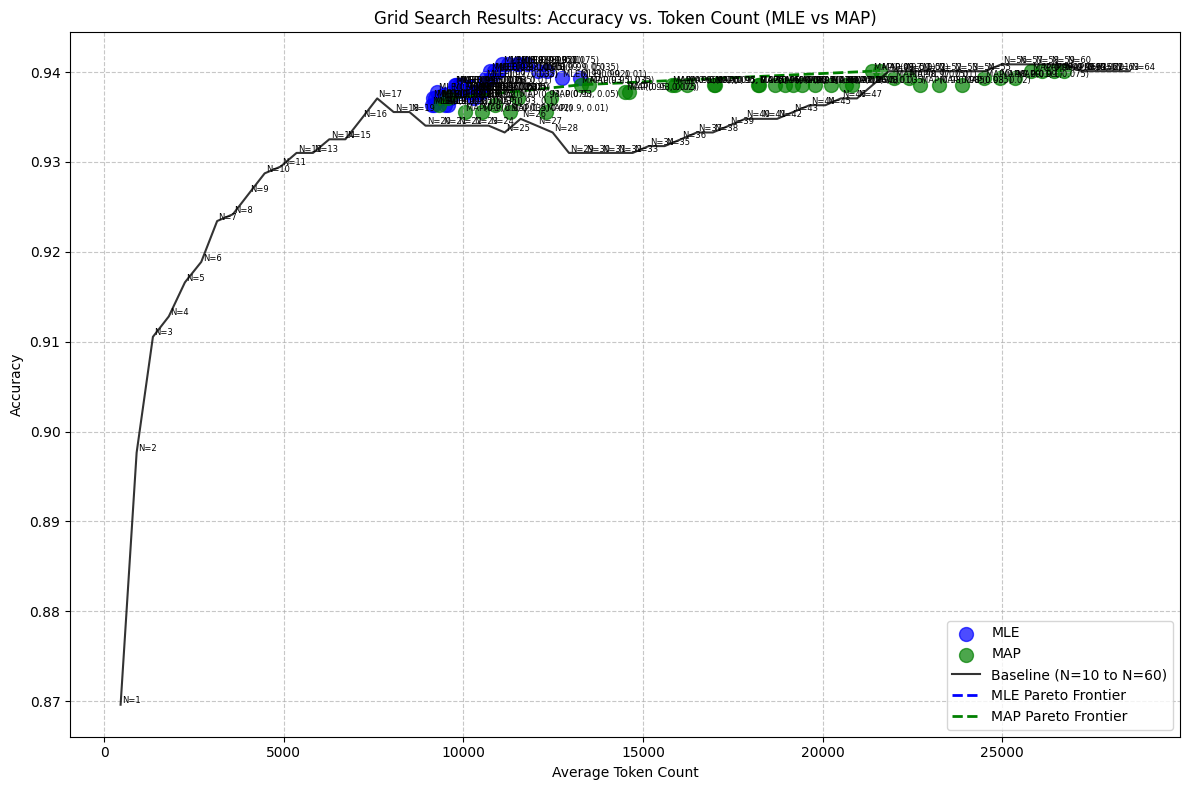


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9363, Avg Token Count: 9125.61
Target Score: 0.9, Percentile: 0.075, Accuracy: 0.9371, Avg Token Count: 9146.75
Target Score: 0.9, Percentile: 0.02, Accuracy: 0.9378, Avg Token Count: 9273.58
Target Score: 0.95, Percentile: 0.075, Accuracy: 0.9386, Avg Token Count: 9756.88
Target Score: 0.97, Percentile: 0.035, Accuracy: 0.9393, Avg Token Count: 10629.71
Target Score: 0.98, Percentile: 0.1, Accuracy: 0.9401, Avg Token Count: 10746.60
Target Score: 0.98, Percentile: 0.035, Accuracy: 0.9409, Avg Token Count: 11086.20

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9363, Avg Token Count: 9315.15
Target Score: 0.9, Percentile: 0.075, Accuracy: 0.9371, Avg Token Count: 9557.22
Target Score: 0.93, Percentile: 0.035, Accuracy: 0.9386, Avg Token Count: 13273.79
Target Score: 0.98, Percentile: 0.1, Accuracy: 0.9401, Avg Token Count: 21386.27


In [14]:
max_N_panel = 64
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)